In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [2]:
##This is adapted from https://github.com/tkipf/gae/blob/master/gae/train.py and https://github.com/tkipf/pygcn/blob/master/pygcn/train.py##

import time
import os

# Train on CPU (hide GPU) due to memory constraints
# os.environ['CUDA_VISIBLE_DEVICES'] = ""

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Settings
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=True
maskedgeName='knn20_connectivity'
epochs=10000
saveFreq=20
lr=0.001 #initial learning rate
lr_adv=0.001
weight_decay=0 #Weight for L2 loss on embedding matrix.

hidden1=5000 #Number of units in hidden layer 1
hidden2=5000 #Number of units in hidden layer 2
# hidden3=2048
# hidden4=2048
# hidden5=128
fc_dim1=5000
# fc_dim2=128
# fc_dim3=128
# fc_dim4=128
# gcn_dim1=2600
# clf_hidden=256
adv_hidden=128

dropout=0.01
testNodes=0.1 #fraction of total nodes for testing
valNodes=0.05 #fraction of total nodes for validation
XreconWeight=20
# clfweight=20
advWeight=2
# randFeatureSubset=None
model_str='fc1_dca'
clf=None
adv=None  #'clf_fc1_eq'  #'clf_fc1_control_eq' #'clf_fc1_control'  #'clf_fc1'
protein=None #'scaled_binary'
proteinWeights=0.05
adj_decodeName=None #gala or None
ridgeL=0.01
shareGenePi=True

pretrainedAE=None #{'name':'controlphy5XAbin_01_dca','epoch':9990}
num_features=2112
# training_samples=['control13','disease13','disease8']###rename and retrain C8
training_samples=['control13','disease13','disease8','control8']
# training_samples=['control13','control8']
targetBatch=None
training_sample_X='logminmax'
switchFreq=100
standardizeX=False
# name='allk20XA_01_dca_noD8' ###rename and retrain D8 C8
name='allk20XA_FCXonly_07_dca_over'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
savedir=os.path.join('/home/xinyiz/starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if training_sample_X in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in sampleidx.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==sampleidx[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==sampleidx[s]])

else:
    scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in sampleidx.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==sampleidx[s]]

        if training_sample_X=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)
        elif training_sample_X=='logminmax10':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler(feature_range=(0,10))
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+training_sample_X]=torch.tensor(featurelog_train_minmax)

if protein:
    proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
    for s in sampleidx.keys():
        pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
        pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
        pmtx=pmtx.to_dense()
        scalefactor=torch.sum(featureslist[s+'X_'+training_sample_X])/torch.sum(pmtx)*proteinWeights
        featureslist[s+'X_'+training_sample_X]=torch.cat((featureslist[s+'X_'+training_sample_X],pmtx*scalefactor),dim=1)
            
if clf:
    ctlist={}
    ctlist['disease13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9494','top_level'].to_numpy()
    ctlist['control13']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9498','top_level'].to_numpy()
    ctlist['disease8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9723','top_level'].to_numpy()
    ctlist['control8']=scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'].to_numpy()
    ct_unique=np.unique(scaleddata.obs.loc[scaleddata.obs['sample']=='AD_mouse9735','top_level'])
    for k in ctlist.keys():
        for i in range(ct_unique.size):
            ctlist[k][ctlist[k]==ct_unique[i]]=i
    
adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label.todense())
    
if adv:
    if 'control_eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)
    elif 'control' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['control13']=torch.tensor([0,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['control13']=torch.tensor([1,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,1]).expand(adjnormlist['control8'].shape[0],-1)        
    elif 'eq' in adv:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([0.5,0.5,0.5,0.5]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
    else:
        sampleLabellist_ae={}
        sampleLabellist_ae['disease13']=torch.tensor([0,1,1,1]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_ae['control13']=torch.tensor([1,0,1,1]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_ae['disease8']=torch.tensor([1,1,0,1]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_ae['control8']=torch.tensor([1,1,1,0]).expand(adjnormlist['control8'].shape[0],-1)

        sampleLabellist_d={}
        sampleLabellist_d['disease13']=torch.tensor([1,0,0,0]).expand(adjnormlist['disease13'].shape[0],-1)
        sampleLabellist_d['control13']=torch.tensor([0,1,0,0]).expand(adjnormlist['control13'].shape[0],-1)
        sampleLabellist_d['disease8']=torch.tensor([0,0,1,0]).expand(adjnormlist['disease8'].shape[0],-1)
        sampleLabellist_d['control8']=torch.tensor([0,0,0,1]).expand(adjnormlist['control8'].shape[0],-1)
        
    
        
    
# adj_decode=None
# if adj_decodeName == 'gala':
#     adj_decode=preprocessing.preprocess_graph_sharp(adj_train)



if 'dca' in model_str:
    rawdata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
    features_raw_list={}
    for s in sampleidx.keys():
#         features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]]).cuda()
        features_raw_list[s+'X_'+'raw']=torch.tensor(rawdata.X[rawdata.obs['sample']==sampleidx[s]])
        if protein:
            proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
            pmtx=sp.load_npz(os.path.join(proteinsavepath,sampleidx[s]+'_'+protein+'.npz'))
            pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
            pmtx=pmtx.to_dense()
            scalefactor=torch.sum(features_raw_list[s+'X_raw'])/torch.sum(pmtx)*proteinWeights
            features_raw_list[s+'X_raw']=torch.cat((features_raw_list[s+'X_raw'],pmtx*scalefactor),dim=1)

if clf:
    ct_train=ctlist[training_samples].astype(int)
# features=torch.tensor(np.identity(7000)).float()
# features=features[0:10,:]
if standardizeX:
    features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))

# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True

# Load data
# if randFeatureSubset != None:
#     idx=np.random.choice(features.shape[1],randFeatureSubset,replace=False)
#     features=features[:,idx]


In [4]:
if not os.path.exists(logsavepath):
    os.mkdir(logsavepath)
if not os.path.exists(modelsavepath):
    os.mkdir(modelsavepath)
if not os.path.exists(plotsavepath):
    os.mkdir(plotsavepath)

In [5]:
# loop over all train/validation sets

mse=torch.nn.MSELoss()
# mse=torch.nn.MSELoss(reduction=None)
# Create model
if model_str=='gcn_vae_xa':
    model = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_gcnX_inprA_w':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA_w(num_features, hidden1, hidden2,gcn_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='gcn_vae_xa_e3':
    model = gae.gae.model.GCNModelVAE_XA_e3(num_features, hidden1, hidden2,hidden3,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str == 'gcn_vae_xa_e1':
    model = gae.gae.model.GCNModelVAE_XA_e1(num_features, hidden1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE

elif model_str == 'gcn_vae_xa_e2_d1':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dca_fca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_fca(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE
    
elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE

elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_zinb
    loss_a=optimizer.optimizer_CE    
    
elif model_str == 'gcn_vae_xa_e4_d1':
    model = gae.gae.model.GCNModelVAE_XA_e4_d1(num_features, hidden1,hidden2,hidden3,hidden4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc':
    model = gae.gae.model.FCVAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_kl=optimizer.optimizer_kl
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
    loss_a=optimizer.optimizer_CE
elif model_str=='fcae':
    model = gae.gae.model.FCAE(num_features, hidden1, hidden2,hidden3,hidden4,hidden5,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse

elif model_str=='fcae1':
    model = gae.gae.model.FCAE1(num_features, dropout,hidden1)
    loss_x=optimizer.optimizer_MSE
#     loss_x=mse
elif model_str=='fcae2':
    model = gae.gae.model.FCAE2(num_features, dropout,hidden1,hidden2)
    loss_x=optimizer.optimizer_MSE

elif model_str=='fc1':
    model = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

elif model_str=='fc1_fca':
    model = gae.gae.model.FCVAE1_fca(num_features, hidden1,dropout)
    loss_x=optimizer.optimizer_MSE
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE    
    
elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
    loss_x=optimizer.optimizer_zinb
    loss_kl=optimizer.optimizer_kl
    loss_a=optimizer.optimizer_CE

if clf=='clf_fc1':
    modelClf=gae.gae.model.Clf_fc1(hidden2, dropout,clf_hidden,ct_unique.size)
    loss_clf=torch.nn.CrossEntropyLoss()
    
if adv=='clf_fc1' or adv=='clf_fc1_eq' or adv=='clf_fc1_control' or adv=='clf_fc1_control_eq':
    modelAdv=gae.gae.model.Clf_fc1(hidden2, dropout,adv_hidden,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if adv=='clf_linear1' or adv=='clf_linear1_control':
    modelAdv=gae.gae.model.Clf_linear1(hidden2, dropout,sampleLabellist_ae['control13'].size()[1])
    loss_adv=optimizer.optimizer_CEclf
    
if 'NB' in name:
    print('using NB loss for X')
    loss_x=optimizer.optimizer_nb
    
if use_cuda:
    model.cuda()
    if clf:
        modelClf.cuda()
        ct_train=torch.tensor(ct_train).cuda()
    if adv:
        modelAdv.cuda()
#         for sk in sampleLabellist_ae.keys():
#             sampleLabellist_ae[sk]=sampleLabellist_ae[sk].cuda().float()
#             sampleLabellist_d[sk]=sampleLabellist_d[sk].cuda().float()
#     for fk in featureslist.keys():
#         featureslist[fk] = featureslist[fk].cuda().float()
#     for ak in adj_list.keys():
#         adjnormlist[ak] =adjnormlist[ak].cuda()
#         adj_list[ak] = adj_list[ak].cuda().float()
#     if adj_decode is not None:
#         adj_decode=adj_decode.cuda()
    

optimizerVAEXA = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
if clf:
    optimizerClf=optim.Adam(modelClf.parameters(), lr=lr, weight_decay=weight_decay)
if adv:
    optimizerAdv=optim.Adam(modelAdv.parameters(), lr=lr_adv, weight_decay=weight_decay)    


In [6]:
# model.load_state_dict(torch.load(os.path.join(modelsavepath,str(9360)+'.pt')))
# epochs=20000
if pretrainedAE:
    print('loading '+pretrainedAE['name']+' epoch '+str(pretrainedAE['epoch']))
    model.load_state_dict(torch.load(os.path.join('/mnt/xinyi/pamrats/models/train_gae_starmap/'+pretrainedAE['name'],str(pretrainedAE['epoch'])+'.pt')))
    
def train(epoch):
    t = time.time()
    model.train()
    optimizerVAEXA.zero_grad()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.train()
        optimizerClf.zero_grad()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        modelAdv.eval()
        advOut=modelAdv(z)
    
#     z=None
#     torch.cuda.empty_cache()
    
    loss_kl_train=loss_kl(mu, logvar, train_nodes_idx)
    
#     mu=None
#     logvar=None
#     torch.cuda.empty_cache()
    
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight)
        else:
            loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_train=loss_x(features_recon, features,train_nodes_idx,XreconWeight,mse)
    
#     features_recon=None
#     torch.cuda.empty_cache()
    
    loss_a_train=loss_a(adj_recon, adj_label, pos_weight, norm,train_nodes_idx)
    
#     adj_recon=None
# #     train_nodes_idx=None
#     torch.cuda.empty_cache()
    
#     loss = loss_kl_train+loss_x_train+loss_a_train
#     loss=loss_x_train #for lossXreconOnly only
    loss=loss_kl_train+loss_x_train #for lossXreconOnly_wKL only
#     loss = loss_kl_train+loss_a_train #for lossAreconOnly_wKL only
    if clf:
        loss_clf_train=loss_clf(clfOut[train_nodes_idx],ct_train[train_nodes_idx])
        loss=loss+clfweight*loss_clf_train
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_train=loss_adv(advOut,sampleLabel_ae,train_nodes_idx)
        loss+=loss_adv_train*advWeight
    loss.backward()
    optimizerVAEXA.step()
    if clf:
        optimizerClf.step()

    if not fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run & no variation in z.
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    #         features_recon, z, mu, logvar=model(features.float())
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight)
        else:
            loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_val=loss_x(features_recon, features,val_nodes_idx,XreconWeight,mse)
    
#     features_recon=None
#     torch.cuda.empty_cache()
    
    loss_a_val=loss_a(adj_recon, adj_label, pos_weight, norm,val_nodes_idx)
    
#     adj_recon=None
# #     val_nodes_idx=None
#     torch.cuda.empty_cache()
    
#     loss_val = loss_x_val+loss_a_val
    loss_val=loss_x_val
#     loss_val=loss_a_val
    if clf:
        loss_clf_val=loss_clf(clfOut[val_nodes_idx],ct_train[val_nodes_idx])
        loss_val=loss_val+clfweight*loss_clf_val
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        loss_adv_val=loss_adv(advOut,sampleLabel_ae,val_nodes_idx)
        loss_val+=loss_adv_val*advWeight
#     print(features_recon[:5,:5])
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_train: {:.4f}'.format(loss.item()),
          'loss_kl_train: {:.4f}'.format(loss_kl_train.item()),
          'loss_x_train: {:.4f}'.format(loss_x_train.item()),
          'loss_a_train: {:.4f}'.format(loss_a_train.item()),
#           'loss_clf_train: {:.4f}'.format(loss_clf_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'loss_x_val: {:.4f}'.format(loss_x_val.item()),
          'loss_a_val: {:.4f}'.format(loss_a_val.item()),
#           'loss_clf_val: {:.4f}'.format(loss_clf_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
        print('loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
              'loss_adv_val: {:.4f}'.format(loss_adv_val.item())
             )
#     return loss.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
#     return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_val.item(),loss_x_val.item()
    if clf:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item(),loss_clf_train.item(),loss_clf_val.item()
    elif adv:
        if (training_samples_t in list(sampleLabellist_ae.keys())) and (training_samples_t != targetBatch):
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),float(loss_adv_train),float(loss_adv_val)        
        else:
            return float(loss),float(loss_kl_train),float(loss_x_train),float(loss_a_train),float(loss_val),float(loss_x_val),float(loss_a_val),None,None   
    else:
        return loss.item(),loss_kl_train.item(),loss_x_train.item(),loss_a_train.item(),loss_val.item(),loss_x_val.item(),loss_a_val.item()        

def train_discriminator(epoch):
    t = time.time()
    model.eval()
    
    if adj_decodeName==None:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm)
    #     features_recon, z, mu, logvar=model(features.float())
    else:
        adj_recon,mu,logvar,z,features_recon = model(features, adj_norm,adj_decode)
        
    
    if clf:
        modelClf.eval()
        clfOut=modelClf(z)
        
    modelAdv.train()
    optimizerAdv.zero_grad()
    advOut=modelAdv(z)
    
    loss_adv_train=loss_adv(advOut,sampleLabel_d,train_nodes_idx)
    loss = loss_adv_train*advWeight
    
    loss.backward()
    optimizerAdv.step()

    modelAdv.eval()
    advOut=modelAdv(z)
    loss_adv_val=loss_adv(advOut,sampleLabel_d,val_nodes_idx)
    loss_val=loss_adv_val*advWeight
    print(training_samples_t+' Epoch: {:04d}'.format(epoch),
          'loss_adv_train: {:.4f}'.format(loss_adv_train.item()),
          'loss_adv_val: {:.4f}'.format(loss_adv_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    return float(loss_adv_train),float(loss_adv_val)
    
# print('cross-validation ',seti)
train_loss_ep=[None]*epochs
train_loss_kl_ep=[None]*epochs
train_loss_x_ep=[None]*epochs
train_loss_a_ep=[None]*epochs
train_loss_clf_ep=[None]*epochs
train_loss_adv_ep=[None]*epochs
train_loss_advD_ep=[None]*epochs
val_loss_ep=[None]*epochs
val_loss_x_ep=[None]*epochs
val_loss_a_ep=[None]*epochs
val_loss_clf_ep=[None]*epochs
val_loss_adv_ep=[None]*epochs
val_loss_advD_ep=[None]*epochs
t_ep=time.time()

for ep in range(epochs):
# for ep in range(10000,20000):
    t=int(ep/switchFreq)%len(training_samples)
    training_samples_t=training_samples[t]
    
#     adj_norm=adjnormlist[training_samples_t]
#     adj_label=adj_list[training_samples_t]
#     features=featureslist[training_samples_t+'X_'+training_sample_X]
    adj_norm=adjnormlist[training_samples_t].cuda().float()
    adj_label=adj_list[training_samples_t].cuda().float()
    features=featureslist[training_samples_t+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[training_samples_t]
    norm=normlist[training_samples_t]
    if adv and (training_samples_t in list(sampleLabellist_ae.keys())):
#         sampleLabel_ae=sampleLabellist_ae[training_samples_t]
#         sampleLabel_d=sampleLabellist_d[training_samples_t]
        sampleLabel_ae=sampleLabellist_ae[training_samples_t].cuda().float()
        sampleLabel_d=sampleLabellist_d[training_samples_t].cuda().float()
    if 'dca' in model_str:
#         features_raw=features_raw_list[training_samples_t+'X_raw']
        features_raw=features_raw_list[training_samples_t+'X_raw'].cuda()
    num_nodes,_ = features.shape
    
    maskpath=os.path.join(savedir,'trainMask',training_samples_t+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes,seed=seed)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    if use_cuda:
        train_nodes_idx=train_nodes_idx.cuda()
        val_nodes_idx=val_nodes_idx.cuda()
        test_nodes_idx=test_nodes_idx.cuda()
    
    if clf:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_clf_ep[ep],val_loss_clf_ep[ep]=train(ep)
    elif adv:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep],train_loss_adv_ep[ep],val_loss_adv_ep[ep]=train(ep)
        if (training_samples_t in list(sampleLabellist_ae.keys())):
            train_loss_advD_ep[ep],val_loss_advD_ep[ep]=train_discriminator(ep)
    else:
        train_loss_ep[ep],train_loss_kl_ep[ep],train_loss_x_ep[ep],train_loss_a_ep[ep],val_loss_ep[ep],val_loss_x_ep[ep],val_loss_a_ep[ep]=train(ep)

        
    if ep%saveFreq == 0:
        torch.save(model.cpu().state_dict(), os.path.join(modelsavepath,str(ep)+'.pt'))
    if use_cuda:
        model.cuda()
        torch.cuda.empty_cache()
print(' total time: {:.4f}s'.format(time.time() - t_ep))


control13 Epoch: 0000 loss_train: 8.4341 loss_kl_train: 0.7000 loss_x_train: 7.7341 loss_a_train: 167.5239 loss_val: 7.5258 loss_x_val: 7.5258 loss_a_val: 1.1727 time: 1.5243s
control13 Epoch: 0001 loss_train: 3.8657 loss_kl_train: 0.5149 loss_x_train: 3.3508 loss_a_train: 158.7167 loss_val: 7.2223 loss_x_val: 7.2223 loss_a_val: 1.6858 time: 1.4253s
control13 Epoch: 0002 loss_train: 3.1005 loss_kl_train: 0.4422 loss_x_train: 2.6583 loss_a_train: 155.6944 loss_val: 7.3081 loss_x_val: 7.3081 loss_a_val: 2.4312 time: 1.3997s
control13 Epoch: 0003 loss_train: 3.0470 loss_kl_train: 0.3998 loss_x_train: 2.6472 loss_a_train: 152.5510 loss_val: 5.7646 loss_x_val: 5.7646 loss_a_val: 1.9097 time: 1.4148s
control13 Epoch: 0004 loss_train: 2.9033 loss_kl_train: 0.3749 loss_x_train: 2.5285 loss_a_train: 150.7058 loss_val: 4.7585 loss_x_val: 4.7585 loss_a_val: 1.6560 time: 1.4097s
control13 Epoch: 0005 loss_train: 2.8218 loss_kl_train: 0.3561 loss_x_train: 2.4657 loss_a_train: 149.1941 loss_val: 4.5

control13 Epoch: 0047 loss_train: 1.6400 loss_kl_train: 0.1933 loss_x_train: 1.4466 loss_a_train: 147.4365 loss_val: 1.4908 loss_x_val: 1.4908 loss_a_val: 139.6002 time: 1.4345s
control13 Epoch: 0048 loss_train: 1.6094 loss_kl_train: 0.1918 loss_x_train: 1.4175 loss_a_train: 147.5019 loss_val: 1.4772 loss_x_val: 1.4772 loss_a_val: 137.9030 time: 1.4243s
control13 Epoch: 0049 loss_train: 1.5911 loss_kl_train: 0.1898 loss_x_train: 1.4013 loss_a_train: 147.2099 loss_val: 1.4683 loss_x_val: 1.4683 loss_a_val: 136.3026 time: 1.4130s
control13 Epoch: 0050 loss_train: 1.6367 loss_kl_train: 0.1880 loss_x_train: 1.4486 loss_a_train: 146.7105 loss_val: 1.4795 loss_x_val: 1.4795 loss_a_val: 135.1810 time: 1.4195s
control13 Epoch: 0051 loss_train: 1.5875 loss_kl_train: 0.1862 loss_x_train: 1.4013 loss_a_train: 146.4113 loss_val: 1.4634 loss_x_val: 1.4634 loss_a_val: 134.0192 time: 1.4243s
control13 Epoch: 0052 loss_train: 1.5764 loss_kl_train: 0.1844 loss_x_train: 1.3921 loss_a_train: 146.5733 los

control13 Epoch: 0094 loss_train: 1.4713 loss_kl_train: 0.1265 loss_x_train: 1.3447 loss_a_train: 128.8029 loss_val: 1.3587 loss_x_val: 1.3587 loss_a_val: 116.8462 time: 1.4189s
control13 Epoch: 0095 loss_train: 1.4702 loss_kl_train: 0.1254 loss_x_train: 1.3448 loss_a_train: 128.6754 loss_val: 1.3582 loss_x_val: 1.3582 loss_a_val: 116.7909 time: 1.4053s
control13 Epoch: 0096 loss_train: 1.4688 loss_kl_train: 0.1246 loss_x_train: 1.3442 loss_a_train: 127.9921 loss_val: 1.3577 loss_x_val: 1.3577 loss_a_val: 116.7382 time: 1.4109s
control13 Epoch: 0097 loss_train: 1.4673 loss_kl_train: 0.1234 loss_x_train: 1.3438 loss_a_train: 127.4727 loss_val: 1.3572 loss_x_val: 1.3572 loss_a_val: 116.6939 time: 1.4399s
control13 Epoch: 0098 loss_train: 1.4660 loss_kl_train: 0.1226 loss_x_train: 1.3434 loss_a_train: 126.9222 loss_val: 1.3569 loss_x_val: 1.3569 loss_a_val: 116.6511 time: 1.4130s
control13 Epoch: 0099 loss_train: 1.4648 loss_kl_train: 0.1214 loss_x_train: 1.3434 loss_a_train: 126.6139 los

disease13 Epoch: 0141 loss_train: 1.5618 loss_kl_train: 0.0945 loss_x_train: 1.4673 loss_a_train: 127.6198 loss_val: 1.4802 loss_x_val: 1.4802 loss_a_val: 114.4139 time: 1.9299s
disease13 Epoch: 0142 loss_train: 1.5610 loss_kl_train: 0.0939 loss_x_train: 1.4671 loss_a_train: 126.9597 loss_val: 1.4801 loss_x_val: 1.4801 loss_a_val: 114.2224 time: 1.9239s
disease13 Epoch: 0143 loss_train: 1.5602 loss_kl_train: 0.0931 loss_x_train: 1.4671 loss_a_train: 126.6584 loss_val: 1.4800 loss_x_val: 1.4800 loss_a_val: 114.0160 time: 1.9321s
disease13 Epoch: 0144 loss_train: 1.5592 loss_kl_train: 0.0923 loss_x_train: 1.4669 loss_a_train: 126.2230 loss_val: 1.4799 loss_x_val: 1.4799 loss_a_val: 113.7909 time: 1.9138s
disease13 Epoch: 0145 loss_train: 1.5584 loss_kl_train: 0.0918 loss_x_train: 1.4666 loss_a_train: 126.0809 loss_val: 1.4798 loss_x_val: 1.4798 loss_a_val: 113.5540 time: 1.9322s
disease13 Epoch: 0146 loss_train: 1.5574 loss_kl_train: 0.0909 loss_x_train: 1.4665 loss_a_train: 125.2048 los

disease13 Epoch: 0188 loss_train: 1.5310 loss_kl_train: 0.0694 loss_x_train: 1.4616 loss_a_train: 109.5262 loss_val: 1.4772 loss_x_val: 1.4772 loss_a_val: 102.6777 time: 1.9389s
disease13 Epoch: 0189 loss_train: 1.5305 loss_kl_train: 0.0690 loss_x_train: 1.4616 loss_a_train: 108.7349 loss_val: 1.4772 loss_x_val: 1.4772 loss_a_val: 102.4529 time: 1.9362s
disease13 Epoch: 0190 loss_train: 1.5302 loss_kl_train: 0.0687 loss_x_train: 1.4616 loss_a_train: 108.5524 loss_val: 1.4772 loss_x_val: 1.4772 loss_a_val: 102.2457 time: 1.9325s
disease13 Epoch: 0191 loss_train: 1.5295 loss_kl_train: 0.0682 loss_x_train: 1.4613 loss_a_train: 108.1646 loss_val: 1.4773 loss_x_val: 1.4773 loss_a_val: 102.0319 time: 1.9354s
disease13 Epoch: 0192 loss_train: 1.5292 loss_kl_train: 0.0679 loss_x_train: 1.4613 loss_a_train: 107.7536 loss_val: 1.4773 loss_x_val: 1.4773 loss_a_val: 101.8269 time: 1.9350s
disease13 Epoch: 0193 loss_train: 1.5287 loss_kl_train: 0.0675 loss_x_train: 1.4612 loss_a_train: 107.4152 los

disease8 Epoch: 0235 loss_train: 1.3503 loss_kl_train: 0.0804 loss_x_train: 1.2699 loss_a_train: 89.6819 loss_val: 1.2657 loss_x_val: 1.2657 loss_a_val: 81.0730 time: 1.3221s
disease8 Epoch: 0236 loss_train: 1.3495 loss_kl_train: 0.0795 loss_x_train: 1.2700 loss_a_train: 89.2709 loss_val: 1.2658 loss_x_val: 1.2658 loss_a_val: 80.9754 time: 1.3017s
disease8 Epoch: 0237 loss_train: 1.3482 loss_kl_train: 0.0786 loss_x_train: 1.2696 loss_a_train: 88.6210 loss_val: 1.2658 loss_x_val: 1.2658 loss_a_val: 80.8756 time: 1.3159s
disease8 Epoch: 0238 loss_train: 1.3474 loss_kl_train: 0.0777 loss_x_train: 1.2697 loss_a_train: 88.0760 loss_val: 1.2658 loss_x_val: 1.2658 loss_a_val: 80.8135 time: 1.3033s
disease8 Epoch: 0239 loss_train: 1.3466 loss_kl_train: 0.0769 loss_x_train: 1.2697 loss_a_train: 87.7316 loss_val: 1.2660 loss_x_val: 1.2660 loss_a_val: 80.7845 time: 1.3144s
disease8 Epoch: 0240 loss_train: 1.3458 loss_kl_train: 0.0762 loss_x_train: 1.2696 loss_a_train: 87.4503 loss_val: 1.2661 los

disease8 Epoch: 0282 loss_train: 1.3210 loss_kl_train: 0.0538 loss_x_train: 1.2673 loss_a_train: 70.5375 loss_val: 1.2752 loss_x_val: 1.2752 loss_a_val: 79.0161 time: 1.3090s
disease8 Epoch: 0283 loss_train: 1.3205 loss_kl_train: 0.0535 loss_x_train: 1.2670 loss_a_train: 70.4209 loss_val: 1.2757 loss_x_val: 1.2757 loss_a_val: 78.9585 time: 1.3280s
disease8 Epoch: 0284 loss_train: 1.3201 loss_kl_train: 0.0530 loss_x_train: 1.2671 loss_a_train: 69.9775 loss_val: 1.2764 loss_x_val: 1.2764 loss_a_val: 78.8834 time: 1.3183s
disease8 Epoch: 0285 loss_train: 1.3196 loss_kl_train: 0.0527 loss_x_train: 1.2669 loss_a_train: 69.7605 loss_val: 1.2770 loss_x_val: 1.2770 loss_a_val: 78.7957 time: 1.3184s
disease8 Epoch: 0286 loss_train: 1.3191 loss_kl_train: 0.0523 loss_x_train: 1.2668 loss_a_train: 69.4898 loss_val: 1.2774 loss_x_val: 1.2774 loss_a_val: 78.7136 time: 1.3197s
disease8 Epoch: 0287 loss_train: 1.3188 loss_kl_train: 0.0519 loss_x_train: 1.2669 loss_a_train: 69.0364 loss_val: 1.2780 los

control8 Epoch: 0329 loss_train: 1.4589 loss_kl_train: 0.0505 loss_x_train: 1.4084 loss_a_train: 66.2417 loss_val: 1.4275 loss_x_val: 1.4275 loss_a_val: 53.7883 time: 1.4674s
control8 Epoch: 0330 loss_train: 1.4583 loss_kl_train: 0.0501 loss_x_train: 1.4082 loss_a_train: 66.1087 loss_val: 1.4270 loss_x_val: 1.4270 loss_a_val: 53.4729 time: 1.4896s
control8 Epoch: 0331 loss_train: 1.4577 loss_kl_train: 0.0496 loss_x_train: 1.4080 loss_a_train: 65.6335 loss_val: 1.4264 loss_x_val: 1.4264 loss_a_val: 53.1902 time: 1.4666s
control8 Epoch: 0332 loss_train: 1.4574 loss_kl_train: 0.0493 loss_x_train: 1.4081 loss_a_train: 65.4685 loss_val: 1.4261 loss_x_val: 1.4261 loss_a_val: 52.9703 time: 1.4768s
control8 Epoch: 0333 loss_train: 1.4565 loss_kl_train: 0.0486 loss_x_train: 1.4079 loss_a_train: 65.1145 loss_val: 1.4258 loss_x_val: 1.4258 loss_a_val: 52.7809 time: 1.4774s
control8 Epoch: 0334 loss_train: 1.4563 loss_kl_train: 0.0483 loss_x_train: 1.4079 loss_a_train: 64.7648 loss_val: 1.4256 los

control8 Epoch: 0376 loss_train: 1.4407 loss_kl_train: 0.0357 loss_x_train: 1.4050 loss_a_train: 54.8546 loss_val: 1.4371 loss_x_val: 1.4371 loss_a_val: 50.7859 time: 1.4706s
control8 Epoch: 0377 loss_train: 1.4403 loss_kl_train: 0.0354 loss_x_train: 1.4050 loss_a_train: 54.6135 loss_val: 1.4374 loss_x_val: 1.4374 loss_a_val: 50.6574 time: 1.4712s
control8 Epoch: 0378 loss_train: 1.4401 loss_kl_train: 0.0353 loss_x_train: 1.4048 loss_a_train: 54.4894 loss_val: 1.4377 loss_x_val: 1.4377 loss_a_val: 50.4875 time: 1.4801s
control8 Epoch: 0379 loss_train: 1.4401 loss_kl_train: 0.0350 loss_x_train: 1.4051 loss_a_train: 54.3596 loss_val: 1.4379 loss_x_val: 1.4379 loss_a_val: 50.2096 time: 1.4910s
control8 Epoch: 0380 loss_train: 1.4396 loss_kl_train: 0.0348 loss_x_train: 1.4048 loss_a_train: 54.0931 loss_val: 1.4382 loss_x_val: 1.4382 loss_a_val: 49.9701 time: 1.4742s
control8 Epoch: 0381 loss_train: 1.4393 loss_kl_train: 0.0346 loss_x_train: 1.4046 loss_a_train: 53.8750 loss_val: 1.4387 los

control13 Epoch: 0423 loss_train: 1.3560 loss_kl_train: 0.0295 loss_x_train: 1.3265 loss_a_train: 47.5912 loss_val: 1.3470 loss_x_val: 1.3470 loss_a_val: 33.6932 time: 1.4110s
control13 Epoch: 0424 loss_train: 1.3558 loss_kl_train: 0.0294 loss_x_train: 1.3264 loss_a_train: 47.3713 loss_val: 1.3469 loss_x_val: 1.3469 loss_a_val: 33.5522 time: 1.4182s
control13 Epoch: 0425 loss_train: 1.3554 loss_kl_train: 0.0290 loss_x_train: 1.3264 loss_a_train: 47.2951 loss_val: 1.3465 loss_x_val: 1.3465 loss_a_val: 33.4092 time: 1.4209s
control13 Epoch: 0426 loss_train: 1.3550 loss_kl_train: 0.0289 loss_x_train: 1.3262 loss_a_train: 47.1908 loss_val: 1.3461 loss_x_val: 1.3461 loss_a_val: 33.2934 time: 1.4295s
control13 Epoch: 0427 loss_train: 1.3549 loss_kl_train: 0.0287 loss_x_train: 1.3262 loss_a_train: 46.9447 loss_val: 1.3460 loss_x_val: 1.3460 loss_a_val: 33.1827 time: 1.4246s
control13 Epoch: 0428 loss_train: 1.3545 loss_kl_train: 0.0285 loss_x_train: 1.3261 loss_a_train: 46.7985 loss_val: 1.34

control13 Epoch: 0470 loss_train: 1.3456 loss_kl_train: 0.0219 loss_x_train: 1.3237 loss_a_train: 41.4254 loss_val: 1.3527 loss_x_val: 1.3527 loss_a_val: 30.8448 time: 1.4112s
control13 Epoch: 0471 loss_train: 1.3455 loss_kl_train: 0.0218 loss_x_train: 1.3237 loss_a_train: 41.4785 loss_val: 1.3532 loss_x_val: 1.3532 loss_a_val: 30.8294 time: 1.4347s
control13 Epoch: 0472 loss_train: 1.3453 loss_kl_train: 0.0217 loss_x_train: 1.3236 loss_a_train: 41.3535 loss_val: 1.3534 loss_x_val: 1.3534 loss_a_val: 30.8159 time: 1.4301s
control13 Epoch: 0473 loss_train: 1.3451 loss_kl_train: 0.0216 loss_x_train: 1.3235 loss_a_train: 41.1865 loss_val: 1.3539 loss_x_val: 1.3539 loss_a_val: 30.7959 time: 1.4130s
control13 Epoch: 0474 loss_train: 1.3449 loss_kl_train: 0.0215 loss_x_train: 1.3234 loss_a_train: 41.1090 loss_val: 1.3546 loss_x_val: 1.3546 loss_a_val: 30.7767 time: 1.4091s
control13 Epoch: 0475 loss_train: 1.3448 loss_kl_train: 0.0214 loss_x_train: 1.3234 loss_a_train: 41.0183 loss_val: 1.35

disease13 Epoch: 0517 loss_train: 1.4739 loss_kl_train: 0.0205 loss_x_train: 1.4534 loss_a_train: 42.8678 loss_val: 1.4721 loss_x_val: 1.4721 loss_a_val: 25.4798 time: 1.9238s
disease13 Epoch: 0518 loss_train: 1.4735 loss_kl_train: 0.0204 loss_x_train: 1.4532 loss_a_train: 42.9431 loss_val: 1.4720 loss_x_val: 1.4720 loss_a_val: 25.6886 time: 1.9296s
disease13 Epoch: 0519 loss_train: 1.4733 loss_kl_train: 0.0203 loss_x_train: 1.4531 loss_a_train: 42.9327 loss_val: 1.4719 loss_x_val: 1.4719 loss_a_val: 25.8798 time: 1.9291s
disease13 Epoch: 0520 loss_train: 1.4731 loss_kl_train: 0.0202 loss_x_train: 1.4530 loss_a_train: 42.7715 loss_val: 1.4718 loss_x_val: 1.4718 loss_a_val: 26.0537 time: 1.9255s
disease13 Epoch: 0521 loss_train: 1.4729 loss_kl_train: 0.0201 loss_x_train: 1.4528 loss_a_train: 42.7762 loss_val: 1.4720 loss_x_val: 1.4720 loss_a_val: 26.2116 time: 1.9349s
disease13 Epoch: 0522 loss_train: 1.4726 loss_kl_train: 0.0199 loss_x_train: 1.4527 loss_a_train: 42.6198 loss_val: 1.47

disease13 Epoch: 0564 loss_train: 1.4661 loss_kl_train: 0.0162 loss_x_train: 1.4499 loss_a_train: 39.3623 loss_val: 1.4724 loss_x_val: 1.4724 loss_a_val: 23.2430 time: 1.9440s
disease13 Epoch: 0565 loss_train: 1.4661 loss_kl_train: 0.0161 loss_x_train: 1.4499 loss_a_train: 39.3896 loss_val: 1.4727 loss_x_val: 1.4727 loss_a_val: 23.1975 time: 1.9249s
disease13 Epoch: 0566 loss_train: 1.4660 loss_kl_train: 0.0161 loss_x_train: 1.4499 loss_a_train: 39.2788 loss_val: 1.4725 loss_x_val: 1.4725 loss_a_val: 23.1395 time: 1.9180s
disease13 Epoch: 0567 loss_train: 1.4658 loss_kl_train: 0.0160 loss_x_train: 1.4498 loss_a_train: 39.1397 loss_val: 1.4727 loss_x_val: 1.4727 loss_a_val: 23.0668 time: 1.9223s
disease13 Epoch: 0568 loss_train: 1.4657 loss_kl_train: 0.0160 loss_x_train: 1.4497 loss_a_train: 39.1109 loss_val: 1.4728 loss_x_val: 1.4728 loss_a_val: 23.0153 time: 1.9195s
disease13 Epoch: 0569 loss_train: 1.4655 loss_kl_train: 0.0159 loss_x_train: 1.4496 loss_a_train: 39.1107 loss_val: 1.47

disease8 Epoch: 0611 loss_train: 1.2884 loss_kl_train: 0.0213 loss_x_train: 1.2672 loss_a_train: 38.7174 loss_val: 1.2640 loss_x_val: 1.2640 loss_a_val: 17.3896 time: 1.3326s
disease8 Epoch: 0612 loss_train: 1.2865 loss_kl_train: 0.0211 loss_x_train: 1.2653 loss_a_train: 38.6617 loss_val: 1.2646 loss_x_val: 1.2646 loss_a_val: 17.3037 time: 1.3197s
disease8 Epoch: 0613 loss_train: 1.2871 loss_kl_train: 0.0210 loss_x_train: 1.2661 loss_a_train: 38.5743 loss_val: 1.2631 loss_x_val: 1.2631 loss_a_val: 17.2843 time: 1.3311s
disease8 Epoch: 0614 loss_train: 1.2853 loss_kl_train: 0.0208 loss_x_train: 1.2645 loss_a_train: 38.5673 loss_val: 1.2639 loss_x_val: 1.2639 loss_a_val: 17.2857 time: 1.3288s
disease8 Epoch: 0615 loss_train: 1.2855 loss_kl_train: 0.0208 loss_x_train: 1.2648 loss_a_train: 38.5623 loss_val: 1.2645 loss_x_val: 1.2645 loss_a_val: 17.2976 time: 1.3290s
disease8 Epoch: 0616 loss_train: 1.2857 loss_kl_train: 0.0205 loss_x_train: 1.2652 loss_a_train: 38.4835 loss_val: 1.2629 los

disease8 Epoch: 0658 loss_train: 1.2749 loss_kl_train: 0.0153 loss_x_train: 1.2596 loss_a_train: 35.5257 loss_val: 1.2773 loss_x_val: 1.2773 loss_a_val: 19.1277 time: 1.3180s
disease8 Epoch: 0659 loss_train: 1.2749 loss_kl_train: 0.0152 loss_x_train: 1.2597 loss_a_train: 35.3331 loss_val: 1.2776 loss_x_val: 1.2776 loss_a_val: 19.0694 time: 1.3158s
disease8 Epoch: 0660 loss_train: 1.2747 loss_kl_train: 0.0151 loss_x_train: 1.2596 loss_a_train: 35.3225 loss_val: 1.2780 loss_x_val: 1.2780 loss_a_val: 19.0326 time: 1.3231s
disease8 Epoch: 0661 loss_train: 1.2747 loss_kl_train: 0.0151 loss_x_train: 1.2596 loss_a_train: 35.3941 loss_val: 1.2784 loss_x_val: 1.2784 loss_a_val: 19.0026 time: 1.3061s
disease8 Epoch: 0662 loss_train: 1.2746 loss_kl_train: 0.0150 loss_x_train: 1.2596 loss_a_train: 35.1554 loss_val: 1.2787 loss_x_val: 1.2787 loss_a_val: 18.9790 time: 1.3157s
disease8 Epoch: 0663 loss_train: 1.2744 loss_kl_train: 0.0149 loss_x_train: 1.2595 loss_a_train: 35.3354 loss_val: 1.2791 los

control8 Epoch: 0705 loss_train: 1.4199 loss_kl_train: 0.0157 loss_x_train: 1.4042 loss_a_train: 35.4993 loss_val: 1.4167 loss_x_val: 1.4167 loss_a_val: 11.8520 time: 1.4782s
control8 Epoch: 0706 loss_train: 1.4191 loss_kl_train: 0.0156 loss_x_train: 1.4035 loss_a_train: 35.5589 loss_val: 1.4171 loss_x_val: 1.4171 loss_a_val: 11.9525 time: 1.4688s
control8 Epoch: 0707 loss_train: 1.4199 loss_kl_train: 0.0155 loss_x_train: 1.4043 loss_a_train: 35.5714 loss_val: 1.4160 loss_x_val: 1.4160 loss_a_val: 12.0607 time: 1.4866s
control8 Epoch: 0708 loss_train: 1.4186 loss_kl_train: 0.0155 loss_x_train: 1.4031 loss_a_train: 35.6871 loss_val: 1.4161 loss_x_val: 1.4161 loss_a_val: 12.1738 time: 1.4825s
control8 Epoch: 0709 loss_train: 1.4191 loss_kl_train: 0.0155 loss_x_train: 1.4036 loss_a_train: 35.6029 loss_val: 1.4156 loss_x_val: 1.4156 loss_a_val: 12.2847 time: 1.4787s
control8 Epoch: 0710 loss_train: 1.4181 loss_kl_train: 0.0153 loss_x_train: 1.4028 loss_a_train: 35.5009 loss_val: 1.4156 los

control8 Epoch: 0752 loss_train: 1.4112 loss_kl_train: 0.0122 loss_x_train: 1.3990 loss_a_train: 33.7885 loss_val: 1.4143 loss_x_val: 1.4143 loss_a_val: 13.6160 time: 1.4935s
control8 Epoch: 0753 loss_train: 1.4110 loss_kl_train: 0.0121 loss_x_train: 1.3988 loss_a_train: 33.9721 loss_val: 1.4144 loss_x_val: 1.4144 loss_a_val: 13.5764 time: 1.4733s
control8 Epoch: 0754 loss_train: 1.4108 loss_kl_train: 0.0121 loss_x_train: 1.3987 loss_a_train: 34.0251 loss_val: 1.4144 loss_x_val: 1.4144 loss_a_val: 13.5332 time: 1.4856s
control8 Epoch: 0755 loss_train: 1.4108 loss_kl_train: 0.0121 loss_x_train: 1.3987 loss_a_train: 34.1056 loss_val: 1.4145 loss_x_val: 1.4145 loss_a_val: 13.4888 time: 1.4762s
control8 Epoch: 0756 loss_train: 1.4107 loss_kl_train: 0.0120 loss_x_train: 1.3987 loss_a_train: 33.8345 loss_val: 1.4145 loss_x_val: 1.4145 loss_a_val: 13.4511 time: 1.4866s
control8 Epoch: 0757 loss_train: 1.4105 loss_kl_train: 0.0119 loss_x_train: 1.3986 loss_a_train: 34.0727 loss_val: 1.4147 los

control8 Epoch: 0799 loss_train: 1.4078 loss_kl_train: 0.0102 loss_x_train: 1.3975 loss_a_train: 33.0909 loss_val: 1.4203 loss_x_val: 1.4203 loss_a_val: 12.5371 time: 1.4666s
control13 Epoch: 0800 loss_train: 1.3336 loss_kl_train: 0.0104 loss_x_train: 1.3232 loss_a_train: 32.8531 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 10.7451 time: 1.4189s
control13 Epoch: 0801 loss_train: 1.3337 loss_kl_train: 0.0104 loss_x_train: 1.3234 loss_a_train: 33.0128 loss_val: 1.3356 loss_x_val: 1.3356 loss_a_val: 10.3553 time: 1.4225s
control13 Epoch: 0802 loss_train: 1.3342 loss_kl_train: 0.0103 loss_x_train: 1.3239 loss_a_train: 32.9919 loss_val: 1.3350 loss_x_val: 1.3350 loss_a_val: 9.9811 time: 1.4136s
control13 Epoch: 0803 loss_train: 1.3334 loss_kl_train: 0.0103 loss_x_train: 1.3231 loss_a_train: 32.9083 loss_val: 1.3349 loss_x_val: 1.3349 loss_a_val: 9.6180 time: 1.4300s
control13 Epoch: 0804 loss_train: 1.3333 loss_kl_train: 0.0103 loss_x_train: 1.3230 loss_a_train: 32.8754 loss_val: 1.3347 

control13 Epoch: 0846 loss_train: 1.3276 loss_kl_train: 0.0087 loss_x_train: 1.3189 loss_a_train: 32.4266 loss_val: 1.3339 loss_x_val: 1.3339 loss_a_val: 8.6852 time: 1.4268s
control13 Epoch: 0847 loss_train: 1.3275 loss_kl_train: 0.0086 loss_x_train: 1.3188 loss_a_train: 32.2674 loss_val: 1.3340 loss_x_val: 1.3340 loss_a_val: 8.6823 time: 1.4291s
control13 Epoch: 0848 loss_train: 1.3275 loss_kl_train: 0.0086 loss_x_train: 1.3189 loss_a_train: 32.3774 loss_val: 1.3339 loss_x_val: 1.3339 loss_a_val: 8.6698 time: 1.4303s
control13 Epoch: 0849 loss_train: 1.3273 loss_kl_train: 0.0086 loss_x_train: 1.3187 loss_a_train: 32.3867 loss_val: 1.3340 loss_x_val: 1.3340 loss_a_val: 8.6543 time: 1.4168s
control13 Epoch: 0850 loss_train: 1.3274 loss_kl_train: 0.0086 loss_x_train: 1.3188 loss_a_train: 32.2792 loss_val: 1.3340 loss_x_val: 1.3340 loss_a_val: 8.6365 time: 1.4181s
control13 Epoch: 0851 loss_train: 1.3272 loss_kl_train: 0.0085 loss_x_train: 1.3187 loss_a_train: 32.3225 loss_val: 1.3341 lo

control13 Epoch: 0893 loss_train: 1.3253 loss_kl_train: 0.0075 loss_x_train: 1.3178 loss_a_train: 31.7513 loss_val: 1.3353 loss_x_val: 1.3353 loss_a_val: 7.9704 time: 1.4219s
control13 Epoch: 0894 loss_train: 1.3253 loss_kl_train: 0.0075 loss_x_train: 1.3178 loss_a_train: 31.9771 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 7.9559 time: 1.4131s
control13 Epoch: 0895 loss_train: 1.3251 loss_kl_train: 0.0075 loss_x_train: 1.3177 loss_a_train: 31.9030 loss_val: 1.3354 loss_x_val: 1.3354 loss_a_val: 7.9514 time: 1.4191s
control13 Epoch: 0896 loss_train: 1.3251 loss_kl_train: 0.0075 loss_x_train: 1.3177 loss_a_train: 31.9133 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 7.9552 time: 1.4151s
control13 Epoch: 0897 loss_train: 1.3252 loss_kl_train: 0.0074 loss_x_train: 1.3178 loss_a_train: 31.9551 loss_val: 1.3355 loss_x_val: 1.3355 loss_a_val: 7.9599 time: 1.4254s
control13 Epoch: 0898 loss_train: 1.3251 loss_kl_train: 0.0074 loss_x_train: 1.3177 loss_a_train: 31.9389 loss_val: 1.3356 lo

disease13 Epoch: 0940 loss_train: 1.4538 loss_kl_train: 0.0073 loss_x_train: 1.4465 loss_a_train: 32.4961 loss_val: 1.4635 loss_x_val: 1.4635 loss_a_val: 7.6901 time: 1.9347s
disease13 Epoch: 0941 loss_train: 1.4535 loss_kl_train: 0.0073 loss_x_train: 1.4463 loss_a_train: 32.2605 loss_val: 1.4634 loss_x_val: 1.4634 loss_a_val: 7.7347 time: 1.9208s
disease13 Epoch: 0942 loss_train: 1.4534 loss_kl_train: 0.0072 loss_x_train: 1.4462 loss_a_train: 32.3526 loss_val: 1.4635 loss_x_val: 1.4635 loss_a_val: 7.7756 time: 1.9159s
disease13 Epoch: 0943 loss_train: 1.4535 loss_kl_train: 0.0072 loss_x_train: 1.4463 loss_a_train: 32.4262 loss_val: 1.4634 loss_x_val: 1.4634 loss_a_val: 7.8160 time: 1.9336s
disease13 Epoch: 0944 loss_train: 1.4532 loss_kl_train: 0.0072 loss_x_train: 1.4460 loss_a_train: 32.4241 loss_val: 1.4634 loss_x_val: 1.4634 loss_a_val: 7.8589 time: 1.9388s
disease13 Epoch: 0945 loss_train: 1.4533 loss_kl_train: 0.0072 loss_x_train: 1.4461 loss_a_train: 32.3823 loss_val: 1.4634 lo

disease13 Epoch: 0987 loss_train: 1.4511 loss_kl_train: 0.0066 loss_x_train: 1.4445 loss_a_train: 31.9598 loss_val: 1.4627 loss_x_val: 1.4627 loss_a_val: 7.3975 time: 1.9385s
disease13 Epoch: 0988 loss_train: 1.4509 loss_kl_train: 0.0066 loss_x_train: 1.4444 loss_a_train: 32.0488 loss_val: 1.4626 loss_x_val: 1.4626 loss_a_val: 7.3739 time: 1.9347s
disease13 Epoch: 0989 loss_train: 1.4509 loss_kl_train: 0.0065 loss_x_train: 1.4444 loss_a_train: 31.8876 loss_val: 1.4627 loss_x_val: 1.4627 loss_a_val: 7.3569 time: 1.9266s
disease13 Epoch: 0990 loss_train: 1.4509 loss_kl_train: 0.0065 loss_x_train: 1.4444 loss_a_train: 32.1336 loss_val: 1.4627 loss_x_val: 1.4627 loss_a_val: 7.3455 time: 1.9400s
disease13 Epoch: 0991 loss_train: 1.4509 loss_kl_train: 0.0065 loss_x_train: 1.4444 loss_a_train: 31.9563 loss_val: 1.4627 loss_x_val: 1.4627 loss_a_val: 7.3342 time: 1.9490s
disease13 Epoch: 0992 loss_train: 1.4509 loss_kl_train: 0.0065 loss_x_train: 1.4444 loss_a_train: 31.9368 loss_val: 1.4626 lo

disease8 Epoch: 1035 loss_train: 1.2644 loss_kl_train: 0.0078 loss_x_train: 1.2567 loss_a_train: 31.9561 loss_val: 1.2586 loss_x_val: 1.2586 loss_a_val: 6.8559 time: 1.3154s
disease8 Epoch: 1036 loss_train: 1.2642 loss_kl_train: 0.0078 loss_x_train: 1.2564 loss_a_train: 32.0657 loss_val: 1.2587 loss_x_val: 1.2587 loss_a_val: 6.8857 time: 1.3093s
disease8 Epoch: 1037 loss_train: 1.2643 loss_kl_train: 0.0077 loss_x_train: 1.2566 loss_a_train: 31.9235 loss_val: 1.2587 loss_x_val: 1.2587 loss_a_val: 6.9156 time: 1.3126s
disease8 Epoch: 1038 loss_train: 1.2641 loss_kl_train: 0.0077 loss_x_train: 1.2565 loss_a_train: 32.0088 loss_val: 1.2586 loss_x_val: 1.2586 loss_a_val: 6.9516 time: 1.3128s
disease8 Epoch: 1039 loss_train: 1.2641 loss_kl_train: 0.0076 loss_x_train: 1.2564 loss_a_train: 31.8519 loss_val: 1.2587 loss_x_val: 1.2587 loss_a_val: 6.9817 time: 1.3141s
disease8 Epoch: 1040 loss_train: 1.2642 loss_kl_train: 0.0076 loss_x_train: 1.2565 loss_a_train: 31.8854 loss_val: 1.2588 loss_x_v

disease8 Epoch: 1083 loss_train: 1.2621 loss_kl_train: 0.0066 loss_x_train: 1.2555 loss_a_train: 31.5312 loss_val: 1.2595 loss_x_val: 1.2595 loss_a_val: 6.7939 time: 1.3202s
disease8 Epoch: 1084 loss_train: 1.2620 loss_kl_train: 0.0066 loss_x_train: 1.2554 loss_a_train: 31.6783 loss_val: 1.2596 loss_x_val: 1.2596 loss_a_val: 6.7841 time: 1.3121s
disease8 Epoch: 1085 loss_train: 1.2620 loss_kl_train: 0.0066 loss_x_train: 1.2554 loss_a_train: 31.7532 loss_val: 1.2596 loss_x_val: 1.2596 loss_a_val: 6.7797 time: 1.3160s
disease8 Epoch: 1086 loss_train: 1.2620 loss_kl_train: 0.0066 loss_x_train: 1.2554 loss_a_train: 31.6342 loss_val: 1.2596 loss_x_val: 1.2596 loss_a_val: 6.7730 time: 1.3157s
disease8 Epoch: 1087 loss_train: 1.2619 loss_kl_train: 0.0065 loss_x_train: 1.2554 loss_a_train: 31.5736 loss_val: 1.2596 loss_x_val: 1.2596 loss_a_val: 6.7660 time: 1.3202s
disease8 Epoch: 1088 loss_train: 1.2619 loss_kl_train: 0.0065 loss_x_train: 1.2554 loss_a_train: 31.6934 loss_val: 1.2596 loss_x_v

control8 Epoch: 1131 loss_train: 1.4036 loss_kl_train: 0.0067 loss_x_train: 1.3969 loss_a_train: 31.9197 loss_val: 1.4077 loss_x_val: 1.4077 loss_a_val: 5.1559 time: 1.4880s
control8 Epoch: 1132 loss_train: 1.4036 loss_kl_train: 0.0067 loss_x_train: 1.3969 loss_a_train: 31.7904 loss_val: 1.4076 loss_x_val: 1.4076 loss_a_val: 5.2018 time: 1.4842s
control8 Epoch: 1133 loss_train: 1.4032 loss_kl_train: 0.0067 loss_x_train: 1.3966 loss_a_train: 31.8452 loss_val: 1.4077 loss_x_val: 1.4077 loss_a_val: 5.2473 time: 1.4754s
control8 Epoch: 1134 loss_train: 1.4033 loss_kl_train: 0.0067 loss_x_train: 1.3966 loss_a_train: 31.7403 loss_val: 1.4076 loss_x_val: 1.4076 loss_a_val: 5.2879 time: 1.4818s
control8 Epoch: 1135 loss_train: 1.4031 loss_kl_train: 0.0066 loss_x_train: 1.3965 loss_a_train: 31.4443 loss_val: 1.4075 loss_x_val: 1.4075 loss_a_val: 5.3274 time: 1.4615s
control8 Epoch: 1136 loss_train: 1.4029 loss_kl_train: 0.0066 loss_x_train: 1.3963 loss_a_train: 31.6639 loss_val: 1.4077 loss_x_v

control8 Epoch: 1179 loss_train: 1.4005 loss_kl_train: 0.0060 loss_x_train: 1.3945 loss_a_train: 31.5232 loss_val: 1.4077 loss_x_val: 1.4077 loss_a_val: 5.4125 time: 1.4861s
control8 Epoch: 1180 loss_train: 1.4004 loss_kl_train: 0.0060 loss_x_train: 1.3945 loss_a_train: 31.3952 loss_val: 1.4077 loss_x_val: 1.4077 loss_a_val: 5.4077 time: 1.4865s
control8 Epoch: 1181 loss_train: 1.4005 loss_kl_train: 0.0059 loss_x_train: 1.3946 loss_a_train: 31.5391 loss_val: 1.4077 loss_x_val: 1.4077 loss_a_val: 5.4042 time: 1.4741s
control8 Epoch: 1182 loss_train: 1.4004 loss_kl_train: 0.0059 loss_x_train: 1.3945 loss_a_train: 31.5908 loss_val: 1.4077 loss_x_val: 1.4077 loss_a_val: 5.4053 time: 1.4953s
control8 Epoch: 1183 loss_train: 1.4004 loss_kl_train: 0.0059 loss_x_train: 1.3944 loss_a_train: 31.6333 loss_val: 1.4078 loss_x_val: 1.4078 loss_a_val: 5.4061 time: 1.4691s
control8 Epoch: 1184 loss_train: 1.4004 loss_kl_train: 0.0059 loss_x_train: 1.3945 loss_a_train: 31.5367 loss_val: 1.4078 loss_x_v

control13 Epoch: 1226 loss_train: 1.3224 loss_kl_train: 0.0053 loss_x_train: 1.3171 loss_a_train: 31.1304 loss_val: 1.3301 loss_x_val: 1.3301 loss_a_val: 3.7116 time: 1.4241s
control13 Epoch: 1227 loss_train: 1.3230 loss_kl_train: 0.0053 loss_x_train: 1.3177 loss_a_train: 31.3028 loss_val: 1.3295 loss_x_val: 1.3295 loss_a_val: 3.7043 time: 1.4131s
control13 Epoch: 1228 loss_train: 1.3220 loss_kl_train: 0.0053 loss_x_train: 1.3168 loss_a_train: 31.2640 loss_val: 1.3294 loss_x_val: 1.3294 loss_a_val: 3.7046 time: 1.4245s
control13 Epoch: 1229 loss_train: 1.3224 loss_kl_train: 0.0053 loss_x_train: 1.3172 loss_a_train: 31.1450 loss_val: 1.3293 loss_x_val: 1.3293 loss_a_val: 3.7068 time: 1.4073s
control13 Epoch: 1230 loss_train: 1.3220 loss_kl_train: 0.0053 loss_x_train: 1.3167 loss_a_train: 31.2788 loss_val: 1.3295 loss_x_val: 1.3295 loss_a_val: 3.7147 time: 1.4271s
control13 Epoch: 1231 loss_train: 1.3222 loss_kl_train: 0.0052 loss_x_train: 1.3169 loss_a_train: 31.3144 loss_val: 1.3293 lo

control13 Epoch: 1273 loss_train: 1.3201 loss_kl_train: 0.0048 loss_x_train: 1.3153 loss_a_train: 31.1901 loss_val: 1.3293 loss_x_val: 1.3293 loss_a_val: 3.8334 time: 1.4186s
control13 Epoch: 1274 loss_train: 1.3201 loss_kl_train: 0.0048 loss_x_train: 1.3153 loss_a_train: 31.1835 loss_val: 1.3293 loss_x_val: 1.3293 loss_a_val: 3.8227 time: 1.4202s
control13 Epoch: 1275 loss_train: 1.3200 loss_kl_train: 0.0048 loss_x_train: 1.3152 loss_a_train: 31.2825 loss_val: 1.3294 loss_x_val: 1.3294 loss_a_val: 3.8140 time: 1.4295s
control13 Epoch: 1276 loss_train: 1.3201 loss_kl_train: 0.0048 loss_x_train: 1.3152 loss_a_train: 30.9811 loss_val: 1.3293 loss_x_val: 1.3293 loss_a_val: 3.8097 time: 1.4216s
control13 Epoch: 1277 loss_train: 1.3200 loss_kl_train: 0.0048 loss_x_train: 1.3153 loss_a_train: 31.0321 loss_val: 1.3293 loss_x_val: 1.3293 loss_a_val: 3.8024 time: 1.4267s
control13 Epoch: 1278 loss_train: 1.3200 loss_kl_train: 0.0048 loss_x_train: 1.3152 loss_a_train: 31.0735 loss_val: 1.3293 lo

disease13 Epoch: 1320 loss_train: 1.4532 loss_kl_train: 0.0046 loss_x_train: 1.4486 loss_a_train: 31.4967 loss_val: 1.4658 loss_x_val: 1.4658 loss_a_val: 3.5357 time: 1.9410s
disease13 Epoch: 1321 loss_train: 1.4578 loss_kl_train: 0.0046 loss_x_train: 1.4533 loss_a_train: 31.3653 loss_val: 1.4645 loss_x_val: 1.4645 loss_a_val: 3.5351 time: 1.9361s
disease13 Epoch: 1322 loss_train: 1.4542 loss_kl_train: 0.0046 loss_x_train: 1.4497 loss_a_train: 31.4291 loss_val: 1.4646 loss_x_val: 1.4646 loss_a_val: 3.5299 time: 1.9465s
disease13 Epoch: 1323 loss_train: 1.4548 loss_kl_train: 0.0046 loss_x_train: 1.4502 loss_a_train: 31.6324 loss_val: 1.4647 loss_x_val: 1.4647 loss_a_val: 3.5214 time: 1.9249s
disease13 Epoch: 1324 loss_train: 1.4555 loss_kl_train: 0.0046 loss_x_train: 1.4509 loss_a_train: 31.4021 loss_val: 1.4619 loss_x_val: 1.4619 loss_a_val: 3.4957 time: 1.9271s
disease13 Epoch: 1325 loss_train: 1.4509 loss_kl_train: 0.0045 loss_x_train: 1.4464 loss_a_train: 31.4524 loss_val: 1.4629 lo

disease13 Epoch: 1367 loss_train: 1.4466 loss_kl_train: 0.0044 loss_x_train: 1.4423 loss_a_train: 31.2985 loss_val: 1.4591 loss_x_val: 1.4591 loss_a_val: 4.2712 time: 1.9408s
disease13 Epoch: 1368 loss_train: 1.4466 loss_kl_train: 0.0044 loss_x_train: 1.4422 loss_a_train: 31.3058 loss_val: 1.4591 loss_x_val: 1.4591 loss_a_val: 4.2714 time: 1.9282s
disease13 Epoch: 1369 loss_train: 1.4465 loss_kl_train: 0.0044 loss_x_train: 1.4422 loss_a_train: 31.2946 loss_val: 1.4591 loss_x_val: 1.4591 loss_a_val: 4.2725 time: 1.9247s
disease13 Epoch: 1370 loss_train: 1.4465 loss_kl_train: 0.0044 loss_x_train: 1.4421 loss_a_train: 31.3210 loss_val: 1.4591 loss_x_val: 1.4591 loss_a_val: 4.2755 time: 1.9325s
disease13 Epoch: 1371 loss_train: 1.4465 loss_kl_train: 0.0043 loss_x_train: 1.4421 loss_a_train: 31.4367 loss_val: 1.4590 loss_x_val: 1.4590 loss_a_val: 4.2768 time: 1.9354s
disease13 Epoch: 1372 loss_train: 1.4464 loss_kl_train: 0.0043 loss_x_train: 1.4421 loss_a_train: 31.2708 loss_val: 1.4590 lo

disease8 Epoch: 1414 loss_train: 1.2624 loss_kl_train: 0.0054 loss_x_train: 1.2570 loss_a_train: 31.1821 loss_val: 1.2533 loss_x_val: 1.2533 loss_a_val: 3.7542 time: 1.3324s
disease8 Epoch: 1415 loss_train: 1.2623 loss_kl_train: 0.0054 loss_x_train: 1.2569 loss_a_train: 31.3034 loss_val: 1.2526 loss_x_val: 1.2526 loss_a_val: 3.7533 time: 1.3261s
disease8 Epoch: 1416 loss_train: 1.2616 loss_kl_train: 0.0054 loss_x_train: 1.2562 loss_a_train: 31.2827 loss_val: 1.2526 loss_x_val: 1.2526 loss_a_val: 3.7519 time: 1.3181s
disease8 Epoch: 1417 loss_train: 1.2616 loss_kl_train: 0.0054 loss_x_train: 1.2562 loss_a_train: 31.3771 loss_val: 1.2531 loss_x_val: 1.2531 loss_a_val: 3.7533 time: 1.3253s
disease8 Epoch: 1418 loss_train: 1.2618 loss_kl_train: 0.0054 loss_x_train: 1.2564 loss_a_train: 31.4011 loss_val: 1.2528 loss_x_val: 1.2528 loss_a_val: 3.7515 time: 1.3285s
disease8 Epoch: 1419 loss_train: 1.2614 loss_kl_train: 0.0054 loss_x_train: 1.2560 loss_a_train: 31.2947 loss_val: 1.2525 loss_x_v

disease8 Epoch: 1462 loss_train: 1.2584 loss_kl_train: 0.0047 loss_x_train: 1.2536 loss_a_train: 31.3955 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 3.8751 time: 1.3187s
disease8 Epoch: 1463 loss_train: 1.2583 loss_kl_train: 0.0047 loss_x_train: 1.2536 loss_a_train: 31.2665 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 3.8764 time: 1.3109s
disease8 Epoch: 1464 loss_train: 1.2584 loss_kl_train: 0.0047 loss_x_train: 1.2537 loss_a_train: 31.2299 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 3.8769 time: 1.3361s
disease8 Epoch: 1465 loss_train: 1.2584 loss_kl_train: 0.0047 loss_x_train: 1.2536 loss_a_train: 31.1884 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 3.8733 time: 1.3169s
disease8 Epoch: 1466 loss_train: 1.2582 loss_kl_train: 0.0047 loss_x_train: 1.2535 loss_a_train: 31.1850 loss_val: 1.2520 loss_x_val: 1.2520 loss_a_val: 3.8697 time: 1.3193s
disease8 Epoch: 1467 loss_train: 1.2582 loss_kl_train: 0.0047 loss_x_train: 1.2535 loss_a_train: 31.2962 loss_val: 1.2520 loss_x_v

control8 Epoch: 1510 loss_train: 1.4013 loss_kl_train: 0.0047 loss_x_train: 1.3967 loss_a_train: 31.4451 loss_val: 1.4054 loss_x_val: 1.4054 loss_a_val: 3.2896 time: 1.4862s
control8 Epoch: 1511 loss_train: 1.4012 loss_kl_train: 0.0047 loss_x_train: 1.3965 loss_a_train: 31.1731 loss_val: 1.4050 loss_x_val: 1.4050 loss_a_val: 3.2951 time: 1.4750s
control8 Epoch: 1512 loss_train: 1.4003 loss_kl_train: 0.0047 loss_x_train: 1.3957 loss_a_train: 31.3634 loss_val: 1.4051 loss_x_val: 1.4051 loss_a_val: 3.2913 time: 1.4822s
control8 Epoch: 1513 loss_train: 1.4007 loss_kl_train: 0.0047 loss_x_train: 1.3961 loss_a_train: 31.4505 loss_val: 1.4051 loss_x_val: 1.4051 loss_a_val: 3.2717 time: 1.4737s
control8 Epoch: 1514 loss_train: 1.4008 loss_kl_train: 0.0046 loss_x_train: 1.3962 loss_a_train: 31.2994 loss_val: 1.4049 loss_x_val: 1.4049 loss_a_val: 3.2475 time: 1.4722s
control8 Epoch: 1515 loss_train: 1.4003 loss_kl_train: 0.0047 loss_x_train: 1.3957 loss_a_train: 31.5376 loss_val: 1.4052 loss_x_v

control8 Epoch: 1558 loss_train: 1.3972 loss_kl_train: 0.0044 loss_x_train: 1.3928 loss_a_train: 31.2176 loss_val: 1.4038 loss_x_val: 1.4038 loss_a_val: 3.4176 time: 1.4906s
control8 Epoch: 1559 loss_train: 1.3971 loss_kl_train: 0.0044 loss_x_train: 1.3927 loss_a_train: 31.0234 loss_val: 1.4038 loss_x_val: 1.4038 loss_a_val: 3.4268 time: 1.4619s
control8 Epoch: 1560 loss_train: 1.3972 loss_kl_train: 0.0044 loss_x_train: 1.3927 loss_a_train: 31.1472 loss_val: 1.4037 loss_x_val: 1.4037 loss_a_val: 3.4332 time: 1.4902s
control8 Epoch: 1561 loss_train: 1.3971 loss_kl_train: 0.0044 loss_x_train: 1.3927 loss_a_train: 31.1338 loss_val: 1.4038 loss_x_val: 1.4038 loss_a_val: 3.4343 time: 1.4793s
control8 Epoch: 1562 loss_train: 1.3971 loss_kl_train: 0.0044 loss_x_train: 1.3927 loss_a_train: 31.3167 loss_val: 1.4038 loss_x_val: 1.4038 loss_a_val: 3.4344 time: 1.4720s
control8 Epoch: 1563 loss_train: 1.3970 loss_kl_train: 0.0044 loss_x_train: 1.3926 loss_a_train: 31.0718 loss_val: 1.4038 loss_x_v

control13 Epoch: 1606 loss_train: 1.3213 loss_kl_train: 0.0040 loss_x_train: 1.3173 loss_a_train: 30.9913 loss_val: 1.3281 loss_x_val: 1.3281 loss_a_val: 2.3545 time: 1.4134s
control13 Epoch: 1607 loss_train: 1.3215 loss_kl_train: 0.0040 loss_x_train: 1.3176 loss_a_train: 31.0288 loss_val: 1.3279 loss_x_val: 1.3279 loss_a_val: 2.3346 time: 1.4196s
control13 Epoch: 1608 loss_train: 1.3211 loss_kl_train: 0.0040 loss_x_train: 1.3172 loss_a_train: 30.8512 loss_val: 1.3288 loss_x_val: 1.3288 loss_a_val: 2.3251 time: 1.4065s
control13 Epoch: 1609 loss_train: 1.3227 loss_kl_train: 0.0040 loss_x_train: 1.3188 loss_a_train: 30.9592 loss_val: 1.3288 loss_x_val: 1.3288 loss_a_val: 2.3165 time: 1.4314s
control13 Epoch: 1610 loss_train: 1.3223 loss_kl_train: 0.0039 loss_x_train: 1.3184 loss_a_train: 31.0084 loss_val: 1.3301 loss_x_val: 1.3301 loss_a_val: 2.3166 time: 1.4162s
control13 Epoch: 1611 loss_train: 1.3237 loss_kl_train: 0.0039 loss_x_train: 1.3198 loss_a_train: 30.8163 loss_val: 1.3291 lo

control13 Epoch: 1653 loss_train: 1.3176 loss_kl_train: 0.0038 loss_x_train: 1.3138 loss_a_train: 30.8391 loss_val: 1.3267 loss_x_val: 1.3267 loss_a_val: 2.7608 time: 1.4088s
control13 Epoch: 1654 loss_train: 1.3175 loss_kl_train: 0.0038 loss_x_train: 1.3138 loss_a_train: 30.9974 loss_val: 1.3266 loss_x_val: 1.3266 loss_a_val: 2.7659 time: 1.4231s
control13 Epoch: 1655 loss_train: 1.3175 loss_kl_train: 0.0038 loss_x_train: 1.3137 loss_a_train: 30.9619 loss_val: 1.3267 loss_x_val: 1.3267 loss_a_val: 2.7658 time: 1.4151s
control13 Epoch: 1656 loss_train: 1.3175 loss_kl_train: 0.0038 loss_x_train: 1.3138 loss_a_train: 30.9475 loss_val: 1.3266 loss_x_val: 1.3266 loss_a_val: 2.7655 time: 1.4212s
control13 Epoch: 1657 loss_train: 1.3175 loss_kl_train: 0.0038 loss_x_train: 1.3138 loss_a_train: 31.0234 loss_val: 1.3267 loss_x_val: 1.3267 loss_a_val: 2.7618 time: 1.4280s
control13 Epoch: 1658 loss_train: 1.3174 loss_kl_train: 0.0037 loss_x_train: 1.3137 loss_a_train: 31.0545 loss_val: 1.3267 lo

disease13 Epoch: 1700 loss_train: 1.4475 loss_kl_train: 0.0034 loss_x_train: 1.4442 loss_a_train: 31.2973 loss_val: 1.4592 loss_x_val: 1.4592 loss_a_val: 2.4376 time: 1.9254s
disease13 Epoch: 1701 loss_train: 1.4482 loss_kl_train: 0.0034 loss_x_train: 1.4448 loss_a_train: 31.2253 loss_val: 1.4595 loss_x_val: 1.4595 loss_a_val: 2.3964 time: 1.9275s
disease13 Epoch: 1702 loss_train: 1.4484 loss_kl_train: 0.0034 loss_x_train: 1.4451 loss_a_train: 31.1589 loss_val: 1.4591 loss_x_val: 1.4591 loss_a_val: 2.3612 time: 1.9288s
disease13 Epoch: 1703 loss_train: 1.4481 loss_kl_train: 0.0034 loss_x_train: 1.4447 loss_a_train: 31.1207 loss_val: 1.4593 loss_x_val: 1.4593 loss_a_val: 2.3329 time: 1.9259s
disease13 Epoch: 1704 loss_train: 1.4484 loss_kl_train: 0.0034 loss_x_train: 1.4451 loss_a_train: 31.1685 loss_val: 1.4593 loss_x_val: 1.4593 loss_a_val: 2.3160 time: 1.9302s
disease13 Epoch: 1705 loss_train: 1.4484 loss_kl_train: 0.0033 loss_x_train: 1.4450 loss_a_train: 31.0340 loss_val: 1.4592 lo

disease13 Epoch: 1747 loss_train: 1.4446 loss_kl_train: 0.0034 loss_x_train: 1.4412 loss_a_train: 31.0509 loss_val: 1.4574 loss_x_val: 1.4574 loss_a_val: 2.7284 time: 1.9267s
disease13 Epoch: 1748 loss_train: 1.4445 loss_kl_train: 0.0034 loss_x_train: 1.4411 loss_a_train: 31.1782 loss_val: 1.4573 loss_x_val: 1.4573 loss_a_val: 2.7391 time: 1.9143s
disease13 Epoch: 1749 loss_train: 1.4443 loss_kl_train: 0.0034 loss_x_train: 1.4409 loss_a_train: 31.1576 loss_val: 1.4573 loss_x_val: 1.4573 loss_a_val: 2.7475 time: 1.9386s
disease13 Epoch: 1750 loss_train: 1.4445 loss_kl_train: 0.0034 loss_x_train: 1.4410 loss_a_train: 31.0579 loss_val: 1.4572 loss_x_val: 1.4572 loss_a_val: 2.7585 time: 1.9277s
disease13 Epoch: 1751 loss_train: 1.4442 loss_kl_train: 0.0034 loss_x_train: 1.4408 loss_a_train: 31.1663 loss_val: 1.4572 loss_x_val: 1.4572 loss_a_val: 2.7711 time: 1.9273s
disease13 Epoch: 1752 loss_train: 1.4442 loss_kl_train: 0.0034 loss_x_train: 1.4408 loss_a_train: 31.2652 loss_val: 1.4572 lo

disease13 Epoch: 1794 loss_train: 1.4433 loss_kl_train: 0.0034 loss_x_train: 1.4399 loss_a_train: 30.9269 loss_val: 1.4569 loss_x_val: 1.4569 loss_a_val: 2.8888 time: 1.9371s
disease13 Epoch: 1795 loss_train: 1.4433 loss_kl_train: 0.0034 loss_x_train: 1.4400 loss_a_train: 31.0371 loss_val: 1.4568 loss_x_val: 1.4568 loss_a_val: 2.8835 time: 1.9252s
disease13 Epoch: 1796 loss_train: 1.4433 loss_kl_train: 0.0034 loss_x_train: 1.4399 loss_a_train: 30.9127 loss_val: 1.4569 loss_x_val: 1.4569 loss_a_val: 2.8779 time: 1.9390s
disease13 Epoch: 1797 loss_train: 1.4433 loss_kl_train: 0.0034 loss_x_train: 1.4400 loss_a_train: 31.0028 loss_val: 1.4568 loss_x_val: 1.4568 loss_a_val: 2.8709 time: 1.9393s
disease13 Epoch: 1798 loss_train: 1.4433 loss_kl_train: 0.0034 loss_x_train: 1.4399 loss_a_train: 31.1002 loss_val: 1.4568 loss_x_val: 1.4568 loss_a_val: 2.8632 time: 1.9292s
disease13 Epoch: 1799 loss_train: 1.4433 loss_kl_train: 0.0034 loss_x_train: 1.4399 loss_a_train: 30.8167 loss_val: 1.4568 lo

disease8 Epoch: 1842 loss_train: 1.2566 loss_kl_train: 0.0039 loss_x_train: 1.2527 loss_a_train: 31.2600 loss_val: 1.2500 loss_x_val: 1.2500 loss_a_val: 2.9878 time: 1.3167s
disease8 Epoch: 1843 loss_train: 1.2568 loss_kl_train: 0.0039 loss_x_train: 1.2529 loss_a_train: 31.1799 loss_val: 1.2498 loss_x_val: 1.2498 loss_a_val: 3.0089 time: 1.3077s
disease8 Epoch: 1844 loss_train: 1.2565 loss_kl_train: 0.0039 loss_x_train: 1.2527 loss_a_train: 31.0328 loss_val: 1.2499 loss_x_val: 1.2499 loss_a_val: 3.0283 time: 1.3143s
disease8 Epoch: 1845 loss_train: 1.2566 loss_kl_train: 0.0039 loss_x_train: 1.2527 loss_a_train: 30.8686 loss_val: 1.2497 loss_x_val: 1.2497 loss_a_val: 3.0420 time: 1.3028s
disease8 Epoch: 1846 loss_train: 1.2565 loss_kl_train: 0.0039 loss_x_train: 1.2527 loss_a_train: 31.2008 loss_val: 1.2497 loss_x_val: 1.2497 loss_a_val: 3.0528 time: 1.3126s
disease8 Epoch: 1847 loss_train: 1.2564 loss_kl_train: 0.0039 loss_x_train: 1.2525 loss_a_train: 31.2468 loss_val: 1.2498 loss_x_v

disease8 Epoch: 1890 loss_train: 1.2555 loss_kl_train: 0.0036 loss_x_train: 1.2519 loss_a_train: 31.1848 loss_val: 1.2497 loss_x_val: 1.2497 loss_a_val: 2.8371 time: 1.3215s
disease8 Epoch: 1891 loss_train: 1.2555 loss_kl_train: 0.0036 loss_x_train: 1.2518 loss_a_train: 31.0516 loss_val: 1.2496 loss_x_val: 1.2496 loss_a_val: 2.8348 time: 1.3071s
disease8 Epoch: 1892 loss_train: 1.2554 loss_kl_train: 0.0037 loss_x_train: 1.2518 loss_a_train: 31.0000 loss_val: 1.2497 loss_x_val: 1.2497 loss_a_val: 2.8308 time: 1.3150s
disease8 Epoch: 1893 loss_train: 1.2555 loss_kl_train: 0.0036 loss_x_train: 1.2519 loss_a_train: 31.2095 loss_val: 1.2497 loss_x_val: 1.2497 loss_a_val: 2.8289 time: 1.3069s
disease8 Epoch: 1894 loss_train: 1.2554 loss_kl_train: 0.0036 loss_x_train: 1.2518 loss_a_train: 30.9878 loss_val: 1.2496 loss_x_val: 1.2496 loss_a_val: 2.8298 time: 1.3149s
disease8 Epoch: 1895 loss_train: 1.2554 loss_kl_train: 0.0036 loss_x_train: 1.2518 loss_a_train: 30.8677 loss_val: 1.2497 loss_x_v

control8 Epoch: 1938 loss_train: 1.3958 loss_kl_train: 0.0036 loss_x_train: 1.3922 loss_a_train: 30.9653 loss_val: 1.4023 loss_x_val: 1.4023 loss_a_val: 2.4795 time: 1.4840s
control8 Epoch: 1939 loss_train: 1.3957 loss_kl_train: 0.0036 loss_x_train: 1.3921 loss_a_train: 30.9608 loss_val: 1.4022 loss_x_val: 1.4022 loss_a_val: 2.4852 time: 1.4742s
control8 Epoch: 1940 loss_train: 1.3954 loss_kl_train: 0.0036 loss_x_train: 1.3918 loss_a_train: 31.1135 loss_val: 1.4024 loss_x_val: 1.4024 loss_a_val: 2.4925 time: 1.4902s
control8 Epoch: 1941 loss_train: 1.3956 loss_kl_train: 0.0036 loss_x_train: 1.3919 loss_a_train: 30.9694 loss_val: 1.4024 loss_x_val: 1.4024 loss_a_val: 2.4978 time: 1.4668s
control8 Epoch: 1942 loss_train: 1.3955 loss_kl_train: 0.0036 loss_x_train: 1.3919 loss_a_train: 30.9287 loss_val: 1.4024 loss_x_val: 1.4024 loss_a_val: 2.5040 time: 1.4984s
control8 Epoch: 1943 loss_train: 1.3956 loss_kl_train: 0.0036 loss_x_train: 1.3920 loss_a_train: 30.9746 loss_val: 1.4023 loss_x_v

control8 Epoch: 1986 loss_train: 1.3944 loss_kl_train: 0.0035 loss_x_train: 1.3909 loss_a_train: 30.8986 loss_val: 1.4022 loss_x_val: 1.4022 loss_a_val: 2.5712 time: 1.4764s
control8 Epoch: 1987 loss_train: 1.3944 loss_kl_train: 0.0035 loss_x_train: 1.3909 loss_a_train: 31.0194 loss_val: 1.4021 loss_x_val: 1.4021 loss_a_val: 2.5733 time: 1.4621s
control8 Epoch: 1988 loss_train: 1.3944 loss_kl_train: 0.0035 loss_x_train: 1.3908 loss_a_train: 30.7465 loss_val: 1.4021 loss_x_val: 1.4021 loss_a_val: 2.5717 time: 1.4734s
control8 Epoch: 1989 loss_train: 1.3944 loss_kl_train: 0.0035 loss_x_train: 1.3909 loss_a_train: 30.9039 loss_val: 1.4022 loss_x_val: 1.4022 loss_a_val: 2.5677 time: 1.4826s
control8 Epoch: 1990 loss_train: 1.3943 loss_kl_train: 0.0035 loss_x_train: 1.3908 loss_a_train: 30.9048 loss_val: 1.4021 loss_x_val: 1.4021 loss_a_val: 2.5641 time: 1.4732s
control8 Epoch: 1991 loss_train: 1.3943 loss_kl_train: 0.0035 loss_x_train: 1.3908 loss_a_train: 30.8577 loss_val: 1.4022 loss_x_v

control13 Epoch: 2033 loss_train: 1.3162 loss_kl_train: 0.0032 loss_x_train: 1.3130 loss_a_train: 30.8185 loss_val: 1.3251 loss_x_val: 1.3251 loss_a_val: 2.1379 time: 1.4097s
control13 Epoch: 2034 loss_train: 1.3161 loss_kl_train: 0.0032 loss_x_train: 1.3129 loss_a_train: 30.9053 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 2.1370 time: 1.4270s
control13 Epoch: 2035 loss_train: 1.3162 loss_kl_train: 0.0032 loss_x_train: 1.3129 loss_a_train: 30.6879 loss_val: 1.3251 loss_x_val: 1.3251 loss_a_val: 2.1350 time: 1.4060s
control13 Epoch: 2036 loss_train: 1.3160 loss_kl_train: 0.0032 loss_x_train: 1.3127 loss_a_train: 30.8901 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 2.1305 time: 1.4226s
control13 Epoch: 2037 loss_train: 1.3160 loss_kl_train: 0.0032 loss_x_train: 1.3128 loss_a_train: 30.8736 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 2.1234 time: 1.4181s
control13 Epoch: 2038 loss_train: 1.3161 loss_kl_train: 0.0032 loss_x_train: 1.3129 loss_a_train: 30.7026 loss_val: 1.3251 lo

control13 Epoch: 2080 loss_train: 1.3153 loss_kl_train: 0.0031 loss_x_train: 1.3122 loss_a_train: 30.6808 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 2.0304 time: 1.4167s
control13 Epoch: 2081 loss_train: 1.3153 loss_kl_train: 0.0031 loss_x_train: 1.3122 loss_a_train: 30.8726 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 2.0320 time: 1.4202s
control13 Epoch: 2082 loss_train: 1.3153 loss_kl_train: 0.0031 loss_x_train: 1.3122 loss_a_train: 30.8715 loss_val: 1.3253 loss_x_val: 1.3253 loss_a_val: 2.0359 time: 1.4063s
control13 Epoch: 2083 loss_train: 1.3154 loss_kl_train: 0.0031 loss_x_train: 1.3122 loss_a_train: 30.6881 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 2.0382 time: 1.4364s
control13 Epoch: 2084 loss_train: 1.3153 loss_kl_train: 0.0031 loss_x_train: 1.3122 loss_a_train: 30.8687 loss_val: 1.3253 loss_x_val: 1.3253 loss_a_val: 2.0424 time: 1.4293s
control13 Epoch: 2085 loss_train: 1.3152 loss_kl_train: 0.0031 loss_x_train: 1.3121 loss_a_train: 30.7870 loss_val: 1.3253 lo

disease13 Epoch: 2127 loss_train: 1.4446 loss_kl_train: 0.0028 loss_x_train: 1.4418 loss_a_train: 30.8195 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 2.1396 time: 1.9347s
disease13 Epoch: 2128 loss_train: 1.4437 loss_kl_train: 0.0028 loss_x_train: 1.4408 loss_a_train: 30.7078 loss_val: 1.4571 loss_x_val: 1.4571 loss_a_val: 2.1245 time: 1.9251s
disease13 Epoch: 2129 loss_train: 1.4444 loss_kl_train: 0.0028 loss_x_train: 1.4416 loss_a_train: 30.8488 loss_val: 1.4569 loss_x_val: 1.4569 loss_a_val: 2.1113 time: 1.9270s
disease13 Epoch: 2130 loss_train: 1.4439 loss_kl_train: 0.0028 loss_x_train: 1.4411 loss_a_train: 30.9892 loss_val: 1.4565 loss_x_val: 1.4565 loss_a_val: 2.1024 time: 1.9291s
disease13 Epoch: 2131 loss_train: 1.4436 loss_kl_train: 0.0028 loss_x_train: 1.4407 loss_a_train: 30.9525 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 2.0960 time: 1.9179s
disease13 Epoch: 2132 loss_train: 1.4440 loss_kl_train: 0.0028 loss_x_train: 1.4411 loss_a_train: 31.1324 loss_val: 1.4561 lo

disease13 Epoch: 2174 loss_train: 1.4418 loss_kl_train: 0.0029 loss_x_train: 1.4389 loss_a_train: 30.9845 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 2.3928 time: 1.9233s
disease13 Epoch: 2175 loss_train: 1.4418 loss_kl_train: 0.0029 loss_x_train: 1.4389 loss_a_train: 30.8277 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 2.3924 time: 1.9292s
disease13 Epoch: 2176 loss_train: 1.4418 loss_kl_train: 0.0029 loss_x_train: 1.4389 loss_a_train: 30.9116 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 2.3895 time: 1.9454s
disease13 Epoch: 2177 loss_train: 1.4418 loss_kl_train: 0.0029 loss_x_train: 1.4389 loss_a_train: 31.0012 loss_val: 1.4557 loss_x_val: 1.4557 loss_a_val: 2.3872 time: 1.9287s
disease13 Epoch: 2178 loss_train: 1.4418 loss_kl_train: 0.0029 loss_x_train: 1.4389 loss_a_train: 30.9510 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 2.3863 time: 1.9327s
disease13 Epoch: 2179 loss_train: 1.4418 loss_kl_train: 0.0029 loss_x_train: 1.4388 loss_a_train: 30.8923 loss_val: 1.4556 lo

disease8 Epoch: 2221 loss_train: 1.2570 loss_kl_train: 0.0035 loss_x_train: 1.2535 loss_a_train: 30.9719 loss_val: 1.2496 loss_x_val: 1.2496 loss_a_val: 2.3088 time: 1.3227s
disease8 Epoch: 2222 loss_train: 1.2572 loss_kl_train: 0.0035 loss_x_train: 1.2538 loss_a_train: 30.9116 loss_val: 1.2493 loss_x_val: 1.2493 loss_a_val: 2.3094 time: 1.3051s
disease8 Epoch: 2223 loss_train: 1.2564 loss_kl_train: 0.0034 loss_x_train: 1.2530 loss_a_train: 30.9946 loss_val: 1.2492 loss_x_val: 1.2492 loss_a_val: 2.3055 time: 1.3160s
disease8 Epoch: 2224 loss_train: 1.2565 loss_kl_train: 0.0034 loss_x_train: 1.2530 loss_a_train: 30.9157 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 2.3029 time: 1.3266s
disease8 Epoch: 2225 loss_train: 1.2561 loss_kl_train: 0.0034 loss_x_train: 1.2527 loss_a_train: 30.8281 loss_val: 1.2493 loss_x_val: 1.2493 loss_a_val: 2.3044 time: 1.3221s
disease8 Epoch: 2226 loss_train: 1.2567 loss_kl_train: 0.0034 loss_x_train: 1.2533 loss_a_train: 30.9126 loss_val: 1.2490 loss_x_v

disease8 Epoch: 2269 loss_train: 1.2543 loss_kl_train: 0.0032 loss_x_train: 1.2511 loss_a_train: 30.8822 loss_val: 1.2487 loss_x_val: 1.2487 loss_a_val: 2.3926 time: 1.3126s
disease8 Epoch: 2270 loss_train: 1.2543 loss_kl_train: 0.0032 loss_x_train: 1.2511 loss_a_train: 30.8804 loss_val: 1.2487 loss_x_val: 1.2487 loss_a_val: 2.3889 time: 1.3184s
disease8 Epoch: 2271 loss_train: 1.2543 loss_kl_train: 0.0032 loss_x_train: 1.2510 loss_a_train: 30.9974 loss_val: 1.2487 loss_x_val: 1.2487 loss_a_val: 2.3870 time: 1.3145s
disease8 Epoch: 2272 loss_train: 1.2543 loss_kl_train: 0.0032 loss_x_train: 1.2511 loss_a_train: 31.1497 loss_val: 1.2487 loss_x_val: 1.2487 loss_a_val: 2.3862 time: 1.3193s
disease8 Epoch: 2273 loss_train: 1.2542 loss_kl_train: 0.0032 loss_x_train: 1.2510 loss_a_train: 30.9310 loss_val: 1.2487 loss_x_val: 1.2487 loss_a_val: 2.3872 time: 1.3143s
disease8 Epoch: 2274 loss_train: 1.2542 loss_kl_train: 0.0032 loss_x_train: 1.2510 loss_a_train: 30.9416 loss_val: 1.2487 loss_x_v

control8 Epoch: 2317 loss_train: 1.3954 loss_kl_train: 0.0031 loss_x_train: 1.3923 loss_a_train: 30.8005 loss_val: 1.4020 loss_x_val: 1.4020 loss_a_val: 2.1456 time: 1.4660s
control8 Epoch: 2318 loss_train: 1.3962 loss_kl_train: 0.0031 loss_x_train: 1.3931 loss_a_train: 30.8780 loss_val: 1.4019 loss_x_val: 1.4019 loss_a_val: 2.1134 time: 1.4957s
control8 Epoch: 2319 loss_train: 1.3958 loss_kl_train: 0.0031 loss_x_train: 1.3926 loss_a_train: 30.9277 loss_val: 1.4025 loss_x_val: 1.4025 loss_a_val: 2.0833 time: 1.4807s
control8 Epoch: 2320 loss_train: 1.3966 loss_kl_train: 0.0031 loss_x_train: 1.3934 loss_a_train: 30.7441 loss_val: 1.4024 loss_x_val: 1.4024 loss_a_val: 2.0591 time: 1.4889s
control8 Epoch: 2321 loss_train: 1.3966 loss_kl_train: 0.0031 loss_x_train: 1.3935 loss_a_train: 30.9954 loss_val: 1.4019 loss_x_val: 1.4019 loss_a_val: 2.0421 time: 1.4866s
control8 Epoch: 2322 loss_train: 1.3954 loss_kl_train: 0.0031 loss_x_train: 1.3923 loss_a_train: 30.6826 loss_val: 1.4017 loss_x_v

control8 Epoch: 2365 loss_train: 1.3932 loss_kl_train: 0.0031 loss_x_train: 1.3901 loss_a_train: 30.8635 loss_val: 1.4010 loss_x_val: 1.4010 loss_a_val: 2.3043 time: 1.4822s
control8 Epoch: 2366 loss_train: 1.3933 loss_kl_train: 0.0031 loss_x_train: 1.3902 loss_a_train: 30.8287 loss_val: 1.4010 loss_x_val: 1.4010 loss_a_val: 2.3042 time: 1.4777s
control8 Epoch: 2367 loss_train: 1.3933 loss_kl_train: 0.0031 loss_x_train: 1.3901 loss_a_train: 30.9071 loss_val: 1.4010 loss_x_val: 1.4010 loss_a_val: 2.3010 time: 1.4785s
control8 Epoch: 2368 loss_train: 1.3932 loss_kl_train: 0.0031 loss_x_train: 1.3901 loss_a_train: 30.8710 loss_val: 1.4010 loss_x_val: 1.4010 loss_a_val: 2.2980 time: 1.4912s
control8 Epoch: 2369 loss_train: 1.3932 loss_kl_train: 0.0031 loss_x_train: 1.3900 loss_a_train: 30.9952 loss_val: 1.4010 loss_x_val: 1.4010 loss_a_val: 2.2921 time: 1.4671s
control8 Epoch: 2370 loss_train: 1.3932 loss_kl_train: 0.0031 loss_x_train: 1.3901 loss_a_train: 30.8744 loss_val: 1.4011 loss_x_v

control13 Epoch: 2413 loss_train: 1.3163 loss_kl_train: 0.0028 loss_x_train: 1.3135 loss_a_train: 30.7349 loss_val: 1.3245 loss_x_val: 1.3245 loss_a_val: 1.8699 time: 1.4129s
control13 Epoch: 2414 loss_train: 1.3161 loss_kl_train: 0.0029 loss_x_train: 1.3133 loss_a_train: 30.8544 loss_val: 1.3243 loss_x_val: 1.3243 loss_a_val: 1.8872 time: 1.4132s
control13 Epoch: 2415 loss_train: 1.3160 loss_kl_train: 0.0029 loss_x_train: 1.3131 loss_a_train: 30.6760 loss_val: 1.3243 loss_x_val: 1.3243 loss_a_val: 1.8969 time: 1.4290s
control13 Epoch: 2416 loss_train: 1.3160 loss_kl_train: 0.0029 loss_x_train: 1.3131 loss_a_train: 30.6782 loss_val: 1.3243 loss_x_val: 1.3243 loss_a_val: 1.9023 time: 1.4105s
control13 Epoch: 2417 loss_train: 1.3160 loss_kl_train: 0.0029 loss_x_train: 1.3131 loss_a_train: 30.6579 loss_val: 1.3243 loss_x_val: 1.3243 loss_a_val: 1.9042 time: 1.4247s
control13 Epoch: 2418 loss_train: 1.3157 loss_kl_train: 0.0029 loss_x_train: 1.3129 loss_a_train: 30.7123 loss_val: 1.3242 lo

control13 Epoch: 2460 loss_train: 1.3143 loss_kl_train: 0.0028 loss_x_train: 1.3115 loss_a_train: 30.8067 loss_val: 1.3241 loss_x_val: 1.3241 loss_a_val: 1.7959 time: 1.4223s
control13 Epoch: 2461 loss_train: 1.3142 loss_kl_train: 0.0028 loss_x_train: 1.3114 loss_a_train: 30.9527 loss_val: 1.3241 loss_x_val: 1.3241 loss_a_val: 1.7981 time: 1.4221s
control13 Epoch: 2462 loss_train: 1.3142 loss_kl_train: 0.0028 loss_x_train: 1.3114 loss_a_train: 30.9813 loss_val: 1.3241 loss_x_val: 1.3241 loss_a_val: 1.8020 time: 1.4148s
control13 Epoch: 2463 loss_train: 1.3142 loss_kl_train: 0.0028 loss_x_train: 1.3114 loss_a_train: 30.7239 loss_val: 1.3241 loss_x_val: 1.3241 loss_a_val: 1.8027 time: 1.4303s
control13 Epoch: 2464 loss_train: 1.3142 loss_kl_train: 0.0028 loss_x_train: 1.3114 loss_a_train: 30.6721 loss_val: 1.3242 loss_x_val: 1.3242 loss_a_val: 1.8031 time: 1.4277s
control13 Epoch: 2465 loss_train: 1.3143 loss_kl_train: 0.0028 loss_x_train: 1.3115 loss_a_train: 30.9308 loss_val: 1.3241 lo

disease13 Epoch: 2507 loss_train: 1.4447 loss_kl_train: 0.0023 loss_x_train: 1.4424 loss_a_train: 30.9840 loss_val: 1.4564 loss_x_val: 1.4564 loss_a_val: 1.8096 time: 1.9334s
disease13 Epoch: 2508 loss_train: 1.4445 loss_kl_train: 0.0024 loss_x_train: 1.4422 loss_a_train: 31.0349 loss_val: 1.4567 loss_x_val: 1.4567 loss_a_val: 1.8479 time: 1.9211s
disease13 Epoch: 2509 loss_train: 1.4448 loss_kl_train: 0.0024 loss_x_train: 1.4424 loss_a_train: 30.8931 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 1.8947 time: 1.9312s
disease13 Epoch: 2510 loss_train: 1.4446 loss_kl_train: 0.0024 loss_x_train: 1.4422 loss_a_train: 30.9620 loss_val: 1.4562 loss_x_val: 1.4562 loss_a_val: 1.9444 time: 1.9373s
disease13 Epoch: 2511 loss_train: 1.4440 loss_kl_train: 0.0024 loss_x_train: 1.4416 loss_a_train: 30.8851 loss_val: 1.4570 loss_x_val: 1.4570 loss_a_val: 2.0008 time: 1.9340s
disease13 Epoch: 2512 loss_train: 1.4448 loss_kl_train: 0.0024 loss_x_train: 1.4424 loss_a_train: 30.8993 loss_val: 1.4568 lo

disease13 Epoch: 2554 loss_train: 1.4412 loss_kl_train: 0.0026 loss_x_train: 1.4386 loss_a_train: 31.0233 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 2.1502 time: 1.9243s
disease13 Epoch: 2555 loss_train: 1.4411 loss_kl_train: 0.0026 loss_x_train: 1.4385 loss_a_train: 30.8839 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 2.1680 time: 1.9311s
disease13 Epoch: 2556 loss_train: 1.4410 loss_kl_train: 0.0026 loss_x_train: 1.4384 loss_a_train: 30.7470 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 2.1890 time: 1.9151s
disease13 Epoch: 2557 loss_train: 1.4410 loss_kl_train: 0.0026 loss_x_train: 1.4384 loss_a_train: 30.8267 loss_val: 1.4550 loss_x_val: 1.4550 loss_a_val: 2.2125 time: 1.9198s
disease13 Epoch: 2558 loss_train: 1.4409 loss_kl_train: 0.0026 loss_x_train: 1.4383 loss_a_train: 30.8948 loss_val: 1.4550 loss_x_val: 1.4550 loss_a_val: 2.2340 time: 1.9355s
disease13 Epoch: 2559 loss_train: 1.4409 loss_kl_train: 0.0026 loss_x_train: 1.4383 loss_a_train: 30.7574 loss_val: 1.4551 lo

disease8 Epoch: 2601 loss_train: 1.2582 loss_kl_train: 0.0032 loss_x_train: 1.2549 loss_a_train: 30.9341 loss_val: 1.2498 loss_x_val: 1.2498 loss_a_val: 2.4282 time: 1.3177s
disease8 Epoch: 2602 loss_train: 1.2588 loss_kl_train: 0.0032 loss_x_train: 1.2556 loss_a_train: 30.9531 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 2.3557 time: 1.3106s
disease8 Epoch: 2603 loss_train: 1.2578 loss_kl_train: 0.0032 loss_x_train: 1.2546 loss_a_train: 31.0470 loss_val: 1.2492 loss_x_val: 1.2492 loss_a_val: 2.2861 time: 1.3276s
disease8 Epoch: 2604 loss_train: 1.2574 loss_kl_train: 0.0032 loss_x_train: 1.2541 loss_a_train: 31.0352 loss_val: 1.2488 loss_x_val: 1.2488 loss_a_val: 2.2320 time: 1.3071s
disease8 Epoch: 2605 loss_train: 1.2568 loss_kl_train: 0.0032 loss_x_train: 1.2536 loss_a_train: 30.9274 loss_val: 1.2486 loss_x_val: 1.2486 loss_a_val: 2.1938 time: 1.3350s
disease8 Epoch: 2606 loss_train: 1.2563 loss_kl_train: 0.0032 loss_x_train: 1.2531 loss_a_train: 30.9917 loss_val: 1.2491 loss_x_v

disease8 Epoch: 2649 loss_train: 1.2537 loss_kl_train: 0.0030 loss_x_train: 1.2508 loss_a_train: 30.8704 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 2.1602 time: 1.3070s
disease8 Epoch: 2650 loss_train: 1.2536 loss_kl_train: 0.0030 loss_x_train: 1.2506 loss_a_train: 31.0858 loss_val: 1.2481 loss_x_val: 1.2481 loss_a_val: 2.1577 time: 1.3291s
disease8 Epoch: 2651 loss_train: 1.2536 loss_kl_train: 0.0030 loss_x_train: 1.2506 loss_a_train: 31.1118 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 2.1538 time: 1.3363s
disease8 Epoch: 2652 loss_train: 1.2536 loss_kl_train: 0.0030 loss_x_train: 1.2506 loss_a_train: 30.8739 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 2.1484 time: 1.3126s
disease8 Epoch: 2653 loss_train: 1.2535 loss_kl_train: 0.0029 loss_x_train: 1.2506 loss_a_train: 30.9264 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 2.1448 time: 1.3202s
disease8 Epoch: 2654 loss_train: 1.2535 loss_kl_train: 0.0029 loss_x_train: 1.2506 loss_a_train: 31.1678 loss_val: 1.2482 loss_x_v

disease8 Epoch: 2697 loss_train: 1.2531 loss_kl_train: 0.0028 loss_x_train: 1.2502 loss_a_train: 30.9948 loss_val: 1.2483 loss_x_val: 1.2483 loss_a_val: 2.1317 time: 1.3176s
disease8 Epoch: 2698 loss_train: 1.2531 loss_kl_train: 0.0028 loss_x_train: 1.2502 loss_a_train: 30.8005 loss_val: 1.2483 loss_x_val: 1.2483 loss_a_val: 2.1317 time: 1.3161s
disease8 Epoch: 2699 loss_train: 1.2530 loss_kl_train: 0.0028 loss_x_train: 1.2502 loss_a_train: 30.7541 loss_val: 1.2483 loss_x_val: 1.2483 loss_a_val: 2.1342 time: 1.3212s
control8 Epoch: 2700 loss_train: 1.3956 loss_kl_train: 0.0027 loss_x_train: 1.3929 loss_a_train: 30.8345 loss_val: 1.4017 loss_x_val: 1.4017 loss_a_val: 1.9522 time: 1.4775s
control8 Epoch: 2701 loss_train: 1.3964 loss_kl_train: 0.0027 loss_x_train: 1.3937 loss_a_train: 30.8755 loss_val: 1.4017 loss_x_val: 1.4017 loss_a_val: 1.9319 time: 1.4721s
control8 Epoch: 2702 loss_train: 1.3963 loss_kl_train: 0.0027 loss_x_train: 1.3936 loss_a_train: 30.9082 loss_val: 1.4015 loss_x_v

control8 Epoch: 2745 loss_train: 1.3926 loss_kl_train: 0.0029 loss_x_train: 1.3898 loss_a_train: 30.7009 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 2.0137 time: 1.4823s
control8 Epoch: 2746 loss_train: 1.3925 loss_kl_train: 0.0029 loss_x_train: 1.3897 loss_a_train: 30.7384 loss_val: 1.4004 loss_x_val: 1.4004 loss_a_val: 2.0106 time: 1.4831s
control8 Epoch: 2747 loss_train: 1.3926 loss_kl_train: 0.0029 loss_x_train: 1.3898 loss_a_train: 30.7858 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 2.0045 time: 1.4565s
control8 Epoch: 2748 loss_train: 1.3925 loss_kl_train: 0.0029 loss_x_train: 1.3896 loss_a_train: 30.7524 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 2.0017 time: 1.4836s
control8 Epoch: 2749 loss_train: 1.3925 loss_kl_train: 0.0029 loss_x_train: 1.3896 loss_a_train: 30.7729 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 2.0002 time: 1.4745s
control8 Epoch: 2750 loss_train: 1.3924 loss_kl_train: 0.0029 loss_x_train: 1.3896 loss_a_train: 30.9124 loss_val: 1.4003 loss_x_v

control8 Epoch: 2793 loss_train: 1.3920 loss_kl_train: 0.0028 loss_x_train: 1.3891 loss_a_train: 30.7929 loss_val: 1.4004 loss_x_val: 1.4004 loss_a_val: 2.0430 time: 1.4748s
control8 Epoch: 2794 loss_train: 1.3919 loss_kl_train: 0.0028 loss_x_train: 1.3891 loss_a_train: 30.7812 loss_val: 1.4004 loss_x_val: 1.4004 loss_a_val: 2.0419 time: 1.4784s
control8 Epoch: 2795 loss_train: 1.3919 loss_kl_train: 0.0028 loss_x_train: 1.3890 loss_a_train: 31.0219 loss_val: 1.4004 loss_x_val: 1.4004 loss_a_val: 2.0400 time: 1.4780s
control8 Epoch: 2796 loss_train: 1.3919 loss_kl_train: 0.0028 loss_x_train: 1.3891 loss_a_train: 30.7941 loss_val: 1.4004 loss_x_val: 1.4004 loss_a_val: 2.0365 time: 1.4808s
control8 Epoch: 2797 loss_train: 1.3919 loss_kl_train: 0.0028 loss_x_train: 1.3891 loss_a_train: 30.9336 loss_val: 1.4004 loss_x_val: 1.4004 loss_a_val: 2.0312 time: 1.4829s
control8 Epoch: 2798 loss_train: 1.3919 loss_kl_train: 0.0028 loss_x_train: 1.3891 loss_a_train: 30.7678 loss_val: 1.4004 loss_x_v

control13 Epoch: 2840 loss_train: 1.3137 loss_kl_train: 0.0026 loss_x_train: 1.3111 loss_a_train: 30.7097 loss_val: 1.3235 loss_x_val: 1.3235 loss_a_val: 1.7167 time: 1.4209s
control13 Epoch: 2841 loss_train: 1.3138 loss_kl_train: 0.0026 loss_x_train: 1.3112 loss_a_train: 30.7506 loss_val: 1.3235 loss_x_val: 1.3235 loss_a_val: 1.7208 time: 1.4116s
control13 Epoch: 2842 loss_train: 1.3137 loss_kl_train: 0.0026 loss_x_train: 1.3111 loss_a_train: 30.7805 loss_val: 1.3235 loss_x_val: 1.3235 loss_a_val: 1.7243 time: 1.4239s
control13 Epoch: 2843 loss_train: 1.3138 loss_kl_train: 0.0026 loss_x_train: 1.3111 loss_a_train: 30.7570 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.7260 time: 1.4181s
control13 Epoch: 2844 loss_train: 1.3137 loss_kl_train: 0.0026 loss_x_train: 1.3111 loss_a_train: 30.5850 loss_val: 1.3235 loss_x_val: 1.3235 loss_a_val: 1.7249 time: 1.4346s
control13 Epoch: 2845 loss_train: 1.3137 loss_kl_train: 0.0026 loss_x_train: 1.3111 loss_a_train: 30.7648 loss_val: 1.3235 lo

control13 Epoch: 2887 loss_train: 1.3132 loss_kl_train: 0.0026 loss_x_train: 1.3106 loss_a_train: 30.6784 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.6812 time: 1.4409s
control13 Epoch: 2888 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3106 loss_a_train: 30.6833 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.6826 time: 1.4132s
control13 Epoch: 2889 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3106 loss_a_train: 30.7314 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.6830 time: 1.4157s
control13 Epoch: 2890 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3106 loss_a_train: 30.6795 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.6815 time: 1.4111s
control13 Epoch: 2891 loss_train: 1.3130 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 30.7002 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.6794 time: 1.4229s
control13 Epoch: 2892 loss_train: 1.3131 loss_kl_train: 0.0026 loss_x_train: 1.3105 loss_a_train: 30.7314 loss_val: 1.3236 lo

disease13 Epoch: 2934 loss_train: 1.4414 loss_kl_train: 0.0024 loss_x_train: 1.4390 loss_a_train: 30.8320 loss_val: 1.4549 loss_x_val: 1.4549 loss_a_val: 1.8737 time: 1.9272s
disease13 Epoch: 2935 loss_train: 1.4409 loss_kl_train: 0.0024 loss_x_train: 1.4385 loss_a_train: 30.8849 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 1.8806 time: 1.9490s
disease13 Epoch: 2936 loss_train: 1.4409 loss_kl_train: 0.0024 loss_x_train: 1.4385 loss_a_train: 30.8200 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.8920 time: 1.9255s
disease13 Epoch: 2937 loss_train: 1.4407 loss_kl_train: 0.0024 loss_x_train: 1.4383 loss_a_train: 30.7536 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.9039 time: 1.9326s
disease13 Epoch: 2938 loss_train: 1.4406 loss_kl_train: 0.0024 loss_x_train: 1.4382 loss_a_train: 30.7138 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.9172 time: 1.9236s
disease13 Epoch: 2939 loss_train: 1.4405 loss_kl_train: 0.0024 loss_x_train: 1.4381 loss_a_train: 30.7411 loss_val: 1.4547 lo

disease13 Epoch: 2981 loss_train: 1.4396 loss_kl_train: 0.0025 loss_x_train: 1.4372 loss_a_train: 30.7364 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 2.0167 time: 1.9237s
disease13 Epoch: 2982 loss_train: 1.4397 loss_kl_train: 0.0025 loss_x_train: 1.4372 loss_a_train: 30.7632 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 2.0146 time: 1.9352s
disease13 Epoch: 2983 loss_train: 1.4396 loss_kl_train: 0.0025 loss_x_train: 1.4371 loss_a_train: 30.6832 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 2.0122 time: 1.9189s
disease13 Epoch: 2984 loss_train: 1.4396 loss_kl_train: 0.0025 loss_x_train: 1.4372 loss_a_train: 30.6592 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 2.0105 time: 1.9360s
disease13 Epoch: 2985 loss_train: 1.4396 loss_kl_train: 0.0025 loss_x_train: 1.4371 loss_a_train: 30.7338 loss_val: 1.4543 loss_x_val: 1.4543 loss_a_val: 2.0100 time: 1.9331s
disease13 Epoch: 2986 loss_train: 1.4396 loss_kl_train: 0.0025 loss_x_train: 1.4371 loss_a_train: 30.6917 loss_val: 1.4543 lo

disease8 Epoch: 3028 loss_train: 1.2537 loss_kl_train: 0.0028 loss_x_train: 1.2509 loss_a_train: 30.9391 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0481 time: 1.3205s
disease8 Epoch: 3029 loss_train: 1.2535 loss_kl_train: 0.0028 loss_x_train: 1.2507 loss_a_train: 30.8580 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0537 time: 1.3081s
disease8 Epoch: 3030 loss_train: 1.2535 loss_kl_train: 0.0028 loss_x_train: 1.2507 loss_a_train: 30.7955 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0593 time: 1.3076s
disease8 Epoch: 3031 loss_train: 1.2535 loss_kl_train: 0.0028 loss_x_train: 1.2507 loss_a_train: 30.8677 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0642 time: 1.3211s
disease8 Epoch: 3032 loss_train: 1.2534 loss_kl_train: 0.0028 loss_x_train: 1.2506 loss_a_train: 31.0438 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0691 time: 1.3189s
disease8 Epoch: 3033 loss_train: 1.2532 loss_kl_train: 0.0028 loss_x_train: 1.2504 loss_a_train: 30.8164 loss_val: 1.2480 loss_x_v

disease8 Epoch: 3076 loss_train: 1.2524 loss_kl_train: 0.0027 loss_x_train: 1.2498 loss_a_train: 30.9126 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0201 time: 1.3275s
disease8 Epoch: 3077 loss_train: 1.2524 loss_kl_train: 0.0027 loss_x_train: 1.2497 loss_a_train: 30.8805 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0216 time: 1.3222s
disease8 Epoch: 3078 loss_train: 1.2524 loss_kl_train: 0.0027 loss_x_train: 1.2498 loss_a_train: 30.9352 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 2.0206 time: 1.3278s
disease8 Epoch: 3079 loss_train: 1.2524 loss_kl_train: 0.0027 loss_x_train: 1.2498 loss_a_train: 30.7531 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 2.0204 time: 1.3187s
disease8 Epoch: 3080 loss_train: 1.2524 loss_kl_train: 0.0027 loss_x_train: 1.2497 loss_a_train: 30.8351 loss_val: 1.2479 loss_x_val: 1.2479 loss_a_val: 2.0211 time: 1.3237s
disease8 Epoch: 3081 loss_train: 1.2524 loss_kl_train: 0.0027 loss_x_train: 1.2497 loss_a_train: 30.8226 loss_val: 1.2479 loss_x_v

control8 Epoch: 3124 loss_train: 1.3929 loss_kl_train: 0.0026 loss_x_train: 1.3903 loss_a_train: 30.6538 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.8583 time: 1.4915s
control8 Epoch: 3125 loss_train: 1.3926 loss_kl_train: 0.0026 loss_x_train: 1.3900 loss_a_train: 30.7490 loss_val: 1.4001 loss_x_val: 1.4001 loss_a_val: 1.8635 time: 1.4720s
control8 Epoch: 3126 loss_train: 1.3929 loss_kl_train: 0.0026 loss_x_train: 1.3902 loss_a_train: 30.7998 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.8685 time: 1.4834s
control8 Epoch: 3127 loss_train: 1.3926 loss_kl_train: 0.0026 loss_x_train: 1.3900 loss_a_train: 30.8044 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 1.8737 time: 1.4672s
control8 Epoch: 3128 loss_train: 1.3927 loss_kl_train: 0.0026 loss_x_train: 1.3901 loss_a_train: 30.8901 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.8811 time: 1.4848s
control8 Epoch: 3129 loss_train: 1.3924 loss_kl_train: 0.0026 loss_x_train: 1.3898 loss_a_train: 30.7026 loss_val: 1.3999 loss_x_v

control8 Epoch: 3172 loss_train: 1.3913 loss_kl_train: 0.0026 loss_x_train: 1.3886 loss_a_train: 30.8124 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.9784 time: 1.4766s
control8 Epoch: 3173 loss_train: 1.3913 loss_kl_train: 0.0026 loss_x_train: 1.3887 loss_a_train: 30.6322 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9759 time: 1.4847s
control8 Epoch: 3174 loss_train: 1.3913 loss_kl_train: 0.0026 loss_x_train: 1.3887 loss_a_train: 30.5163 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.9725 time: 1.4808s
control8 Epoch: 3175 loss_train: 1.3913 loss_kl_train: 0.0026 loss_x_train: 1.3887 loss_a_train: 30.7001 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9689 time: 1.4801s
control8 Epoch: 3176 loss_train: 1.3913 loss_kl_train: 0.0026 loss_x_train: 1.3886 loss_a_train: 30.7144 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9643 time: 1.4799s
control8 Epoch: 3177 loss_train: 1.3912 loss_kl_train: 0.0026 loss_x_train: 1.3886 loss_a_train: 30.6794 loss_val: 1.3999 loss_x_v

control13 Epoch: 3219 loss_train: 1.3141 loss_kl_train: 0.0024 loss_x_train: 1.3117 loss_a_train: 30.6851 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.7069 time: 1.4339s
control13 Epoch: 3220 loss_train: 1.3141 loss_kl_train: 0.0024 loss_x_train: 1.3116 loss_a_train: 30.6996 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.7025 time: 1.4191s
control13 Epoch: 3221 loss_train: 1.3139 loss_kl_train: 0.0024 loss_x_train: 1.3114 loss_a_train: 30.7594 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.6979 time: 1.4125s
control13 Epoch: 3222 loss_train: 1.3140 loss_kl_train: 0.0024 loss_x_train: 1.3116 loss_a_train: 30.5832 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.6941 time: 1.4217s
control13 Epoch: 3223 loss_train: 1.3139 loss_kl_train: 0.0024 loss_x_train: 1.3115 loss_a_train: 30.5186 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.6928 time: 1.4029s
control13 Epoch: 3224 loss_train: 1.3138 loss_kl_train: 0.0025 loss_x_train: 1.3114 loss_a_train: 30.6265 loss_val: 1.3231 lo

control13 Epoch: 3266 loss_train: 1.3126 loss_kl_train: 0.0024 loss_x_train: 1.3102 loss_a_train: 30.6101 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.6122 time: 1.4171s
control13 Epoch: 3267 loss_train: 1.3126 loss_kl_train: 0.0024 loss_x_train: 1.3102 loss_a_train: 30.6082 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.6132 time: 1.4193s
control13 Epoch: 3268 loss_train: 1.3126 loss_kl_train: 0.0024 loss_x_train: 1.3101 loss_a_train: 30.5958 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.6113 time: 1.4125s
control13 Epoch: 3269 loss_train: 1.3126 loss_kl_train: 0.0024 loss_x_train: 1.3101 loss_a_train: 30.6592 loss_val: 1.3231 loss_x_val: 1.3231 loss_a_val: 1.6085 time: 1.4406s
control13 Epoch: 3270 loss_train: 1.3126 loss_kl_train: 0.0024 loss_x_train: 1.3102 loss_a_train: 30.4503 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.6043 time: 1.4277s
control13 Epoch: 3271 loss_train: 1.3126 loss_kl_train: 0.0024 loss_x_train: 1.3102 loss_a_train: 30.7125 loss_val: 1.3231 lo

disease13 Epoch: 3313 loss_train: 1.4421 loss_kl_train: 0.0021 loss_x_train: 1.4400 loss_a_train: 30.8295 loss_val: 1.4557 loss_x_val: 1.4557 loss_a_val: 2.0121 time: 1.9293s
disease13 Epoch: 3314 loss_train: 1.4421 loss_kl_train: 0.0021 loss_x_train: 1.4400 loss_a_train: 30.9261 loss_val: 1.4558 loss_x_val: 1.4558 loss_a_val: 2.0392 time: 1.9429s
disease13 Epoch: 3315 loss_train: 1.4422 loss_kl_train: 0.0021 loss_x_train: 1.4401 loss_a_train: 30.8343 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 2.0555 time: 1.9214s
disease13 Epoch: 3316 loss_train: 1.4413 loss_kl_train: 0.0021 loss_x_train: 1.4392 loss_a_train: 30.8082 loss_val: 1.4557 loss_x_val: 1.4557 loss_a_val: 2.0620 time: 1.9261s
disease13 Epoch: 3317 loss_train: 1.4424 loss_kl_train: 0.0021 loss_x_train: 1.4403 loss_a_train: 30.8400 loss_val: 1.4555 loss_x_val: 1.4555 loss_a_val: 2.0601 time: 1.9296s
disease13 Epoch: 3318 loss_train: 1.4417 loss_kl_train: 0.0021 loss_x_train: 1.4396 loss_a_train: 30.8736 loss_val: 1.4561 lo

disease13 Epoch: 3360 loss_train: 1.4392 loss_kl_train: 0.0023 loss_x_train: 1.4369 loss_a_train: 30.6353 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.9819 time: 1.9151s
disease13 Epoch: 3361 loss_train: 1.4392 loss_kl_train: 0.0023 loss_x_train: 1.4368 loss_a_train: 30.6310 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.9859 time: 1.9386s
disease13 Epoch: 3362 loss_train: 1.4392 loss_kl_train: 0.0023 loss_x_train: 1.4368 loss_a_train: 30.6900 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.9872 time: 1.9327s
disease13 Epoch: 3363 loss_train: 1.4391 loss_kl_train: 0.0023 loss_x_train: 1.4368 loss_a_train: 30.6946 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.9863 time: 1.9357s
disease13 Epoch: 3364 loss_train: 1.4391 loss_kl_train: 0.0023 loss_x_train: 1.4368 loss_a_train: 30.6375 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.9845 time: 1.9350s
disease13 Epoch: 3365 loss_train: 1.4391 loss_kl_train: 0.0023 loss_x_train: 1.4368 loss_a_train: 30.7103 loss_val: 1.4541 lo

disease8 Epoch: 3407 loss_train: 1.2560 loss_kl_train: 0.0027 loss_x_train: 1.2533 loss_a_train: 30.7776 loss_val: 1.2483 loss_x_val: 1.2483 loss_a_val: 1.9848 time: 1.3265s
disease8 Epoch: 3408 loss_train: 1.2554 loss_kl_train: 0.0027 loss_x_train: 1.2527 loss_a_train: 30.6944 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.9915 time: 1.3184s
disease8 Epoch: 3409 loss_train: 1.2548 loss_kl_train: 0.0027 loss_x_train: 1.2520 loss_a_train: 30.8076 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.9943 time: 1.3298s
disease8 Epoch: 3410 loss_train: 1.2549 loss_kl_train: 0.0027 loss_x_train: 1.2522 loss_a_train: 30.7454 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 2.0027 time: 1.3238s
disease8 Epoch: 3411 loss_train: 1.2543 loss_kl_train: 0.0027 loss_x_train: 1.2516 loss_a_train: 30.7152 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 2.0084 time: 1.3244s
disease8 Epoch: 3412 loss_train: 1.2543 loss_kl_train: 0.0027 loss_x_train: 1.2516 loss_a_train: 30.9708 loss_val: 1.2481 loss_x_v

disease8 Epoch: 3455 loss_train: 1.2520 loss_kl_train: 0.0025 loss_x_train: 1.2495 loss_a_train: 30.9251 loss_val: 1.2481 loss_x_val: 1.2481 loss_a_val: 1.9885 time: 1.3140s
disease8 Epoch: 3456 loss_train: 1.2520 loss_kl_train: 0.0025 loss_x_train: 1.2494 loss_a_train: 30.9047 loss_val: 1.2480 loss_x_val: 1.2480 loss_a_val: 1.9832 time: 1.3286s
disease8 Epoch: 3457 loss_train: 1.2519 loss_kl_train: 0.0025 loss_x_train: 1.2494 loss_a_train: 30.7697 loss_val: 1.2482 loss_x_val: 1.2482 loss_a_val: 1.9790 time: 1.3281s
disease8 Epoch: 3458 loss_train: 1.2519 loss_kl_train: 0.0025 loss_x_train: 1.2494 loss_a_train: 31.0145 loss_val: 1.2483 loss_x_val: 1.2483 loss_a_val: 1.9763 time: 1.3261s
disease8 Epoch: 3459 loss_train: 1.2520 loss_kl_train: 0.0025 loss_x_train: 1.2495 loss_a_train: 30.9084 loss_val: 1.2481 loss_x_val: 1.2481 loss_a_val: 1.9744 time: 1.3137s
disease8 Epoch: 3460 loss_train: 1.2519 loss_kl_train: 0.0025 loss_x_train: 1.2494 loss_a_train: 30.7915 loss_val: 1.2481 loss_x_v

control8 Epoch: 3503 loss_train: 1.3945 loss_kl_train: 0.0023 loss_x_train: 1.3923 loss_a_train: 30.6547 loss_val: 1.4004 loss_x_val: 1.4004 loss_a_val: 1.7683 time: 1.4815s
control8 Epoch: 3504 loss_train: 1.3944 loss_kl_train: 0.0023 loss_x_train: 1.3921 loss_a_train: 30.8344 loss_val: 1.4001 loss_x_val: 1.4001 loss_a_val: 1.7770 time: 1.4719s
control8 Epoch: 3505 loss_train: 1.3940 loss_kl_train: 0.0023 loss_x_train: 1.3917 loss_a_train: 30.7824 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 1.8042 time: 1.4694s
control8 Epoch: 3506 loss_train: 1.3939 loss_kl_train: 0.0023 loss_x_train: 1.3916 loss_a_train: 30.8155 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 1.8337 time: 1.4809s
control8 Epoch: 3507 loss_train: 1.3939 loss_kl_train: 0.0023 loss_x_train: 1.3916 loss_a_train: 30.7353 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 1.8730 time: 1.4673s
control8 Epoch: 3508 loss_train: 1.3935 loss_kl_train: 0.0023 loss_x_train: 1.3912 loss_a_train: 30.7271 loss_val: 1.4002 loss_x_v

control8 Epoch: 3551 loss_train: 1.3910 loss_kl_train: 0.0025 loss_x_train: 1.3885 loss_a_train: 30.7478 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.9013 time: 1.4704s
control8 Epoch: 3552 loss_train: 1.3909 loss_kl_train: 0.0025 loss_x_train: 1.3884 loss_a_train: 30.6732 loss_val: 1.3994 loss_x_val: 1.3994 loss_a_val: 1.9022 time: 1.4871s
control8 Epoch: 3553 loss_train: 1.3909 loss_kl_train: 0.0025 loss_x_train: 1.3884 loss_a_train: 30.8567 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.9055 time: 1.4721s
control8 Epoch: 3554 loss_train: 1.3909 loss_kl_train: 0.0025 loss_x_train: 1.3884 loss_a_train: 30.5720 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.9103 time: 1.4881s
control8 Epoch: 3555 loss_train: 1.3909 loss_kl_train: 0.0025 loss_x_train: 1.3884 loss_a_train: 30.6921 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.9173 time: 1.4749s
control8 Epoch: 3556 loss_train: 1.3909 loss_kl_train: 0.0025 loss_x_train: 1.3884 loss_a_train: 30.5689 loss_val: 1.3995 loss_x_v

control8 Epoch: 3599 loss_train: 1.3905 loss_kl_train: 0.0025 loss_x_train: 1.3881 loss_a_train: 30.7345 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.9248 time: 1.4698s
control13 Epoch: 3600 loss_train: 1.3150 loss_kl_train: 0.0023 loss_x_train: 1.3127 loss_a_train: 30.6665 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.4939 time: 1.4164s
control13 Epoch: 3601 loss_train: 1.3155 loss_kl_train: 0.0023 loss_x_train: 1.3132 loss_a_train: 30.5716 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.4832 time: 1.4180s
control13 Epoch: 3602 loss_train: 1.3157 loss_kl_train: 0.0023 loss_x_train: 1.3134 loss_a_train: 30.4516 loss_val: 1.3233 loss_x_val: 1.3233 loss_a_val: 1.4736 time: 1.4155s
control13 Epoch: 3603 loss_train: 1.3154 loss_kl_train: 0.0023 loss_x_train: 1.3131 loss_a_train: 30.4891 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.4687 time: 1.4335s
control13 Epoch: 3604 loss_train: 1.3154 loss_kl_train: 0.0023 loss_x_train: 1.3131 loss_a_train: 30.6783 loss_val: 1.3230 los

control13 Epoch: 3646 loss_train: 1.3123 loss_kl_train: 0.0023 loss_x_train: 1.3100 loss_a_train: 30.6833 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.5899 time: 1.4283s
control13 Epoch: 3647 loss_train: 1.3123 loss_kl_train: 0.0023 loss_x_train: 1.3100 loss_a_train: 30.5410 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.5906 time: 1.4136s
control13 Epoch: 3648 loss_train: 1.3124 loss_kl_train: 0.0023 loss_x_train: 1.3100 loss_a_train: 30.7112 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.5885 time: 1.4137s
control13 Epoch: 3649 loss_train: 1.3123 loss_kl_train: 0.0023 loss_x_train: 1.3099 loss_a_train: 30.6046 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.5832 time: 1.4211s
control13 Epoch: 3650 loss_train: 1.3122 loss_kl_train: 0.0023 loss_x_train: 1.3099 loss_a_train: 30.7613 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.5759 time: 1.4270s
control13 Epoch: 3651 loss_train: 1.3123 loss_kl_train: 0.0023 loss_x_train: 1.3100 loss_a_train: 30.8014 loss_val: 1.3229 lo

control13 Epoch: 3693 loss_train: 1.3119 loss_kl_train: 0.0023 loss_x_train: 1.3096 loss_a_train: 30.6229 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5871 time: 1.4451s
control13 Epoch: 3694 loss_train: 1.3119 loss_kl_train: 0.0023 loss_x_train: 1.3096 loss_a_train: 30.6893 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5862 time: 1.4106s
control13 Epoch: 3695 loss_train: 1.3119 loss_kl_train: 0.0023 loss_x_train: 1.3096 loss_a_train: 30.7705 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5821 time: 1.4296s
control13 Epoch: 3696 loss_train: 1.3119 loss_kl_train: 0.0023 loss_x_train: 1.3096 loss_a_train: 30.6368 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5778 time: 1.4036s
control13 Epoch: 3697 loss_train: 1.3119 loss_kl_train: 0.0023 loss_x_train: 1.3096 loss_a_train: 30.6922 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5749 time: 1.4372s
control13 Epoch: 3698 loss_train: 1.3119 loss_kl_train: 0.0023 loss_x_train: 1.3096 loss_a_train: 30.6827 loss_val: 1.3230 lo

disease13 Epoch: 3740 loss_train: 1.4392 loss_kl_train: 0.0022 loss_x_train: 1.4370 loss_a_train: 30.7174 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.8584 time: 1.9252s
disease13 Epoch: 3741 loss_train: 1.4391 loss_kl_train: 0.0022 loss_x_train: 1.4369 loss_a_train: 30.8745 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.8678 time: 1.9289s
disease13 Epoch: 3742 loss_train: 1.4390 loss_kl_train: 0.0022 loss_x_train: 1.4368 loss_a_train: 30.7492 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.8754 time: 1.9281s
disease13 Epoch: 3743 loss_train: 1.4391 loss_kl_train: 0.0022 loss_x_train: 1.4369 loss_a_train: 30.6537 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.8791 time: 1.9322s
disease13 Epoch: 3744 loss_train: 1.4389 loss_kl_train: 0.0022 loss_x_train: 1.4367 loss_a_train: 30.7845 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.8816 time: 1.9320s
disease13 Epoch: 3745 loss_train: 1.4390 loss_kl_train: 0.0022 loss_x_train: 1.4368 loss_a_train: 30.6707 loss_val: 1.4538 lo

disease13 Epoch: 3787 loss_train: 1.4383 loss_kl_train: 0.0022 loss_x_train: 1.4361 loss_a_train: 30.5857 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.8893 time: 1.9177s
disease13 Epoch: 3788 loss_train: 1.4384 loss_kl_train: 0.0022 loss_x_train: 1.4361 loss_a_train: 30.6858 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.8887 time: 1.9372s
disease13 Epoch: 3789 loss_train: 1.4384 loss_kl_train: 0.0022 loss_x_train: 1.4362 loss_a_train: 30.8050 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.8884 time: 1.9296s
disease13 Epoch: 3790 loss_train: 1.4383 loss_kl_train: 0.0022 loss_x_train: 1.4361 loss_a_train: 30.7605 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.8912 time: 1.9338s
disease13 Epoch: 3791 loss_train: 1.4383 loss_kl_train: 0.0022 loss_x_train: 1.4361 loss_a_train: 30.6411 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 1.8956 time: 1.9389s
disease13 Epoch: 3792 loss_train: 1.4383 loss_kl_train: 0.0022 loss_x_train: 1.4361 loss_a_train: 30.6736 loss_val: 1.4537 lo

disease8 Epoch: 3835 loss_train: 1.2520 loss_kl_train: 0.0025 loss_x_train: 1.2495 loss_a_train: 30.8359 loss_val: 1.2490 loss_x_val: 1.2490 loss_a_val: 2.0081 time: 1.3128s
disease8 Epoch: 3836 loss_train: 1.2520 loss_kl_train: 0.0024 loss_x_train: 1.2495 loss_a_train: 30.8104 loss_val: 1.2492 loss_x_val: 1.2492 loss_a_val: 2.0081 time: 1.3115s
disease8 Epoch: 3837 loss_train: 1.2519 loss_kl_train: 0.0024 loss_x_train: 1.2494 loss_a_train: 30.6603 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 2.0097 time: 1.3016s
disease8 Epoch: 3838 loss_train: 1.2520 loss_kl_train: 0.0024 loss_x_train: 1.2495 loss_a_train: 30.8830 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 2.0115 time: 1.3115s
disease8 Epoch: 3839 loss_train: 1.2519 loss_kl_train: 0.0024 loss_x_train: 1.2494 loss_a_train: 30.9019 loss_val: 1.2492 loss_x_val: 1.2492 loss_a_val: 2.0189 time: 1.3146s
disease8 Epoch: 3840 loss_train: 1.2519 loss_kl_train: 0.0024 loss_x_train: 1.2495 loss_a_train: 30.7766 loss_val: 1.2491 loss_x_v

disease8 Epoch: 3883 loss_train: 1.2513 loss_kl_train: 0.0023 loss_x_train: 1.2489 loss_a_train: 30.8404 loss_val: 1.2492 loss_x_val: 1.2492 loss_a_val: 1.9967 time: 1.3212s
disease8 Epoch: 3884 loss_train: 1.2512 loss_kl_train: 0.0023 loss_x_train: 1.2489 loss_a_train: 30.7848 loss_val: 1.2494 loss_x_val: 1.2494 loss_a_val: 1.9945 time: 1.3227s
disease8 Epoch: 3885 loss_train: 1.2512 loss_kl_train: 0.0023 loss_x_train: 1.2489 loss_a_train: 30.8063 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 1.9945 time: 1.3134s
disease8 Epoch: 3886 loss_train: 1.2512 loss_kl_train: 0.0023 loss_x_train: 1.2489 loss_a_train: 30.9215 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 1.9956 time: 1.3212s
disease8 Epoch: 3887 loss_train: 1.2512 loss_kl_train: 0.0023 loss_x_train: 1.2489 loss_a_train: 30.9047 loss_val: 1.2491 loss_x_val: 1.2491 loss_a_val: 1.9961 time: 1.3227s
disease8 Epoch: 3888 loss_train: 1.2512 loss_kl_train: 0.0023 loss_x_train: 1.2488 loss_a_train: 30.6437 loss_val: 1.2490 loss_x_v

control8 Epoch: 3931 loss_train: 1.3909 loss_kl_train: 0.0024 loss_x_train: 1.3886 loss_a_train: 30.6498 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.8674 time: 1.4748s
control8 Epoch: 3932 loss_train: 1.3909 loss_kl_train: 0.0024 loss_x_train: 1.3885 loss_a_train: 30.6293 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.8783 time: 1.4866s
control8 Epoch: 3933 loss_train: 1.3909 loss_kl_train: 0.0024 loss_x_train: 1.3885 loss_a_train: 30.8021 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.8893 time: 1.4772s
control8 Epoch: 3934 loss_train: 1.3909 loss_kl_train: 0.0024 loss_x_train: 1.3885 loss_a_train: 30.5474 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.8962 time: 1.4798s
control8 Epoch: 3935 loss_train: 1.3909 loss_kl_train: 0.0024 loss_x_train: 1.3885 loss_a_train: 30.5448 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9020 time: 1.4633s
control8 Epoch: 3936 loss_train: 1.3908 loss_kl_train: 0.0024 loss_x_train: 1.3884 loss_a_train: 30.7376 loss_val: 1.3992 loss_x_v

control8 Epoch: 3979 loss_train: 1.3901 loss_kl_train: 0.0024 loss_x_train: 1.3878 loss_a_train: 30.4750 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9126 time: 1.4817s
control8 Epoch: 3980 loss_train: 1.3901 loss_kl_train: 0.0024 loss_x_train: 1.3877 loss_a_train: 30.6714 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9163 time: 1.4864s
control8 Epoch: 3981 loss_train: 1.3902 loss_kl_train: 0.0024 loss_x_train: 1.3878 loss_a_train: 30.6188 loss_val: 1.3994 loss_x_val: 1.3994 loss_a_val: 1.9195 time: 1.4799s
control8 Epoch: 3982 loss_train: 1.3901 loss_kl_train: 0.0024 loss_x_train: 1.3877 loss_a_train: 30.8173 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9213 time: 1.4801s
control8 Epoch: 3983 loss_train: 1.3901 loss_kl_train: 0.0024 loss_x_train: 1.3877 loss_a_train: 30.6395 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9242 time: 1.4710s
control8 Epoch: 3984 loss_train: 1.3901 loss_kl_train: 0.0024 loss_x_train: 1.3877 loss_a_train: 30.7119 loss_val: 1.3994 loss_x_v

control13 Epoch: 4026 loss_train: 1.3124 loss_kl_train: 0.0022 loss_x_train: 1.3102 loss_a_train: 30.6578 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.6156 time: 1.4305s
control13 Epoch: 4027 loss_train: 1.3125 loss_kl_train: 0.0022 loss_x_train: 1.3102 loss_a_train: 30.5631 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.6025 time: 1.4225s
control13 Epoch: 4028 loss_train: 1.3124 loss_kl_train: 0.0022 loss_x_train: 1.3102 loss_a_train: 30.5199 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.5906 time: 1.4149s
control13 Epoch: 4029 loss_train: 1.3123 loss_kl_train: 0.0022 loss_x_train: 1.3101 loss_a_train: 30.4405 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.5805 time: 1.4160s
control13 Epoch: 4030 loss_train: 1.3123 loss_kl_train: 0.0022 loss_x_train: 1.3101 loss_a_train: 30.5451 loss_val: 1.3227 loss_x_val: 1.3227 loss_a_val: 1.5697 time: 1.4252s
control13 Epoch: 4031 loss_train: 1.3123 loss_kl_train: 0.0022 loss_x_train: 1.3100 loss_a_train: 30.6753 loss_val: 1.3227 lo

control13 Epoch: 4073 loss_train: 1.3116 loss_kl_train: 0.0022 loss_x_train: 1.3094 loss_a_train: 30.5400 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5740 time: 1.4241s
control13 Epoch: 4074 loss_train: 1.3116 loss_kl_train: 0.0022 loss_x_train: 1.3094 loss_a_train: 30.7235 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5754 time: 1.4015s
control13 Epoch: 4075 loss_train: 1.3116 loss_kl_train: 0.0022 loss_x_train: 1.3094 loss_a_train: 30.6599 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5776 time: 1.4308s
control13 Epoch: 4076 loss_train: 1.3116 loss_kl_train: 0.0022 loss_x_train: 1.3094 loss_a_train: 30.6648 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5810 time: 1.4098s
control13 Epoch: 4077 loss_train: 1.3116 loss_kl_train: 0.0022 loss_x_train: 1.3093 loss_a_train: 30.6254 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.5818 time: 1.4159s
control13 Epoch: 4078 loss_train: 1.3115 loss_kl_train: 0.0022 loss_x_train: 1.3093 loss_a_train: 30.6639 loss_val: 1.3230 lo

disease13 Epoch: 4120 loss_train: 1.4395 loss_kl_train: 0.0020 loss_x_train: 1.4375 loss_a_train: 30.6544 loss_val: 1.4542 loss_x_val: 1.4542 loss_a_val: 2.0120 time: 1.9226s
disease13 Epoch: 4121 loss_train: 1.4394 loss_kl_train: 0.0020 loss_x_train: 1.4374 loss_a_train: 30.7365 loss_val: 1.4542 loss_x_val: 1.4542 loss_a_val: 1.9838 time: 1.9262s
disease13 Epoch: 4122 loss_train: 1.4394 loss_kl_train: 0.0020 loss_x_train: 1.4374 loss_a_train: 30.6884 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.9520 time: 1.9263s
disease13 Epoch: 4123 loss_train: 1.4393 loss_kl_train: 0.0020 loss_x_train: 1.4373 loss_a_train: 30.7983 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.9200 time: 1.9192s
disease13 Epoch: 4124 loss_train: 1.4393 loss_kl_train: 0.0020 loss_x_train: 1.4373 loss_a_train: 30.5979 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.8926 time: 1.9225s
disease13 Epoch: 4125 loss_train: 1.4393 loss_kl_train: 0.0020 loss_x_train: 1.4373 loss_a_train: 30.6178 loss_val: 1.4540 lo

disease13 Epoch: 4167 loss_train: 1.4381 loss_kl_train: 0.0021 loss_x_train: 1.4359 loss_a_train: 30.6978 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8781 time: 1.9296s
disease13 Epoch: 4168 loss_train: 1.4380 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.7265 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8761 time: 1.9232s
disease13 Epoch: 4169 loss_train: 1.4380 loss_kl_train: 0.0021 loss_x_train: 1.4359 loss_a_train: 30.5576 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8718 time: 1.9193s
disease13 Epoch: 4170 loss_train: 1.4380 loss_kl_train: 0.0021 loss_x_train: 1.4359 loss_a_train: 30.7137 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8721 time: 1.9365s
disease13 Epoch: 4171 loss_train: 1.4380 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.7139 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8682 time: 1.9177s
disease13 Epoch: 4172 loss_train: 1.4380 loss_kl_train: 0.0021 loss_x_train: 1.4359 loss_a_train: 30.7020 loss_val: 1.4536 lo

disease8 Epoch: 4214 loss_train: 1.2530 loss_kl_train: 0.0024 loss_x_train: 1.2506 loss_a_train: 30.7620 loss_val: 1.2489 loss_x_val: 1.2489 loss_a_val: 2.0413 time: 1.3342s
disease8 Epoch: 4215 loss_train: 1.2527 loss_kl_train: 0.0024 loss_x_train: 1.2503 loss_a_train: 30.8308 loss_val: 1.2501 loss_x_val: 1.2501 loss_a_val: 2.0408 time: 1.3246s
disease8 Epoch: 4216 loss_train: 1.2529 loss_kl_train: 0.0024 loss_x_train: 1.2505 loss_a_train: 30.8504 loss_val: 1.2497 loss_x_val: 1.2497 loss_a_val: 2.0371 time: 1.3031s
disease8 Epoch: 4217 loss_train: 1.2527 loss_kl_train: 0.0024 loss_x_train: 1.2503 loss_a_train: 30.7654 loss_val: 1.2493 loss_x_val: 1.2493 loss_a_val: 2.0342 time: 1.3153s
disease8 Epoch: 4218 loss_train: 1.2525 loss_kl_train: 0.0024 loss_x_train: 1.2501 loss_a_train: 30.6700 loss_val: 1.2514 loss_x_val: 1.2514 loss_a_val: 2.0309 time: 1.3237s
disease8 Epoch: 4219 loss_train: 1.2528 loss_kl_train: 0.0024 loss_x_train: 1.2504 loss_a_train: 30.8158 loss_val: 1.2499 loss_x_v

disease8 Epoch: 4262 loss_train: 1.2509 loss_kl_train: 0.0023 loss_x_train: 1.2487 loss_a_train: 30.8387 loss_val: 1.2517 loss_x_val: 1.2517 loss_a_val: 2.0446 time: 1.3235s
disease8 Epoch: 4263 loss_train: 1.2510 loss_kl_train: 0.0023 loss_x_train: 1.2487 loss_a_train: 30.7581 loss_val: 1.2509 loss_x_val: 1.2509 loss_a_val: 2.0363 time: 1.3114s
disease8 Epoch: 4264 loss_train: 1.2510 loss_kl_train: 0.0023 loss_x_train: 1.2487 loss_a_train: 30.8807 loss_val: 1.2514 loss_x_val: 1.2514 loss_a_val: 2.0301 time: 1.3198s
disease8 Epoch: 4265 loss_train: 1.2509 loss_kl_train: 0.0023 loss_x_train: 1.2487 loss_a_train: 30.7384 loss_val: 1.2513 loss_x_val: 1.2513 loss_a_val: 2.0247 time: 1.3203s
disease8 Epoch: 4266 loss_train: 1.2510 loss_kl_train: 0.0023 loss_x_train: 1.2487 loss_a_train: 30.7099 loss_val: 1.2511 loss_x_val: 1.2511 loss_a_val: 2.0219 time: 1.3204s
disease8 Epoch: 4267 loss_train: 1.2509 loss_kl_train: 0.0023 loss_x_train: 1.2487 loss_a_train: 30.7711 loss_val: 1.2513 loss_x_v

control8 Epoch: 4310 loss_train: 1.3919 loss_kl_train: 0.0021 loss_x_train: 1.3897 loss_a_train: 30.8644 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9544 time: 1.4700s
control8 Epoch: 4311 loss_train: 1.3917 loss_kl_train: 0.0021 loss_x_train: 1.3895 loss_a_train: 30.8655 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.9653 time: 1.4826s
control8 Epoch: 4312 loss_train: 1.3916 loss_kl_train: 0.0022 loss_x_train: 1.3895 loss_a_train: 30.6189 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9652 time: 1.4834s
control8 Epoch: 4313 loss_train: 1.3914 loss_kl_train: 0.0022 loss_x_train: 1.3892 loss_a_train: 30.7011 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9558 time: 1.4769s
control8 Epoch: 4314 loss_train: 1.3914 loss_kl_train: 0.0022 loss_x_train: 1.3892 loss_a_train: 30.5739 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9364 time: 1.4827s
control8 Epoch: 4315 loss_train: 1.3913 loss_kl_train: 0.0022 loss_x_train: 1.3891 loss_a_train: 30.5962 loss_val: 1.3996 loss_x_v

control8 Epoch: 4358 loss_train: 1.3899 loss_kl_train: 0.0023 loss_x_train: 1.3876 loss_a_train: 30.7270 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9041 time: 1.4923s
control8 Epoch: 4359 loss_train: 1.3899 loss_kl_train: 0.0023 loss_x_train: 1.3876 loss_a_train: 30.5851 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9061 time: 1.4792s
control8 Epoch: 4360 loss_train: 1.3898 loss_kl_train: 0.0023 loss_x_train: 1.3875 loss_a_train: 30.8175 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9069 time: 1.4920s
control8 Epoch: 4361 loss_train: 1.3899 loss_kl_train: 0.0023 loss_x_train: 1.3876 loss_a_train: 30.6220 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9070 time: 1.4731s
control8 Epoch: 4362 loss_train: 1.3899 loss_kl_train: 0.0023 loss_x_train: 1.3876 loss_a_train: 30.6070 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9088 time: 1.4734s
control8 Epoch: 4363 loss_train: 1.3898 loss_kl_train: 0.0023 loss_x_train: 1.3876 loss_a_train: 30.6265 loss_val: 1.3993 loss_x_v

control13 Epoch: 4406 loss_train: 1.3137 loss_kl_train: 0.0021 loss_x_train: 1.3117 loss_a_train: 30.5537 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.4682 time: 1.4132s
control13 Epoch: 4407 loss_train: 1.3135 loss_kl_train: 0.0021 loss_x_train: 1.3114 loss_a_train: 30.5456 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.4923 time: 1.4283s
control13 Epoch: 4408 loss_train: 1.3134 loss_kl_train: 0.0021 loss_x_train: 1.3113 loss_a_train: 30.5873 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.5175 time: 1.4395s
control13 Epoch: 4409 loss_train: 1.3132 loss_kl_train: 0.0021 loss_x_train: 1.3111 loss_a_train: 30.5785 loss_val: 1.3225 loss_x_val: 1.3225 loss_a_val: 1.5458 time: 1.4292s
control13 Epoch: 4410 loss_train: 1.3132 loss_kl_train: 0.0021 loss_x_train: 1.3111 loss_a_train: 30.5423 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 1.5736 time: 1.4342s
control13 Epoch: 4411 loss_train: 1.3131 loss_kl_train: 0.0021 loss_x_train: 1.3110 loss_a_train: 30.6894 loss_val: 1.3225 lo

control13 Epoch: 4453 loss_train: 1.3114 loss_kl_train: 0.0022 loss_x_train: 1.3092 loss_a_train: 30.6360 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5522 time: 1.4205s
control13 Epoch: 4454 loss_train: 1.3114 loss_kl_train: 0.0022 loss_x_train: 1.3092 loss_a_train: 30.7265 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5489 time: 1.4217s
control13 Epoch: 4455 loss_train: 1.3114 loss_kl_train: 0.0022 loss_x_train: 1.3092 loss_a_train: 30.5520 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5444 time: 1.4090s
control13 Epoch: 4456 loss_train: 1.3114 loss_kl_train: 0.0022 loss_x_train: 1.3092 loss_a_train: 30.5568 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5414 time: 1.4200s
control13 Epoch: 4457 loss_train: 1.3113 loss_kl_train: 0.0022 loss_x_train: 1.3092 loss_a_train: 30.5945 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5390 time: 1.4176s
control13 Epoch: 4458 loss_train: 1.3114 loss_kl_train: 0.0022 loss_x_train: 1.3092 loss_a_train: 30.5084 loss_val: 1.3228 lo

disease13 Epoch: 4500 loss_train: 1.4406 loss_kl_train: 0.0017 loss_x_train: 1.4389 loss_a_train: 30.7543 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 1.6197 time: 1.9331s
disease13 Epoch: 4501 loss_train: 1.4415 loss_kl_train: 0.0017 loss_x_train: 1.4398 loss_a_train: 30.7307 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 1.5948 time: 1.9314s
disease13 Epoch: 4502 loss_train: 1.4416 loss_kl_train: 0.0017 loss_x_train: 1.4399 loss_a_train: 30.7031 loss_val: 1.4550 loss_x_val: 1.4550 loss_a_val: 1.5795 time: 1.9269s
disease13 Epoch: 4503 loss_train: 1.4409 loss_kl_train: 0.0017 loss_x_train: 1.4392 loss_a_train: 30.7935 loss_val: 1.4547 loss_x_val: 1.4547 loss_a_val: 1.5766 time: 1.9169s
disease13 Epoch: 4504 loss_train: 1.4408 loss_kl_train: 0.0017 loss_x_train: 1.4391 loss_a_train: 30.5455 loss_val: 1.4546 loss_x_val: 1.4546 loss_a_val: 1.5857 time: 1.9243s
disease13 Epoch: 4505 loss_train: 1.4405 loss_kl_train: 0.0017 loss_x_train: 1.4387 loss_a_train: 30.6131 loss_val: 1.4543 lo

disease13 Epoch: 4547 loss_train: 1.4379 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.6343 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8141 time: 1.9293s
disease13 Epoch: 4548 loss_train: 1.4379 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.5909 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8141 time: 1.9197s
disease13 Epoch: 4549 loss_train: 1.4379 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.5328 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8146 time: 1.9304s
disease13 Epoch: 4550 loss_train: 1.4379 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.5188 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8129 time: 1.9281s
disease13 Epoch: 4551 loss_train: 1.4379 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.5174 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8128 time: 1.9131s
disease13 Epoch: 4552 loss_train: 1.4379 loss_kl_train: 0.0021 loss_x_train: 1.4358 loss_a_train: 30.6586 loss_val: 1.4535 lo

disease13 Epoch: 4594 loss_train: 1.4374 loss_kl_train: 0.0021 loss_x_train: 1.4353 loss_a_train: 30.6265 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8605 time: 1.9176s
disease13 Epoch: 4595 loss_train: 1.4374 loss_kl_train: 0.0021 loss_x_train: 1.4353 loss_a_train: 30.5824 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8598 time: 1.9192s
disease13 Epoch: 4596 loss_train: 1.4374 loss_kl_train: 0.0021 loss_x_train: 1.4353 loss_a_train: 30.5036 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8580 time: 1.9218s
disease13 Epoch: 4597 loss_train: 1.4374 loss_kl_train: 0.0021 loss_x_train: 1.4354 loss_a_train: 30.6198 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8592 time: 1.9314s
disease13 Epoch: 4598 loss_train: 1.4374 loss_kl_train: 0.0021 loss_x_train: 1.4353 loss_a_train: 30.6041 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8604 time: 1.9189s
disease13 Epoch: 4599 loss_train: 1.4374 loss_kl_train: 0.0021 loss_x_train: 1.4353 loss_a_train: 30.5470 loss_val: 1.4535 lo

disease8 Epoch: 4642 loss_train: 1.2510 loss_kl_train: 0.0022 loss_x_train: 1.2488 loss_a_train: 30.8791 loss_val: 1.2554 loss_x_val: 1.2554 loss_a_val: 2.0945 time: 1.3209s
disease8 Epoch: 4643 loss_train: 1.2510 loss_kl_train: 0.0022 loss_x_train: 1.2487 loss_a_train: 30.9198 loss_val: 1.2538 loss_x_val: 1.2538 loss_a_val: 2.0980 time: 1.3113s
disease8 Epoch: 4644 loss_train: 1.2510 loss_kl_train: 0.0022 loss_x_train: 1.2487 loss_a_train: 30.7189 loss_val: 1.2545 loss_x_val: 1.2545 loss_a_val: 2.0992 time: 1.3246s
disease8 Epoch: 4645 loss_train: 1.2509 loss_kl_train: 0.0022 loss_x_train: 1.2487 loss_a_train: 30.9439 loss_val: 1.2552 loss_x_val: 1.2552 loss_a_val: 2.1054 time: 1.3056s
disease8 Epoch: 4646 loss_train: 1.2509 loss_kl_train: 0.0022 loss_x_train: 1.2487 loss_a_train: 30.7815 loss_val: 1.2550 loss_x_val: 1.2550 loss_a_val: 2.1144 time: 1.3169s
disease8 Epoch: 4647 loss_train: 1.2508 loss_kl_train: 0.0022 loss_x_train: 1.2486 loss_a_train: 30.7100 loss_val: 1.2529 loss_x_v

disease8 Epoch: 4690 loss_train: 1.2504 loss_kl_train: 0.0022 loss_x_train: 1.2482 loss_a_train: 30.7528 loss_val: 1.2549 loss_x_val: 1.2549 loss_a_val: 2.1501 time: 1.3129s
disease8 Epoch: 4691 loss_train: 1.2504 loss_kl_train: 0.0022 loss_x_train: 1.2482 loss_a_train: 30.5568 loss_val: 1.2556 loss_x_val: 1.2556 loss_a_val: 2.1491 time: 1.3171s
disease8 Epoch: 4692 loss_train: 1.2504 loss_kl_train: 0.0022 loss_x_train: 1.2482 loss_a_train: 30.8585 loss_val: 1.2564 loss_x_val: 1.2564 loss_a_val: 2.1464 time: 1.3266s
disease8 Epoch: 4693 loss_train: 1.2505 loss_kl_train: 0.0022 loss_x_train: 1.2483 loss_a_train: 30.7000 loss_val: 1.2582 loss_x_val: 1.2582 loss_a_val: 2.1444 time: 1.3147s
disease8 Epoch: 4694 loss_train: 1.2505 loss_kl_train: 0.0022 loss_x_train: 1.2483 loss_a_train: 30.7809 loss_val: 1.2566 loss_x_val: 1.2566 loss_a_val: 2.1450 time: 1.3129s
disease8 Epoch: 4695 loss_train: 1.2504 loss_kl_train: 0.0022 loss_x_train: 1.2482 loss_a_train: 30.8603 loss_val: 1.2558 loss_x_v

control8 Epoch: 4738 loss_train: 1.3899 loss_kl_train: 0.0022 loss_x_train: 1.3876 loss_a_train: 30.6176 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.8795 time: 1.4970s
control8 Epoch: 4739 loss_train: 1.3899 loss_kl_train: 0.0022 loss_x_train: 1.3876 loss_a_train: 30.6200 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.8771 time: 1.4713s
control8 Epoch: 4740 loss_train: 1.3898 loss_kl_train: 0.0022 loss_x_train: 1.3876 loss_a_train: 30.7337 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.8770 time: 1.4894s
control8 Epoch: 4741 loss_train: 1.3898 loss_kl_train: 0.0022 loss_x_train: 1.3876 loss_a_train: 30.6668 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.8832 time: 1.4685s
control8 Epoch: 4742 loss_train: 1.3898 loss_kl_train: 0.0023 loss_x_train: 1.3875 loss_a_train: 30.6987 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.8896 time: 1.4969s
control8 Epoch: 4743 loss_train: 1.3898 loss_kl_train: 0.0022 loss_x_train: 1.3875 loss_a_train: 30.6975 loss_val: 1.3991 loss_x_v

control8 Epoch: 4786 loss_train: 1.3893 loss_kl_train: 0.0022 loss_x_train: 1.3871 loss_a_train: 30.5530 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9573 time: 1.4949s
control8 Epoch: 4787 loss_train: 1.3892 loss_kl_train: 0.0022 loss_x_train: 1.3870 loss_a_train: 30.7807 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9565 time: 1.4703s
control8 Epoch: 4788 loss_train: 1.3893 loss_kl_train: 0.0022 loss_x_train: 1.3871 loss_a_train: 30.7184 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9572 time: 1.4782s
control8 Epoch: 4789 loss_train: 1.3892 loss_kl_train: 0.0022 loss_x_train: 1.3870 loss_a_train: 30.7635 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9599 time: 1.4732s
control8 Epoch: 4790 loss_train: 1.3893 loss_kl_train: 0.0022 loss_x_train: 1.3871 loss_a_train: 30.7964 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9619 time: 1.4794s
control8 Epoch: 4791 loss_train: 1.3892 loss_kl_train: 0.0022 loss_x_train: 1.3870 loss_a_train: 30.6378 loss_val: 1.3993 loss_x_v

control13 Epoch: 4833 loss_train: 1.3114 loss_kl_train: 0.0021 loss_x_train: 1.3092 loss_a_train: 30.5530 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.5300 time: 1.4246s
control13 Epoch: 4834 loss_train: 1.3114 loss_kl_train: 0.0021 loss_x_train: 1.3093 loss_a_train: 30.6271 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5247 time: 1.4201s
control13 Epoch: 4835 loss_train: 1.3114 loss_kl_train: 0.0021 loss_x_train: 1.3093 loss_a_train: 30.6350 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5196 time: 1.4119s
control13 Epoch: 4836 loss_train: 1.3113 loss_kl_train: 0.0021 loss_x_train: 1.3092 loss_a_train: 30.7344 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.5169 time: 1.4305s
control13 Epoch: 4837 loss_train: 1.3113 loss_kl_train: 0.0021 loss_x_train: 1.3092 loss_a_train: 30.5275 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.5179 time: 1.4112s
control13 Epoch: 4838 loss_train: 1.3113 loss_kl_train: 0.0021 loss_x_train: 1.3091 loss_a_train: 30.5169 loss_val: 1.3229 lo

control13 Epoch: 4880 loss_train: 1.3108 loss_kl_train: 0.0021 loss_x_train: 1.3087 loss_a_train: 30.6075 loss_val: 1.3233 loss_x_val: 1.3233 loss_a_val: 1.5799 time: 1.4049s
control13 Epoch: 4881 loss_train: 1.3109 loss_kl_train: 0.0021 loss_x_train: 1.3087 loss_a_train: 30.6790 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.5812 time: 1.4291s
control13 Epoch: 4882 loss_train: 1.3108 loss_kl_train: 0.0021 loss_x_train: 1.3087 loss_a_train: 30.6383 loss_val: 1.3232 loss_x_val: 1.3232 loss_a_val: 1.5808 time: 1.4077s
control13 Epoch: 4883 loss_train: 1.3108 loss_kl_train: 0.0021 loss_x_train: 1.3087 loss_a_train: 30.3965 loss_val: 1.3233 loss_x_val: 1.3233 loss_a_val: 1.5814 time: 1.4280s
control13 Epoch: 4884 loss_train: 1.3108 loss_kl_train: 0.0021 loss_x_train: 1.3087 loss_a_train: 30.5332 loss_val: 1.3234 loss_x_val: 1.3234 loss_a_val: 1.5809 time: 1.4128s
control13 Epoch: 4885 loss_train: 1.3109 loss_kl_train: 0.0021 loss_x_train: 1.3088 loss_a_train: 30.6552 loss_val: 1.3233 lo

disease13 Epoch: 4927 loss_train: 1.4381 loss_kl_train: 0.0020 loss_x_train: 1.4361 loss_a_train: 30.5767 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.8157 time: 1.9291s
disease13 Epoch: 4928 loss_train: 1.4381 loss_kl_train: 0.0020 loss_x_train: 1.4361 loss_a_train: 30.7022 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8065 time: 1.9339s
disease13 Epoch: 4929 loss_train: 1.4381 loss_kl_train: 0.0020 loss_x_train: 1.4361 loss_a_train: 30.5771 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8006 time: 1.9222s
disease13 Epoch: 4930 loss_train: 1.4380 loss_kl_train: 0.0020 loss_x_train: 1.4360 loss_a_train: 30.5333 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.7974 time: 1.9346s
disease13 Epoch: 4931 loss_train: 1.4380 loss_kl_train: 0.0020 loss_x_train: 1.4360 loss_a_train: 30.5441 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.7939 time: 1.9355s
disease13 Epoch: 4932 loss_train: 1.4379 loss_kl_train: 0.0020 loss_x_train: 1.4359 loss_a_train: 30.5742 loss_val: 1.4535 lo

disease13 Epoch: 4974 loss_train: 1.4372 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.5962 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8606 time: 1.9233s
disease13 Epoch: 4975 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.6526 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8621 time: 1.9313s
disease13 Epoch: 4976 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.4000 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8622 time: 1.9309s
disease13 Epoch: 4977 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.5069 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8618 time: 1.9277s
disease13 Epoch: 4978 loss_train: 1.4372 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.5937 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8645 time: 1.9277s
disease13 Epoch: 4979 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.6138 loss_val: 1.4534 lo

disease8 Epoch: 5021 loss_train: 1.2513 loss_kl_train: 0.0022 loss_x_train: 1.2491 loss_a_train: 30.7073 loss_val: 1.2596 loss_x_val: 1.2596 loss_a_val: 2.1227 time: 1.3309s
disease8 Epoch: 5022 loss_train: 1.2513 loss_kl_train: 0.0022 loss_x_train: 1.2491 loss_a_train: 30.7189 loss_val: 1.2635 loss_x_val: 1.2635 loss_a_val: 2.1309 time: 1.3055s
disease8 Epoch: 5023 loss_train: 1.2513 loss_kl_train: 0.0022 loss_x_train: 1.2490 loss_a_train: 30.6407 loss_val: 1.2580 loss_x_val: 1.2580 loss_a_val: 2.1379 time: 1.3095s
disease8 Epoch: 5024 loss_train: 1.2511 loss_kl_train: 0.0022 loss_x_train: 1.2489 loss_a_train: 30.7594 loss_val: 1.2579 loss_x_val: 1.2579 loss_a_val: 2.1410 time: 1.3317s
disease8 Epoch: 5025 loss_train: 1.2512 loss_kl_train: 0.0022 loss_x_train: 1.2489 loss_a_train: 30.6243 loss_val: 1.2577 loss_x_val: 1.2577 loss_a_val: 2.1437 time: 1.3177s
disease8 Epoch: 5026 loss_train: 1.2511 loss_kl_train: 0.0022 loss_x_train: 1.2489 loss_a_train: 30.6511 loss_val: 1.2591 loss_x_v

disease8 Epoch: 5069 loss_train: 1.2503 loss_kl_train: 0.0021 loss_x_train: 1.2482 loss_a_train: 30.6922 loss_val: 1.2619 loss_x_val: 1.2619 loss_a_val: 2.1394 time: 1.3206s
disease8 Epoch: 5070 loss_train: 1.2503 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.7748 loss_val: 1.2625 loss_x_val: 1.2625 loss_a_val: 2.1421 time: 1.3231s
disease8 Epoch: 5071 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.6483 loss_val: 1.2653 loss_x_val: 1.2653 loss_a_val: 2.1479 time: 1.3142s
disease8 Epoch: 5072 loss_train: 1.2503 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.7940 loss_val: 1.2647 loss_x_val: 1.2647 loss_a_val: 2.1544 time: 1.3289s
disease8 Epoch: 5073 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2480 loss_a_train: 30.5857 loss_val: 1.2642 loss_x_val: 1.2642 loss_a_val: 2.1586 time: 1.3122s
disease8 Epoch: 5074 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.6850 loss_val: 1.2632 loss_x_v

control8 Epoch: 5117 loss_train: 1.3903 loss_kl_train: 0.0021 loss_x_train: 1.3882 loss_a_train: 30.7248 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.9198 time: 1.4800s
control8 Epoch: 5118 loss_train: 1.3904 loss_kl_train: 0.0021 loss_x_train: 1.3883 loss_a_train: 30.6986 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9060 time: 1.4746s
control8 Epoch: 5119 loss_train: 1.3903 loss_kl_train: 0.0021 loss_x_train: 1.3882 loss_a_train: 30.6289 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.8942 time: 1.4795s
control8 Epoch: 5120 loss_train: 1.3902 loss_kl_train: 0.0021 loss_x_train: 1.3881 loss_a_train: 30.7751 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.8837 time: 1.4918s
control8 Epoch: 5121 loss_train: 1.3902 loss_kl_train: 0.0022 loss_x_train: 1.3880 loss_a_train: 30.5411 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.8781 time: 1.4778s
control8 Epoch: 5122 loss_train: 1.3900 loss_kl_train: 0.0022 loss_x_train: 1.3879 loss_a_train: 30.6566 loss_val: 1.3991 loss_x_v

control8 Epoch: 5165 loss_train: 1.3891 loss_kl_train: 0.0022 loss_x_train: 1.3869 loss_a_train: 30.4789 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.9868 time: 1.4801s
control8 Epoch: 5166 loss_train: 1.3891 loss_kl_train: 0.0022 loss_x_train: 1.3869 loss_a_train: 30.4200 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9853 time: 1.4801s
control8 Epoch: 5167 loss_train: 1.3891 loss_kl_train: 0.0022 loss_x_train: 1.3869 loss_a_train: 30.5869 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9857 time: 1.4775s
control8 Epoch: 5168 loss_train: 1.3890 loss_kl_train: 0.0022 loss_x_train: 1.3869 loss_a_train: 30.6984 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9868 time: 1.4844s
control8 Epoch: 5169 loss_train: 1.3891 loss_kl_train: 0.0022 loss_x_train: 1.3869 loss_a_train: 30.6403 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9898 time: 1.4751s
control8 Epoch: 5170 loss_train: 1.3890 loss_kl_train: 0.0022 loss_x_train: 1.3869 loss_a_train: 30.4764 loss_val: 1.3992 loss_x_v

control13 Epoch: 5213 loss_train: 1.3119 loss_kl_train: 0.0020 loss_x_train: 1.3099 loss_a_train: 30.5360 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.6142 time: 1.4306s
control13 Epoch: 5214 loss_train: 1.3119 loss_kl_train: 0.0020 loss_x_train: 1.3099 loss_a_train: 30.4822 loss_val: 1.3228 loss_x_val: 1.3228 loss_a_val: 1.6238 time: 1.4252s
control13 Epoch: 5215 loss_train: 1.3118 loss_kl_train: 0.0020 loss_x_train: 1.3097 loss_a_train: 30.4952 loss_val: 1.3230 loss_x_val: 1.3230 loss_a_val: 1.6343 time: 1.4277s
control13 Epoch: 5216 loss_train: 1.3118 loss_kl_train: 0.0020 loss_x_train: 1.3097 loss_a_train: 30.5953 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.6450 time: 1.4137s
control13 Epoch: 5217 loss_train: 1.3117 loss_kl_train: 0.0020 loss_x_train: 1.3096 loss_a_train: 30.5851 loss_val: 1.3229 loss_x_val: 1.3229 loss_a_val: 1.6542 time: 1.4227s
control13 Epoch: 5218 loss_train: 1.3116 loss_kl_train: 0.0021 loss_x_train: 1.3095 loss_a_train: 30.8067 loss_val: 1.3229 lo

control13 Epoch: 5260 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.4943 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.5587 time: 1.4211s
control13 Epoch: 5261 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.5708 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.5601 time: 1.4242s
control13 Epoch: 5262 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3087 loss_a_train: 30.5863 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.5635 time: 1.4166s
control13 Epoch: 5263 loss_train: 1.3108 loss_kl_train: 0.0021 loss_x_train: 1.3087 loss_a_train: 30.6934 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.5692 time: 1.4216s
control13 Epoch: 5264 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.5387 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.5753 time: 1.4333s
control13 Epoch: 5265 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.7276 loss_val: 1.3237 lo

disease13 Epoch: 5307 loss_train: 1.4392 loss_kl_train: 0.0017 loss_x_train: 1.4375 loss_a_train: 30.7265 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 1.6740 time: 1.9258s
disease13 Epoch: 5308 loss_train: 1.4390 loss_kl_train: 0.0017 loss_x_train: 1.4373 loss_a_train: 30.7444 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.7089 time: 1.9222s
disease13 Epoch: 5309 loss_train: 1.4389 loss_kl_train: 0.0017 loss_x_train: 1.4372 loss_a_train: 30.6041 loss_val: 1.4539 loss_x_val: 1.4539 loss_a_val: 1.7540 time: 1.9289s
disease13 Epoch: 5310 loss_train: 1.4389 loss_kl_train: 0.0017 loss_x_train: 1.4372 loss_a_train: 30.6365 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.8009 time: 1.9184s
disease13 Epoch: 5311 loss_train: 1.4388 loss_kl_train: 0.0017 loss_x_train: 1.4370 loss_a_train: 30.6299 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.8514 time: 1.9257s
disease13 Epoch: 5312 loss_train: 1.4386 loss_kl_train: 0.0018 loss_x_train: 1.4368 loss_a_train: 30.6405 loss_val: 1.4542 lo

disease13 Epoch: 5354 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.6308 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8404 time: 1.9281s
disease13 Epoch: 5355 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4350 loss_a_train: 30.5152 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8393 time: 1.9351s
disease13 Epoch: 5356 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.7185 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8389 time: 1.9227s
disease13 Epoch: 5357 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4350 loss_a_train: 30.5642 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8371 time: 1.9311s
disease13 Epoch: 5358 loss_train: 1.4370 loss_kl_train: 0.0020 loss_x_train: 1.4350 loss_a_train: 30.5231 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.8343 time: 1.9284s
disease13 Epoch: 5359 loss_train: 1.4370 loss_kl_train: 0.0020 loss_x_train: 1.4350 loss_a_train: 30.6131 loss_val: 1.4533 lo

disease8 Epoch: 5401 loss_train: 1.2545 loss_kl_train: 0.0023 loss_x_train: 1.2522 loss_a_train: 30.7732 loss_val: 1.2574 loss_x_val: 1.2574 loss_a_val: 2.1583 time: 1.3064s
disease8 Epoch: 5402 loss_train: 1.2536 loss_kl_train: 0.0023 loss_x_train: 1.2513 loss_a_train: 30.8888 loss_val: 1.2537 loss_x_val: 1.2537 loss_a_val: 2.1292 time: 1.3152s
disease8 Epoch: 5403 loss_train: 1.2531 loss_kl_train: 0.0023 loss_x_train: 1.2508 loss_a_train: 30.8417 loss_val: 1.2581 loss_x_val: 1.2581 loss_a_val: 2.1269 time: 1.3358s
disease8 Epoch: 5404 loss_train: 1.2531 loss_kl_train: 0.0023 loss_x_train: 1.2508 loss_a_train: 30.6468 loss_val: 1.2547 loss_x_val: 1.2547 loss_a_val: 2.1462 time: 1.3204s
disease8 Epoch: 5405 loss_train: 1.2530 loss_kl_train: 0.0023 loss_x_train: 1.2507 loss_a_train: 30.6565 loss_val: 1.2561 loss_x_val: 1.2561 loss_a_val: 2.1829 time: 1.3244s
disease8 Epoch: 5406 loss_train: 1.2525 loss_kl_train: 0.0023 loss_x_train: 1.2502 loss_a_train: 30.6957 loss_val: 1.2584 loss_x_v

disease8 Epoch: 5449 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2480 loss_a_train: 30.7898 loss_val: 1.2906 loss_x_val: 1.2906 loss_a_val: 2.2794 time: 1.3127s
disease8 Epoch: 5450 loss_train: 1.2501 loss_kl_train: 0.0021 loss_x_train: 1.2480 loss_a_train: 30.6930 loss_val: 1.2915 loss_x_val: 1.2915 loss_a_val: 2.2742 time: 1.3210s
disease8 Epoch: 5451 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.7243 loss_val: 1.2825 loss_x_val: 1.2825 loss_a_val: 2.2693 time: 1.3190s
disease8 Epoch: 5452 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2480 loss_a_train: 30.7931 loss_val: 1.2888 loss_x_val: 1.2888 loss_a_val: 2.2659 time: 1.3132s
disease8 Epoch: 5453 loss_train: 1.2501 loss_kl_train: 0.0021 loss_x_train: 1.2480 loss_a_train: 30.7390 loss_val: 1.2882 loss_x_val: 1.2882 loss_a_val: 2.2646 time: 1.3168s
disease8 Epoch: 5454 loss_train: 1.2501 loss_kl_train: 0.0021 loss_x_train: 1.2480 loss_a_train: 30.5200 loss_val: 1.2845 loss_x_v

disease8 Epoch: 5497 loss_train: 1.2499 loss_kl_train: 0.0021 loss_x_train: 1.2478 loss_a_train: 30.8352 loss_val: 1.2866 loss_x_val: 1.2866 loss_a_val: 2.3627 time: 1.3100s
disease8 Epoch: 5498 loss_train: 1.2498 loss_kl_train: 0.0021 loss_x_train: 1.2478 loss_a_train: 30.8589 loss_val: 1.2877 loss_x_val: 1.2877 loss_a_val: 2.3653 time: 1.3094s
disease8 Epoch: 5499 loss_train: 1.2498 loss_kl_train: 0.0021 loss_x_train: 1.2477 loss_a_train: 30.7122 loss_val: 1.3018 loss_x_val: 1.3018 loss_a_val: 2.3687 time: 1.3140s
control8 Epoch: 5500 loss_train: 1.3919 loss_kl_train: 0.0019 loss_x_train: 1.3900 loss_a_train: 30.6158 loss_val: 1.4005 loss_x_val: 1.4005 loss_a_val: 1.9627 time: 1.4932s
control8 Epoch: 5501 loss_train: 1.3927 loss_kl_train: 0.0019 loss_x_train: 1.3908 loss_a_train: 30.7275 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.9064 time: 1.4807s
control8 Epoch: 5502 loss_train: 1.3919 loss_kl_train: 0.0019 loss_x_train: 1.3900 loss_a_train: 30.6762 loss_val: 1.3998 loss_x_v

control8 Epoch: 5545 loss_train: 1.3890 loss_kl_train: 0.0022 loss_x_train: 1.3869 loss_a_train: 30.6508 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.0229 time: 1.4869s
control8 Epoch: 5546 loss_train: 1.3890 loss_kl_train: 0.0022 loss_x_train: 1.3868 loss_a_train: 30.7036 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0183 time: 1.4960s
control8 Epoch: 5547 loss_train: 1.3890 loss_kl_train: 0.0021 loss_x_train: 1.3868 loss_a_train: 30.5844 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0158 time: 1.4739s
control8 Epoch: 5548 loss_train: 1.3890 loss_kl_train: 0.0021 loss_x_train: 1.3868 loss_a_train: 30.6429 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.0113 time: 1.4755s
control8 Epoch: 5549 loss_train: 1.3889 loss_kl_train: 0.0021 loss_x_train: 1.3868 loss_a_train: 30.4690 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.0076 time: 1.4833s
control8 Epoch: 5550 loss_train: 1.3890 loss_kl_train: 0.0021 loss_x_train: 1.3868 loss_a_train: 30.6212 loss_val: 1.3991 loss_x_v

control8 Epoch: 5593 loss_train: 1.3886 loss_kl_train: 0.0021 loss_x_train: 1.3865 loss_a_train: 30.6006 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.0711 time: 1.4806s
control8 Epoch: 5594 loss_train: 1.3885 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.5720 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.0756 time: 1.4775s
control8 Epoch: 5595 loss_train: 1.3886 loss_kl_train: 0.0021 loss_x_train: 1.3865 loss_a_train: 30.6125 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.0799 time: 1.4779s
control8 Epoch: 5596 loss_train: 1.3886 loss_kl_train: 0.0021 loss_x_train: 1.3865 loss_a_train: 30.5949 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.0847 time: 1.4884s
control8 Epoch: 5597 loss_train: 1.3886 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.4792 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.0885 time: 1.4799s
control8 Epoch: 5598 loss_train: 1.3886 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.5443 loss_val: 1.3993 loss_x_v

control13 Epoch: 5640 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.5096 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.6022 time: 1.4253s
control13 Epoch: 5641 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.3617 loss_val: 1.3237 loss_x_val: 1.3237 loss_a_val: 1.6113 time: 1.4114s
control13 Epoch: 5642 loss_train: 1.3106 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.6994 loss_val: 1.3236 loss_x_val: 1.3236 loss_a_val: 1.6206 time: 1.4226s
control13 Epoch: 5643 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.6143 loss_val: 1.3237 loss_x_val: 1.3237 loss_a_val: 1.6289 time: 1.4151s
control13 Epoch: 5644 loss_train: 1.3107 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.7345 loss_val: 1.3237 loss_x_val: 1.3237 loss_a_val: 1.6364 time: 1.4408s
control13 Epoch: 5645 loss_train: 1.3106 loss_kl_train: 0.0021 loss_x_train: 1.3086 loss_a_train: 30.6002 loss_val: 1.3237 lo

control13 Epoch: 5687 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3082 loss_a_train: 30.5100 loss_val: 1.3249 loss_x_val: 1.3249 loss_a_val: 1.6842 time: 1.4324s
control13 Epoch: 5688 loss_train: 1.3102 loss_kl_train: 0.0021 loss_x_train: 1.3082 loss_a_train: 30.5411 loss_val: 1.3249 loss_x_val: 1.3249 loss_a_val: 1.6899 time: 1.4063s
control13 Epoch: 5689 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3082 loss_a_train: 30.2857 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 1.6975 time: 1.4290s
control13 Epoch: 5690 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3082 loss_a_train: 30.6191 loss_val: 1.3253 loss_x_val: 1.3253 loss_a_val: 1.7075 time: 1.4108s
control13 Epoch: 5691 loss_train: 1.3103 loss_kl_train: 0.0020 loss_x_train: 1.3082 loss_a_train: 30.6673 loss_val: 1.3252 loss_x_val: 1.3252 loss_a_val: 1.7204 time: 1.4245s
control13 Epoch: 5692 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5527 loss_val: 1.3251 lo

disease13 Epoch: 5734 loss_train: 1.4372 loss_kl_train: 0.0020 loss_x_train: 1.4352 loss_a_train: 30.5221 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8012 time: 1.9393s
disease13 Epoch: 5735 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4352 loss_a_train: 30.5633 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.7994 time: 1.9307s
disease13 Epoch: 5736 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4352 loss_a_train: 30.6020 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.7980 time: 1.9261s
disease13 Epoch: 5737 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.5219 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.7975 time: 1.9268s
disease13 Epoch: 5738 loss_train: 1.4370 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.5426 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8013 time: 1.9366s
disease13 Epoch: 5739 loss_train: 1.4371 loss_kl_train: 0.0020 loss_x_train: 1.4351 loss_a_train: 30.6099 loss_val: 1.4533 lo

disease13 Epoch: 5781 loss_train: 1.4366 loss_kl_train: 0.0020 loss_x_train: 1.4346 loss_a_train: 30.5541 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8569 time: 1.9289s
disease13 Epoch: 5782 loss_train: 1.4366 loss_kl_train: 0.0020 loss_x_train: 1.4346 loss_a_train: 30.7880 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8583 time: 1.9340s
disease13 Epoch: 5783 loss_train: 1.4366 loss_kl_train: 0.0020 loss_x_train: 1.4346 loss_a_train: 30.4931 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8615 time: 1.9283s
disease13 Epoch: 5784 loss_train: 1.4366 loss_kl_train: 0.0020 loss_x_train: 1.4346 loss_a_train: 30.5452 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8637 time: 1.9136s
disease13 Epoch: 5785 loss_train: 1.4365 loss_kl_train: 0.0020 loss_x_train: 1.4345 loss_a_train: 30.5119 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8661 time: 1.9317s
disease13 Epoch: 5786 loss_train: 1.4365 loss_kl_train: 0.0020 loss_x_train: 1.4346 loss_a_train: 30.6320 loss_val: 1.4533 lo

disease8 Epoch: 5828 loss_train: 1.2503 loss_kl_train: 0.0022 loss_x_train: 1.2482 loss_a_train: 30.7384 loss_val: 1.3317 loss_x_val: 1.3317 loss_a_val: 2.3266 time: 1.3160s
disease8 Epoch: 5829 loss_train: 1.2504 loss_kl_train: 0.0022 loss_x_train: 1.2482 loss_a_train: 30.6785 loss_val: 1.3235 loss_x_val: 1.3235 loss_a_val: 2.3247 time: 1.3096s
disease8 Epoch: 5830 loss_train: 1.2503 loss_kl_train: 0.0022 loss_x_train: 1.2481 loss_a_train: 30.6557 loss_val: 1.3281 loss_x_val: 1.3281 loss_a_val: 2.3224 time: 1.3105s
disease8 Epoch: 5831 loss_train: 1.2502 loss_kl_train: 0.0022 loss_x_train: 1.2481 loss_a_train: 30.7560 loss_val: 1.3226 loss_x_val: 1.3226 loss_a_val: 2.3219 time: 1.3179s
disease8 Epoch: 5832 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.8019 loss_val: 1.3050 loss_x_val: 1.3050 loss_a_val: 2.3210 time: 1.3191s
disease8 Epoch: 5833 loss_train: 1.2503 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.7232 loss_val: 1.3065 loss_x_v

disease8 Epoch: 5876 loss_train: 1.2496 loss_kl_train: 0.0021 loss_x_train: 1.2476 loss_a_train: 30.8661 loss_val: 1.3471 loss_x_val: 1.3471 loss_a_val: 2.3551 time: 1.3173s
disease8 Epoch: 5877 loss_train: 1.2497 loss_kl_train: 0.0021 loss_x_train: 1.2476 loss_a_train: 30.7577 loss_val: 1.3583 loss_x_val: 1.3583 loss_a_val: 2.3548 time: 1.3120s
disease8 Epoch: 5878 loss_train: 1.2497 loss_kl_train: 0.0021 loss_x_train: 1.2476 loss_a_train: 30.7007 loss_val: 1.3563 loss_x_val: 1.3563 loss_a_val: 2.3528 time: 1.3219s
disease8 Epoch: 5879 loss_train: 1.2497 loss_kl_train: 0.0021 loss_x_train: 1.2476 loss_a_train: 30.8041 loss_val: 1.3296 loss_x_val: 1.3296 loss_a_val: 2.3533 time: 1.3244s
disease8 Epoch: 5880 loss_train: 1.2497 loss_kl_train: 0.0021 loss_x_train: 1.2477 loss_a_train: 30.5445 loss_val: 1.3134 loss_x_val: 1.3134 loss_a_val: 2.3558 time: 1.3287s
disease8 Epoch: 5881 loss_train: 1.2497 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.8278 loss_val: 1.3393 loss_x_v

control8 Epoch: 5924 loss_train: 1.3892 loss_kl_train: 0.0021 loss_x_train: 1.3871 loss_a_train: 30.4691 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.9480 time: 1.4919s
control8 Epoch: 5925 loss_train: 1.3892 loss_kl_train: 0.0021 loss_x_train: 1.3870 loss_a_train: 30.4766 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.9536 time: 1.4640s
control8 Epoch: 5926 loss_train: 1.3892 loss_kl_train: 0.0021 loss_x_train: 1.3871 loss_a_train: 30.4894 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.9590 time: 1.4773s
control8 Epoch: 5927 loss_train: 1.3892 loss_kl_train: 0.0021 loss_x_train: 1.3870 loss_a_train: 30.6108 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.9667 time: 1.4714s
control8 Epoch: 5928 loss_train: 1.3891 loss_kl_train: 0.0021 loss_x_train: 1.3870 loss_a_train: 30.4773 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.9791 time: 1.4812s
control8 Epoch: 5929 loss_train: 1.3891 loss_kl_train: 0.0021 loss_x_train: 1.3870 loss_a_train: 30.6758 loss_val: 1.3990 loss_x_v

control8 Epoch: 5972 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.4282 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1200 time: 1.4947s
control8 Epoch: 5973 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.5589 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1267 time: 1.4768s
control8 Epoch: 5974 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.4826 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.1340 time: 1.4925s
control8 Epoch: 5975 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3863 loss_a_train: 30.6345 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.1417 time: 1.4709s
control8 Epoch: 5976 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.4573 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1476 time: 1.4904s
control8 Epoch: 5977 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3863 loss_a_train: 30.5722 loss_val: 1.3993 loss_x_v

control13 Epoch: 6019 loss_train: 1.3110 loss_kl_train: 0.0020 loss_x_train: 1.3090 loss_a_train: 30.5328 loss_val: 1.3243 loss_x_val: 1.3243 loss_a_val: 1.6747 time: 1.4218s
control13 Epoch: 6020 loss_train: 1.3110 loss_kl_train: 0.0020 loss_x_train: 1.3090 loss_a_train: 30.5705 loss_val: 1.3241 loss_x_val: 1.3241 loss_a_val: 1.6788 time: 1.4188s
control13 Epoch: 6021 loss_train: 1.3109 loss_kl_train: 0.0020 loss_x_train: 1.3089 loss_a_train: 30.7062 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.6840 time: 1.4175s
control13 Epoch: 6022 loss_train: 1.3109 loss_kl_train: 0.0020 loss_x_train: 1.3089 loss_a_train: 30.4261 loss_val: 1.3241 loss_x_val: 1.3241 loss_a_val: 1.6905 time: 1.4199s
control13 Epoch: 6023 loss_train: 1.3108 loss_kl_train: 0.0020 loss_x_train: 1.3088 loss_a_train: 30.5285 loss_val: 1.3246 loss_x_val: 1.3246 loss_a_val: 1.6971 time: 1.4206s
control13 Epoch: 6024 loss_train: 1.3108 loss_kl_train: 0.0020 loss_x_train: 1.3088 loss_a_train: 30.5502 loss_val: 1.3242 lo

control13 Epoch: 6066 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.6686 loss_val: 1.3261 loss_x_val: 1.3261 loss_a_val: 1.7973 time: 1.4086s
control13 Epoch: 6067 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5875 loss_val: 1.3267 loss_x_val: 1.3267 loss_a_val: 1.7976 time: 1.4268s
control13 Epoch: 6068 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5544 loss_val: 1.3268 loss_x_val: 1.3268 loss_a_val: 1.7981 time: 1.4209s
control13 Epoch: 6069 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5637 loss_val: 1.3266 loss_x_val: 1.3266 loss_a_val: 1.8018 time: 1.4321s
control13 Epoch: 6070 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.6275 loss_val: 1.3269 loss_x_val: 1.3269 loss_a_val: 1.8052 time: 1.4151s
control13 Epoch: 6071 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5760 loss_val: 1.3273 lo

disease13 Epoch: 6113 loss_train: 1.4379 loss_kl_train: 0.0018 loss_x_train: 1.4361 loss_a_train: 30.5966 loss_val: 1.4542 loss_x_val: 1.4542 loss_a_val: 1.9501 time: 1.9294s
disease13 Epoch: 6114 loss_train: 1.4377 loss_kl_train: 0.0018 loss_x_train: 1.4359 loss_a_train: 30.6431 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.9748 time: 1.9188s
disease13 Epoch: 6115 loss_train: 1.4376 loss_kl_train: 0.0018 loss_x_train: 1.4359 loss_a_train: 30.5105 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.9859 time: 1.9310s
disease13 Epoch: 6116 loss_train: 1.4377 loss_kl_train: 0.0018 loss_x_train: 1.4359 loss_a_train: 30.5512 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 1.9832 time: 1.9358s
disease13 Epoch: 6117 loss_train: 1.4375 loss_kl_train: 0.0018 loss_x_train: 1.4357 loss_a_train: 30.6668 loss_val: 1.4540 loss_x_val: 1.4540 loss_a_val: 1.9687 time: 1.9309s
disease13 Epoch: 6118 loss_train: 1.4374 loss_kl_train: 0.0018 loss_x_train: 1.4356 loss_a_train: 30.6707 loss_val: 1.4539 lo

disease13 Epoch: 6160 loss_train: 1.4365 loss_kl_train: 0.0020 loss_x_train: 1.4345 loss_a_train: 30.5251 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8381 time: 1.9250s
disease13 Epoch: 6161 loss_train: 1.4365 loss_kl_train: 0.0020 loss_x_train: 1.4345 loss_a_train: 30.4915 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8372 time: 1.9267s
disease13 Epoch: 6162 loss_train: 1.4364 loss_kl_train: 0.0020 loss_x_train: 1.4345 loss_a_train: 30.5757 loss_val: 1.4532 loss_x_val: 1.4532 loss_a_val: 1.8369 time: 1.9291s
disease13 Epoch: 6163 loss_train: 1.4365 loss_kl_train: 0.0020 loss_x_train: 1.4345 loss_a_train: 30.5803 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8355 time: 1.9346s
disease13 Epoch: 6164 loss_train: 1.4365 loss_kl_train: 0.0020 loss_x_train: 1.4345 loss_a_train: 30.5565 loss_val: 1.4533 loss_x_val: 1.4533 loss_a_val: 1.8374 time: 1.9330s
disease13 Epoch: 6165 loss_train: 1.4364 loss_kl_train: 0.0020 loss_x_train: 1.4345 loss_a_train: 30.5565 loss_val: 1.4533 lo

disease8 Epoch: 6207 loss_train: 1.2516 loss_kl_train: 0.0022 loss_x_train: 1.2494 loss_a_train: 30.7729 loss_val: 1.2953 loss_x_val: 1.2953 loss_a_val: 2.3151 time: 1.3334s
disease8 Epoch: 6208 loss_train: 1.2516 loss_kl_train: 0.0022 loss_x_train: 1.2494 loss_a_train: 30.7432 loss_val: 1.2863 loss_x_val: 1.2863 loss_a_val: 2.3556 time: 1.3250s
disease8 Epoch: 6209 loss_train: 1.2513 loss_kl_train: 0.0022 loss_x_train: 1.2491 loss_a_train: 30.6143 loss_val: 1.2847 loss_x_val: 1.2847 loss_a_val: 2.3908 time: 1.3154s
disease8 Epoch: 6210 loss_train: 1.2513 loss_kl_train: 0.0022 loss_x_train: 1.2491 loss_a_train: 30.5941 loss_val: 1.2876 loss_x_val: 1.2876 loss_a_val: 2.4112 time: 1.3028s
disease8 Epoch: 6211 loss_train: 1.2511 loss_kl_train: 0.0022 loss_x_train: 1.2489 loss_a_train: 30.7429 loss_val: 1.3376 loss_x_val: 1.3376 loss_a_val: 2.4238 time: 1.3198s
disease8 Epoch: 6212 loss_train: 1.2510 loss_kl_train: 0.0022 loss_x_train: 1.2489 loss_a_train: 30.6111 loss_val: 1.3280 loss_x_v

disease8 Epoch: 6255 loss_train: 1.2497 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.6632 loss_val: 1.3936 loss_x_val: 1.3936 loss_a_val: 2.3718 time: 1.3134s
disease8 Epoch: 6256 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.6058 loss_val: 1.3579 loss_x_val: 1.3579 loss_a_val: 2.3766 time: 1.3142s
disease8 Epoch: 6257 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.8356 loss_val: 1.3907 loss_x_val: 1.3907 loss_a_val: 2.3764 time: 1.3234s
disease8 Epoch: 6258 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 30.5164 loss_val: 1.4116 loss_x_val: 1.4116 loss_a_val: 2.3772 time: 1.3235s
disease8 Epoch: 6259 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 30.7460 loss_val: 1.4170 loss_x_val: 1.4170 loss_a_val: 2.3748 time: 1.3085s
disease8 Epoch: 6260 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 30.8145 loss_val: 1.4310 loss_x_v

control8 Epoch: 6303 loss_train: 1.3910 loss_kl_train: 0.0018 loss_x_train: 1.3892 loss_a_train: 30.7547 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.8843 time: 1.4755s
control8 Epoch: 6304 loss_train: 1.3908 loss_kl_train: 0.0018 loss_x_train: 1.3890 loss_a_train: 30.6083 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.8748 time: 1.4896s
control8 Epoch: 6305 loss_train: 1.3906 loss_kl_train: 0.0018 loss_x_train: 1.3887 loss_a_train: 30.6264 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.8853 time: 1.4720s
control8 Epoch: 6306 loss_train: 1.3904 loss_kl_train: 0.0018 loss_x_train: 1.3885 loss_a_train: 30.5597 loss_val: 1.3994 loss_x_val: 1.3994 loss_a_val: 1.9045 time: 1.4777s
control8 Epoch: 6307 loss_train: 1.3903 loss_kl_train: 0.0019 loss_x_train: 1.3884 loss_a_train: 30.4947 loss_val: 1.3994 loss_x_val: 1.3994 loss_a_val: 1.9297 time: 1.4873s
control8 Epoch: 6308 loss_train: 1.3901 loss_kl_train: 0.0019 loss_x_train: 1.3882 loss_a_train: 30.5890 loss_val: 1.3998 loss_x_v

control8 Epoch: 6351 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3863 loss_a_train: 30.6967 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.1341 time: 1.4748s
control8 Epoch: 6352 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3863 loss_a_train: 30.6625 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.1391 time: 1.5053s
control8 Epoch: 6353 loss_train: 1.3883 loss_kl_train: 0.0021 loss_x_train: 1.3863 loss_a_train: 30.6046 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.1429 time: 1.4629s
control8 Epoch: 6354 loss_train: 1.3884 loss_kl_train: 0.0021 loss_x_train: 1.3863 loss_a_train: 30.5599 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.1494 time: 1.4835s
control8 Epoch: 6355 loss_train: 1.3883 loss_kl_train: 0.0021 loss_x_train: 1.3862 loss_a_train: 30.6702 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.1558 time: 1.4679s
control8 Epoch: 6356 loss_train: 1.3883 loss_kl_train: 0.0021 loss_x_train: 1.3862 loss_a_train: 30.6134 loss_val: 1.3992 loss_x_v

control8 Epoch: 6399 loss_train: 1.3881 loss_kl_train: 0.0021 loss_x_train: 1.3860 loss_a_train: 30.5632 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.1934 time: 1.4701s
control13 Epoch: 6400 loss_train: 1.3126 loss_kl_train: 0.0019 loss_x_train: 1.3106 loss_a_train: 30.4516 loss_val: 1.3239 loss_x_val: 1.3239 loss_a_val: 1.5563 time: 1.4160s
control13 Epoch: 6401 loss_train: 1.3126 loss_kl_train: 0.0019 loss_x_train: 1.3107 loss_a_train: 30.5496 loss_val: 1.3238 loss_x_val: 1.3238 loss_a_val: 1.5421 time: 1.4240s
control13 Epoch: 6402 loss_train: 1.3123 loss_kl_train: 0.0019 loss_x_train: 1.3104 loss_a_train: 30.6323 loss_val: 1.3239 loss_x_val: 1.3239 loss_a_val: 1.5297 time: 1.4209s
control13 Epoch: 6403 loss_train: 1.3122 loss_kl_train: 0.0019 loss_x_train: 1.3103 loss_a_train: 30.3766 loss_val: 1.3237 loss_x_val: 1.3237 loss_a_val: 1.5247 time: 1.4319s
control13 Epoch: 6404 loss_train: 1.3121 loss_kl_train: 0.0019 loss_x_train: 1.3102 loss_a_train: 30.6651 loss_val: 1.3234 los

control13 Epoch: 6446 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5859 loss_val: 1.3289 loss_x_val: 1.3289 loss_a_val: 1.9128 time: 1.4255s
control13 Epoch: 6447 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5718 loss_val: 1.3285 loss_x_val: 1.3285 loss_a_val: 1.9185 time: 1.4094s
control13 Epoch: 6448 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.4336 loss_val: 1.3289 loss_x_val: 1.3289 loss_a_val: 1.9243 time: 1.4332s
control13 Epoch: 6449 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.5534 loss_val: 1.3295 loss_x_val: 1.3295 loss_a_val: 1.9284 time: 1.4100s
control13 Epoch: 6450 loss_train: 1.3100 loss_kl_train: 0.0020 loss_x_train: 1.3080 loss_a_train: 30.4269 loss_val: 1.3300 loss_x_val: 1.3300 loss_a_val: 1.9308 time: 1.4328s
control13 Epoch: 6451 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3080 loss_a_train: 30.6277 loss_val: 1.3285 lo

control13 Epoch: 6493 loss_train: 1.3098 loss_kl_train: 0.0020 loss_x_train: 1.3078 loss_a_train: 30.6919 loss_val: 1.3333 loss_x_val: 1.3333 loss_a_val: 2.1120 time: 1.4130s
control13 Epoch: 6494 loss_train: 1.3098 loss_kl_train: 0.0020 loss_x_train: 1.3078 loss_a_train: 30.4822 loss_val: 1.3318 loss_x_val: 1.3318 loss_a_val: 2.1112 time: 1.4128s
control13 Epoch: 6495 loss_train: 1.3098 loss_kl_train: 0.0020 loss_x_train: 1.3078 loss_a_train: 30.4918 loss_val: 1.3325 loss_x_val: 1.3325 loss_a_val: 2.1115 time: 1.4212s
control13 Epoch: 6496 loss_train: 1.3097 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.5920 loss_val: 1.3339 loss_x_val: 1.3339 loss_a_val: 2.1128 time: 1.4245s
control13 Epoch: 6497 loss_train: 1.3097 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.5020 loss_val: 1.3360 loss_x_val: 1.3360 loss_a_val: 2.1165 time: 1.4377s
control13 Epoch: 6498 loss_train: 1.3097 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.6612 loss_val: 1.3349 lo

disease13 Epoch: 6540 loss_train: 1.4365 loss_kl_train: 0.0019 loss_x_train: 1.4346 loss_a_train: 30.4113 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8656 time: 1.9227s
disease13 Epoch: 6541 loss_train: 1.4365 loss_kl_train: 0.0019 loss_x_train: 1.4346 loss_a_train: 30.6574 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.8798 time: 1.9335s
disease13 Epoch: 6542 loss_train: 1.4365 loss_kl_train: 0.0019 loss_x_train: 1.4345 loss_a_train: 30.5747 loss_val: 1.4535 loss_x_val: 1.4535 loss_a_val: 1.8900 time: 1.9187s
disease13 Epoch: 6543 loss_train: 1.4365 loss_kl_train: 0.0019 loss_x_train: 1.4345 loss_a_train: 30.6336 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 1.9003 time: 1.9359s
disease13 Epoch: 6544 loss_train: 1.4364 loss_kl_train: 0.0019 loss_x_train: 1.4345 loss_a_train: 30.5984 loss_val: 1.4534 loss_x_val: 1.4534 loss_a_val: 1.9091 time: 1.9210s
disease13 Epoch: 6545 loss_train: 1.4364 loss_kl_train: 0.0019 loss_x_train: 1.4345 loss_a_train: 30.7429 loss_val: 1.4535 lo

disease13 Epoch: 6587 loss_train: 1.4360 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.5627 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 2.0042 time: 1.9279s
disease13 Epoch: 6588 loss_train: 1.4361 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.5838 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 2.0106 time: 1.9272s
disease13 Epoch: 6589 loss_train: 1.4360 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.5923 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 2.0174 time: 1.9295s
disease13 Epoch: 6590 loss_train: 1.4361 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.5234 loss_val: 1.4538 loss_x_val: 1.4538 loss_a_val: 2.0227 time: 1.9333s
disease13 Epoch: 6591 loss_train: 1.4360 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.6285 loss_val: 1.4536 loss_x_val: 1.4536 loss_a_val: 2.0268 time: 1.9305s
disease13 Epoch: 6592 loss_train: 1.4360 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.5007 loss_val: 1.4537 lo

disease8 Epoch: 6635 loss_train: 1.2497 loss_kl_train: 0.0021 loss_x_train: 1.2477 loss_a_train: 30.6596 loss_val: 1.4883 loss_x_val: 1.4883 loss_a_val: 2.3885 time: 1.3077s
disease8 Epoch: 6636 loss_train: 1.2497 loss_kl_train: 0.0021 loss_x_train: 1.2476 loss_a_train: 30.7165 loss_val: 1.5801 loss_x_val: 1.5801 loss_a_val: 2.3988 time: 1.3107s
disease8 Epoch: 6637 loss_train: 1.2497 loss_kl_train: 0.0020 loss_x_train: 1.2477 loss_a_train: 30.8764 loss_val: 1.6586 loss_x_val: 1.6586 loss_a_val: 2.4086 time: 1.3122s
disease8 Epoch: 6638 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.6470 loss_val: 1.6988 loss_x_val: 1.6988 loss_a_val: 2.4202 time: 1.3243s
disease8 Epoch: 6639 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.6881 loss_val: 1.5792 loss_x_val: 1.5792 loss_a_val: 2.4314 time: 1.3117s
disease8 Epoch: 6640 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.6639 loss_val: 1.6292 loss_x_v

disease8 Epoch: 6683 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.7207 loss_val: 1.5281 loss_x_val: 1.5281 loss_a_val: 2.5133 time: 1.3207s
disease8 Epoch: 6684 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.6554 loss_val: 1.4922 loss_x_val: 1.4922 loss_a_val: 2.5140 time: 1.3277s
disease8 Epoch: 6685 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.5898 loss_val: 1.4114 loss_x_val: 1.4114 loss_a_val: 2.5126 time: 1.3214s
disease8 Epoch: 6686 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.7980 loss_val: 1.4193 loss_x_val: 1.4193 loss_a_val: 2.5102 time: 1.3263s
disease8 Epoch: 6687 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.7418 loss_val: 1.4445 loss_x_val: 1.4445 loss_a_val: 2.5037 time: 1.3249s
disease8 Epoch: 6688 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.6918 loss_val: 1.4298 loss_x_v

control8 Epoch: 6731 loss_train: 1.3887 loss_kl_train: 0.0021 loss_x_train: 1.3866 loss_a_train: 30.5341 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.1066 time: 1.4703s
control8 Epoch: 6732 loss_train: 1.3885 loss_kl_train: 0.0021 loss_x_train: 1.3865 loss_a_train: 30.5830 loss_val: 1.3994 loss_x_val: 1.3994 loss_a_val: 2.1130 time: 1.4829s
control8 Epoch: 6733 loss_train: 1.3886 loss_kl_train: 0.0021 loss_x_train: 1.3865 loss_a_train: 30.4364 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1178 time: 1.4768s
control8 Epoch: 6734 loss_train: 1.3885 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.5512 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1224 time: 1.4937s
control8 Epoch: 6735 loss_train: 1.3885 loss_kl_train: 0.0021 loss_x_train: 1.3865 loss_a_train: 30.4424 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1290 time: 1.4625s
control8 Epoch: 6736 loss_train: 1.3885 loss_kl_train: 0.0021 loss_x_train: 1.3864 loss_a_train: 30.5661 loss_val: 1.3992 loss_x_v

control8 Epoch: 6779 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.6092 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.1660 time: 1.4763s
control8 Epoch: 6780 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.5967 loss_val: 1.3994 loss_x_val: 1.3994 loss_a_val: 2.1723 time: 1.4815s
control8 Epoch: 6781 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.7088 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1799 time: 1.4795s
control8 Epoch: 6782 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.4612 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 2.1830 time: 1.4797s
control8 Epoch: 6783 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.5351 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.1846 time: 1.4963s
control8 Epoch: 6784 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.3856 loss_val: 1.3992 loss_x_v

control13 Epoch: 6826 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3082 loss_a_train: 30.4935 loss_val: 1.3315 loss_x_val: 1.3315 loss_a_val: 1.9972 time: 1.4413s
control13 Epoch: 6827 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3082 loss_a_train: 30.6016 loss_val: 1.3306 loss_x_val: 1.3306 loss_a_val: 2.0092 time: 1.4213s
control13 Epoch: 6828 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.4553 loss_val: 1.3307 loss_x_val: 1.3307 loss_a_val: 2.0182 time: 1.4317s
control13 Epoch: 6829 loss_train: 1.3102 loss_kl_train: 0.0020 loss_x_train: 1.3082 loss_a_train: 30.5377 loss_val: 1.3304 loss_x_val: 1.3304 loss_a_val: 2.0272 time: 1.4125s
control13 Epoch: 6830 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.7367 loss_val: 1.3311 loss_x_val: 1.3311 loss_a_val: 2.0335 time: 1.4316s
control13 Epoch: 6831 loss_train: 1.3101 loss_kl_train: 0.0020 loss_x_train: 1.3081 loss_a_train: 30.4271 loss_val: 1.3337 lo

control13 Epoch: 6873 loss_train: 1.3096 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.6221 loss_val: 1.3385 loss_x_val: 1.3385 loss_a_val: 2.1681 time: 1.4399s
control13 Epoch: 6874 loss_train: 1.3097 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.5204 loss_val: 1.3400 loss_x_val: 1.3400 loss_a_val: 2.1717 time: 1.4043s
control13 Epoch: 6875 loss_train: 1.3097 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.6654 loss_val: 1.3397 loss_x_val: 1.3397 loss_a_val: 2.1803 time: 1.4237s
control13 Epoch: 6876 loss_train: 1.3097 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.5046 loss_val: 1.3398 loss_x_val: 1.3398 loss_a_val: 2.1870 time: 1.4128s
control13 Epoch: 6877 loss_train: 1.3096 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.4478 loss_val: 1.3391 loss_x_val: 1.3391 loss_a_val: 2.1938 time: 1.4321s
control13 Epoch: 6878 loss_train: 1.3097 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.4944 loss_val: 1.3376 lo

disease13 Epoch: 6920 loss_train: 1.4373 loss_kl_train: 0.0018 loss_x_train: 1.4355 loss_a_train: 30.6767 loss_val: 1.4547 loss_x_val: 1.4547 loss_a_val: 2.0146 time: 1.9167s
disease13 Epoch: 6921 loss_train: 1.4372 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 30.4362 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 2.0447 time: 1.9237s
disease13 Epoch: 6922 loss_train: 1.4372 loss_kl_train: 0.0018 loss_x_train: 1.4353 loss_a_train: 30.5643 loss_val: 1.4552 loss_x_val: 1.4552 loss_a_val: 2.0766 time: 1.9160s
disease13 Epoch: 6923 loss_train: 1.4371 loss_kl_train: 0.0018 loss_x_train: 1.4352 loss_a_train: 30.7161 loss_val: 1.4550 loss_x_val: 1.4550 loss_a_val: 2.1151 time: 1.9154s
disease13 Epoch: 6924 loss_train: 1.4369 loss_kl_train: 0.0019 loss_x_train: 1.4351 loss_a_train: 30.5078 loss_val: 1.4550 loss_x_val: 1.4550 loss_a_val: 2.1556 time: 1.9276s
disease13 Epoch: 6925 loss_train: 1.4369 loss_kl_train: 0.0019 loss_x_train: 1.4350 loss_a_train: 30.4669 loss_val: 1.4553 lo

disease13 Epoch: 6967 loss_train: 1.4360 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.5676 loss_val: 1.4554 loss_x_val: 1.4554 loss_a_val: 2.3466 time: 1.9339s
disease13 Epoch: 6968 loss_train: 1.4360 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.4345 loss_val: 1.4552 loss_x_val: 1.4552 loss_a_val: 2.3509 time: 1.9256s
disease13 Epoch: 6969 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.6232 loss_val: 1.4547 loss_x_val: 1.4547 loss_a_val: 2.3567 time: 1.9411s
disease13 Epoch: 6970 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.6138 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 2.3608 time: 1.9272s
disease13 Epoch: 6971 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.6154 loss_val: 1.4550 loss_x_val: 1.4550 loss_a_val: 2.3635 time: 1.9358s
disease13 Epoch: 6972 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.4463 loss_val: 1.4551 lo

disease8 Epoch: 7014 loss_train: 1.2504 loss_kl_train: 0.0021 loss_x_train: 1.2483 loss_a_train: 30.7766 loss_val: 1.4944 loss_x_val: 1.4944 loss_a_val: 2.3236 time: 1.3267s
disease8 Epoch: 7015 loss_train: 1.2502 loss_kl_train: 0.0021 loss_x_train: 1.2482 loss_a_train: 30.7461 loss_val: 1.6115 loss_x_val: 1.6115 loss_a_val: 2.3355 time: 1.3388s
disease8 Epoch: 7016 loss_train: 1.2501 loss_kl_train: 0.0021 loss_x_train: 1.2481 loss_a_train: 30.5905 loss_val: 1.5426 loss_x_val: 1.5426 loss_a_val: 2.3462 time: 1.3153s
disease8 Epoch: 7017 loss_train: 1.2501 loss_kl_train: 0.0021 loss_x_train: 1.2480 loss_a_train: 30.7207 loss_val: 1.4859 loss_x_val: 1.4859 loss_a_val: 2.3568 time: 1.3385s
disease8 Epoch: 7018 loss_train: 1.2500 loss_kl_train: 0.0021 loss_x_train: 1.2479 loss_a_train: 30.7069 loss_val: 1.4669 loss_x_val: 1.4669 loss_a_val: 2.3682 time: 1.3243s
disease8 Epoch: 7019 loss_train: 1.2500 loss_kl_train: 0.0021 loss_x_train: 1.2479 loss_a_train: 30.7678 loss_val: 1.5367 loss_x_v

disease8 Epoch: 7062 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2473 loss_a_train: 30.6496 loss_val: 1.6693 loss_x_val: 1.6693 loss_a_val: 2.4891 time: 1.3120s
disease8 Epoch: 7063 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.6836 loss_val: 1.6254 loss_x_val: 1.6254 loss_a_val: 2.4906 time: 1.3187s
disease8 Epoch: 7064 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.7598 loss_val: 1.6567 loss_x_val: 1.6567 loss_a_val: 2.4932 time: 1.3250s
disease8 Epoch: 7065 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.5354 loss_val: 1.7263 loss_x_val: 1.7263 loss_a_val: 2.4955 time: 1.3137s
disease8 Epoch: 7066 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.4221 loss_val: 1.7400 loss_x_val: 1.7400 loss_a_val: 2.4945 time: 1.3080s
disease8 Epoch: 7067 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.7201 loss_val: 1.6613 loss_x_v

control8 Epoch: 7110 loss_train: 1.3893 loss_kl_train: 0.0019 loss_x_train: 1.3875 loss_a_train: 30.4939 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9537 time: 1.4812s
control8 Epoch: 7111 loss_train: 1.3892 loss_kl_train: 0.0019 loss_x_train: 1.3873 loss_a_train: 30.5072 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9682 time: 1.4732s
control8 Epoch: 7112 loss_train: 1.3891 loss_kl_train: 0.0019 loss_x_train: 1.3872 loss_a_train: 30.6387 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9774 time: 1.4844s
control8 Epoch: 7113 loss_train: 1.3890 loss_kl_train: 0.0019 loss_x_train: 1.3871 loss_a_train: 30.6174 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9799 time: 1.4870s
control8 Epoch: 7114 loss_train: 1.3890 loss_kl_train: 0.0019 loss_x_train: 1.3870 loss_a_train: 30.5880 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9827 time: 1.4797s
control8 Epoch: 7115 loss_train: 1.3889 loss_kl_train: 0.0020 loss_x_train: 1.3869 loss_a_train: 30.4909 loss_val: 1.3997 loss_x_v

control8 Epoch: 7158 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.6302 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 2.0250 time: 1.4876s
control8 Epoch: 7159 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.6891 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 2.0308 time: 1.4672s
control8 Epoch: 7160 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.4206 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 2.0366 time: 1.4775s
control8 Epoch: 7161 loss_train: 1.3878 loss_kl_train: 0.0020 loss_x_train: 1.3858 loss_a_train: 30.6918 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.0396 time: 1.4725s
control8 Epoch: 7162 loss_train: 1.3878 loss_kl_train: 0.0020 loss_x_train: 1.3858 loss_a_train: 30.7016 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.0437 time: 1.4828s
control8 Epoch: 7163 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.5151 loss_val: 1.3992 loss_x_v

control13 Epoch: 7206 loss_train: 1.3112 loss_kl_train: 0.0019 loss_x_train: 1.3093 loss_a_train: 30.4708 loss_val: 1.3298 loss_x_val: 1.3298 loss_a_val: 1.6376 time: 1.4127s
control13 Epoch: 7207 loss_train: 1.3111 loss_kl_train: 0.0019 loss_x_train: 1.3092 loss_a_train: 30.5433 loss_val: 1.3297 loss_x_val: 1.3297 loss_a_val: 1.6679 time: 1.4456s
control13 Epoch: 7208 loss_train: 1.3109 loss_kl_train: 0.0019 loss_x_train: 1.3091 loss_a_train: 30.4487 loss_val: 1.3296 loss_x_val: 1.3296 loss_a_val: 1.6965 time: 1.4086s
control13 Epoch: 7209 loss_train: 1.3109 loss_kl_train: 0.0019 loss_x_train: 1.3090 loss_a_train: 30.4980 loss_val: 1.3315 loss_x_val: 1.3315 loss_a_val: 1.7247 time: 1.4220s
control13 Epoch: 7210 loss_train: 1.3108 loss_kl_train: 0.0019 loss_x_train: 1.3089 loss_a_train: 30.5223 loss_val: 1.3346 loss_x_val: 1.3346 loss_a_val: 1.7525 time: 1.4297s
control13 Epoch: 7211 loss_train: 1.3107 loss_kl_train: 0.0019 loss_x_train: 1.3088 loss_a_train: 30.5631 loss_val: 1.3384 lo

control13 Epoch: 7253 loss_train: 1.3096 loss_kl_train: 0.0020 loss_x_train: 1.3077 loss_a_train: 30.6352 loss_val: 1.3487 loss_x_val: 1.3487 loss_a_val: 2.1595 time: 1.4094s
control13 Epoch: 7254 loss_train: 1.3096 loss_kl_train: 0.0020 loss_x_train: 1.3076 loss_a_train: 30.3749 loss_val: 1.3498 loss_x_val: 1.3498 loss_a_val: 2.1646 time: 1.4301s
control13 Epoch: 7255 loss_train: 1.3096 loss_kl_train: 0.0020 loss_x_train: 1.3076 loss_a_train: 30.4651 loss_val: 1.3431 loss_x_val: 1.3431 loss_a_val: 2.1676 time: 1.4290s
control13 Epoch: 7256 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 30.4377 loss_val: 1.3430 loss_x_val: 1.3430 loss_a_val: 2.1738 time: 1.4286s
control13 Epoch: 7257 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 30.6288 loss_val: 1.3488 loss_x_val: 1.3488 loss_a_val: 2.1814 time: 1.4071s
control13 Epoch: 7258 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 30.5496 loss_val: 1.3509 lo

disease13 Epoch: 7300 loss_train: 1.4384 loss_kl_train: 0.0016 loss_x_train: 1.4368 loss_a_train: 30.7530 loss_val: 1.4565 loss_x_val: 1.4565 loss_a_val: 2.1482 time: 1.9310s
disease13 Epoch: 7301 loss_train: 1.4385 loss_kl_train: 0.0016 loss_x_train: 1.4370 loss_a_train: 30.5571 loss_val: 1.4558 loss_x_val: 1.4558 loss_a_val: 2.0479 time: 1.9297s
disease13 Epoch: 7302 loss_train: 1.4381 loss_kl_train: 0.0016 loss_x_train: 1.4365 loss_a_train: 30.7072 loss_val: 1.4554 loss_x_val: 1.4554 loss_a_val: 1.9548 time: 1.9230s
disease13 Epoch: 7303 loss_train: 1.4381 loss_kl_train: 0.0016 loss_x_train: 1.4366 loss_a_train: 30.4288 loss_val: 1.4547 loss_x_val: 1.4547 loss_a_val: 1.8777 time: 1.9295s
disease13 Epoch: 7304 loss_train: 1.4379 loss_kl_train: 0.0016 loss_x_train: 1.4363 loss_a_train: 30.5814 loss_val: 1.4547 loss_x_val: 1.4547 loss_a_val: 1.8287 time: 1.9343s
disease13 Epoch: 7305 loss_train: 1.4378 loss_kl_train: 0.0016 loss_x_train: 1.4363 loss_a_train: 30.7482 loss_val: 1.4545 lo

disease13 Epoch: 7347 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.5309 loss_val: 1.4553 loss_x_val: 1.4553 loss_a_val: 2.3554 time: 1.9145s
disease13 Epoch: 7348 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.5127 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 2.3580 time: 1.9173s
disease13 Epoch: 7349 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.4372 loss_val: 1.4548 loss_x_val: 1.4548 loss_a_val: 2.3615 time: 1.9350s
disease13 Epoch: 7350 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4341 loss_a_train: 30.4712 loss_val: 1.4552 loss_x_val: 1.4552 loss_a_val: 2.3591 time: 1.9219s
disease13 Epoch: 7351 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.6302 loss_val: 1.4555 loss_x_val: 1.4555 loss_a_val: 2.3551 time: 1.9165s
disease13 Epoch: 7352 loss_train: 1.4359 loss_kl_train: 0.0019 loss_x_train: 1.4340 loss_a_train: 30.4919 loss_val: 1.4554 lo

disease13 Epoch: 7394 loss_train: 1.4356 loss_kl_train: 0.0019 loss_x_train: 1.4337 loss_a_train: 30.6620 loss_val: 1.4558 loss_x_val: 1.4558 loss_a_val: 2.4403 time: 1.9370s
disease13 Epoch: 7395 loss_train: 1.4356 loss_kl_train: 0.0019 loss_x_train: 1.4337 loss_a_train: 30.6101 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 2.4414 time: 1.9186s
disease13 Epoch: 7396 loss_train: 1.4356 loss_kl_train: 0.0019 loss_x_train: 1.4337 loss_a_train: 30.4918 loss_val: 1.4547 loss_x_val: 1.4547 loss_a_val: 2.4441 time: 1.9262s
disease13 Epoch: 7397 loss_train: 1.4356 loss_kl_train: 0.0019 loss_x_train: 1.4337 loss_a_train: 30.6230 loss_val: 1.4552 loss_x_val: 1.4552 loss_a_val: 2.4456 time: 1.9300s
disease13 Epoch: 7398 loss_train: 1.4356 loss_kl_train: 0.0019 loss_x_train: 1.4337 loss_a_train: 30.7210 loss_val: 1.4558 loss_x_val: 1.4558 loss_a_val: 2.4488 time: 1.9247s
disease13 Epoch: 7399 loss_train: 1.4356 loss_kl_train: 0.0019 loss_x_train: 1.4337 loss_a_train: 30.5750 loss_val: 1.4561 lo

disease8 Epoch: 7442 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.8039 loss_val: 1.9996 loss_x_val: 1.9996 loss_a_val: 2.5286 time: 1.3298s
disease8 Epoch: 7443 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.7970 loss_val: 1.9903 loss_x_val: 1.9903 loss_a_val: 2.5379 time: 1.3137s
disease8 Epoch: 7444 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2471 loss_a_train: 30.7049 loss_val: 1.8421 loss_x_val: 1.8421 loss_a_val: 2.5459 time: 1.3294s
disease8 Epoch: 7445 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2471 loss_a_train: 30.6080 loss_val: 1.7074 loss_x_val: 1.7074 loss_a_val: 2.5532 time: 1.3130s
disease8 Epoch: 7446 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.6877 loss_val: 1.6087 loss_x_val: 1.6087 loss_a_val: 2.5575 time: 1.3244s
disease8 Epoch: 7447 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.7204 loss_val: 1.5271 loss_x_v

disease8 Epoch: 7490 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.7443 loss_val: 1.7117 loss_x_val: 1.7117 loss_a_val: 2.6304 time: 1.3215s
disease8 Epoch: 7491 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.8144 loss_val: 1.6848 loss_x_val: 1.6848 loss_a_val: 2.6367 time: 1.3226s
disease8 Epoch: 7492 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.6937 loss_val: 1.7415 loss_x_val: 1.7415 loss_a_val: 2.6460 time: 1.3285s
disease8 Epoch: 7493 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.8012 loss_val: 1.7725 loss_x_val: 1.7725 loss_a_val: 2.6520 time: 1.3211s
disease8 Epoch: 7494 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2470 loss_a_train: 30.6745 loss_val: 1.7868 loss_x_val: 1.7868 loss_a_val: 2.6619 time: 1.3239s
disease8 Epoch: 7495 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.6425 loss_val: 1.8635 loss_x_v

control8 Epoch: 7538 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.6923 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.9868 time: 1.4944s
control8 Epoch: 7539 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.4538 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.9809 time: 1.4778s
control8 Epoch: 7540 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3860 loss_a_train: 30.6149 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9761 time: 1.4877s
control8 Epoch: 7541 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.5755 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9728 time: 1.4772s
control8 Epoch: 7542 loss_train: 1.3878 loss_kl_train: 0.0020 loss_x_train: 1.3858 loss_a_train: 30.5597 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9681 time: 1.4866s
control8 Epoch: 7543 loss_train: 1.3879 loss_kl_train: 0.0020 loss_x_train: 1.3859 loss_a_train: 30.4074 loss_val: 1.3992 loss_x_v

control8 Epoch: 7586 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.4837 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.0371 time: 1.4762s
control8 Epoch: 7587 loss_train: 1.3876 loss_kl_train: 0.0020 loss_x_train: 1.3856 loss_a_train: 30.4207 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 2.0360 time: 1.4724s
control8 Epoch: 7588 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.5641 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0355 time: 1.4765s
control8 Epoch: 7589 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.4501 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0358 time: 1.4798s
control8 Epoch: 7590 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.5636 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0373 time: 1.4791s
control8 Epoch: 7591 loss_train: 1.3876 loss_kl_train: 0.0020 loss_x_train: 1.3856 loss_a_train: 30.5155 loss_val: 1.3991 loss_x_v

control13 Epoch: 7633 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 30.4928 loss_val: 1.3518 loss_x_val: 1.3518 loss_a_val: 2.2192 time: 1.4139s
control13 Epoch: 7634 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 30.3719 loss_val: 1.3519 loss_x_val: 1.3519 loss_a_val: 2.2191 time: 1.4214s
control13 Epoch: 7635 loss_train: 1.3097 loss_kl_train: 0.0019 loss_x_train: 1.3078 loss_a_train: 30.4148 loss_val: 1.3583 loss_x_val: 1.3583 loss_a_val: 2.2179 time: 1.4103s
control13 Epoch: 7636 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 30.5177 loss_val: 1.3736 loss_x_val: 1.3736 loss_a_val: 2.2169 time: 1.4126s
control13 Epoch: 7637 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 30.6237 loss_val: 1.3799 loss_x_val: 1.3799 loss_a_val: 2.2125 time: 1.4185s
control13 Epoch: 7638 loss_train: 1.3096 loss_kl_train: 0.0019 loss_x_train: 1.3077 loss_a_train: 30.4374 loss_val: 1.3782 lo

control13 Epoch: 7680 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 30.5344 loss_val: 1.3806 loss_x_val: 1.3806 loss_a_val: 2.3766 time: 1.4317s
control13 Epoch: 7681 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 30.5456 loss_val: 1.3697 loss_x_val: 1.3697 loss_a_val: 2.3838 time: 1.4177s
control13 Epoch: 7682 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.4906 loss_val: 1.3604 loss_x_val: 1.3604 loss_a_val: 2.3871 time: 1.4227s
control13 Epoch: 7683 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.4974 loss_val: 1.3644 loss_x_val: 1.3644 loss_a_val: 2.3900 time: 1.4268s
control13 Epoch: 7684 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 30.4845 loss_val: 1.3795 loss_x_val: 1.3795 loss_a_val: 2.3932 time: 1.4224s
control13 Epoch: 7685 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.4292 loss_val: 1.3758 lo

disease13 Epoch: 7727 loss_train: 1.4361 loss_kl_train: 0.0018 loss_x_train: 1.4343 loss_a_train: 30.5036 loss_val: 1.4560 loss_x_val: 1.4560 loss_a_val: 2.3351 time: 1.9286s
disease13 Epoch: 7728 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 30.4870 loss_val: 1.4557 loss_x_val: 1.4557 loss_a_val: 2.3519 time: 1.9456s
disease13 Epoch: 7729 loss_train: 1.4361 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 30.6171 loss_val: 1.4558 loss_x_val: 1.4558 loss_a_val: 2.3664 time: 1.9312s
disease13 Epoch: 7730 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 30.4638 loss_val: 1.4557 loss_x_val: 1.4557 loss_a_val: 2.3836 time: 1.9259s
disease13 Epoch: 7731 loss_train: 1.4359 loss_kl_train: 0.0018 loss_x_train: 1.4341 loss_a_train: 30.5968 loss_val: 1.4559 loss_x_val: 1.4559 loss_a_val: 2.3944 time: 1.9276s
disease13 Epoch: 7732 loss_train: 1.4360 loss_kl_train: 0.0018 loss_x_train: 1.4342 loss_a_train: 30.5828 loss_val: 1.4563 lo

disease13 Epoch: 7774 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.6123 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 2.4932 time: 1.9275s
disease13 Epoch: 7775 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.4067 loss_val: 1.4574 loss_x_val: 1.4574 loss_a_val: 2.4987 time: 1.9241s
disease13 Epoch: 7776 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.6825 loss_val: 1.4569 loss_x_val: 1.4569 loss_a_val: 2.5051 time: 1.9255s
disease13 Epoch: 7777 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.4139 loss_val: 1.4561 loss_x_val: 1.4561 loss_a_val: 2.5132 time: 1.9304s
disease13 Epoch: 7778 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.6279 loss_val: 1.4560 loss_x_val: 1.4560 loss_a_val: 2.5224 time: 1.9214s
disease13 Epoch: 7779 loss_train: 1.4354 loss_kl_train: 0.0019 loss_x_train: 1.4336 loss_a_train: 30.5206 loss_val: 1.4561 lo

disease8 Epoch: 7821 loss_train: 1.2496 loss_kl_train: 0.0020 loss_x_train: 1.2476 loss_a_train: 30.5798 loss_val: 1.9394 loss_x_val: 1.9394 loss_a_val: 2.6025 time: 1.3370s
disease8 Epoch: 7822 loss_train: 1.2495 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 30.6855 loss_val: 1.8750 loss_x_val: 1.8750 loss_a_val: 2.6067 time: 1.3103s
disease8 Epoch: 7823 loss_train: 1.2495 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 30.8304 loss_val: 1.7402 loss_x_val: 1.7402 loss_a_val: 2.6136 time: 1.3151s
disease8 Epoch: 7824 loss_train: 1.2495 loss_kl_train: 0.0020 loss_x_train: 1.2475 loss_a_train: 30.6488 loss_val: 1.6785 loss_x_val: 1.6785 loss_a_val: 2.6176 time: 1.3262s
disease8 Epoch: 7825 loss_train: 1.2494 loss_kl_train: 0.0020 loss_x_train: 1.2474 loss_a_train: 30.5728 loss_val: 1.6292 loss_x_val: 1.6292 loss_a_val: 2.6225 time: 1.3277s
disease8 Epoch: 7826 loss_train: 1.2493 loss_kl_train: 0.0020 loss_x_train: 1.2473 loss_a_train: 30.6922 loss_val: 1.7162 loss_x_v

disease8 Epoch: 7869 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.5906 loss_val: 1.5668 loss_x_val: 1.5668 loss_a_val: 2.7434 time: 1.3098s
disease8 Epoch: 7870 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.7575 loss_val: 1.5868 loss_x_val: 1.5868 loss_a_val: 2.7433 time: 1.3163s
disease8 Epoch: 7871 loss_train: 1.2489 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.6383 loss_val: 1.5329 loss_x_val: 1.5329 loss_a_val: 2.7431 time: 1.3166s
disease8 Epoch: 7872 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.7300 loss_val: 1.4862 loss_x_val: 1.4862 loss_a_val: 2.7436 time: 1.3323s
disease8 Epoch: 7873 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.5522 loss_val: 1.5067 loss_x_val: 1.5067 loss_a_val: 2.7431 time: 1.3216s
disease8 Epoch: 7874 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.7617 loss_val: 1.5646 loss_x_v

control8 Epoch: 7917 loss_train: 1.3883 loss_kl_train: 0.0019 loss_x_train: 1.3863 loss_a_train: 30.4181 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9386 time: 1.4729s
control8 Epoch: 7918 loss_train: 1.3882 loss_kl_train: 0.0019 loss_x_train: 1.3863 loss_a_train: 30.4492 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9359 time: 1.4710s
control8 Epoch: 7919 loss_train: 1.3882 loss_kl_train: 0.0019 loss_x_train: 1.3863 loss_a_train: 30.5656 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9327 time: 1.4847s
control8 Epoch: 7920 loss_train: 1.3882 loss_kl_train: 0.0019 loss_x_train: 1.3863 loss_a_train: 30.6577 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.9339 time: 1.4860s
control8 Epoch: 7921 loss_train: 1.3881 loss_kl_train: 0.0019 loss_x_train: 1.3862 loss_a_train: 30.6493 loss_val: 1.3999 loss_x_val: 1.3999 loss_a_val: 1.9355 time: 1.4716s
control8 Epoch: 7922 loss_train: 1.3881 loss_kl_train: 0.0020 loss_x_train: 1.3861 loss_a_train: 30.5080 loss_val: 1.3999 loss_x_v

control8 Epoch: 7965 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.4918 loss_val: 1.3991 loss_x_val: 1.3991 loss_a_val: 1.9878 time: 1.4829s
control8 Epoch: 7966 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3856 loss_a_train: 30.6497 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9952 time: 1.4767s
control8 Epoch: 7967 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.6922 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0055 time: 1.4787s
control8 Epoch: 7968 loss_train: 1.3874 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.6420 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0150 time: 1.4747s
control8 Epoch: 7969 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3855 loss_a_train: 30.5351 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0232 time: 1.4723s
control8 Epoch: 7970 loss_train: 1.3875 loss_kl_train: 0.0020 loss_x_train: 1.3856 loss_a_train: 30.5168 loss_val: 1.3992 loss_x_v

control13 Epoch: 8013 loss_train: 1.3102 loss_kl_train: 0.0019 loss_x_train: 1.3083 loss_a_train: 30.6009 loss_val: 1.3906 loss_x_val: 1.3906 loss_a_val: 2.0036 time: 1.4465s
control13 Epoch: 8014 loss_train: 1.3101 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 30.4741 loss_val: 1.4134 loss_x_val: 1.4134 loss_a_val: 2.0240 time: 1.4278s
control13 Epoch: 8015 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 30.5601 loss_val: 1.4212 loss_x_val: 1.4212 loss_a_val: 2.0454 time: 1.4280s
control13 Epoch: 8016 loss_train: 1.3101 loss_kl_train: 0.0019 loss_x_train: 1.3082 loss_a_train: 30.3468 loss_val: 1.4025 loss_x_val: 1.4025 loss_a_val: 2.0733 time: 1.4215s
control13 Epoch: 8017 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 30.4908 loss_val: 1.3928 loss_x_val: 1.3928 loss_a_val: 2.1011 time: 1.4539s
control13 Epoch: 8018 loss_train: 1.3100 loss_kl_train: 0.0019 loss_x_train: 1.3081 loss_a_train: 30.5329 loss_val: 1.3862 lo

control13 Epoch: 8060 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.5804 loss_val: 1.4471 loss_x_val: 1.4471 loss_a_val: 2.3384 time: 1.4623s
control13 Epoch: 8061 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.5913 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 2.3347 time: 1.4367s
control13 Epoch: 8062 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.5283 loss_val: 1.4459 loss_x_val: 1.4459 loss_a_val: 2.3314 time: 1.4667s
control13 Epoch: 8063 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.4306 loss_val: 1.4257 loss_x_val: 1.4257 loss_a_val: 2.3269 time: 1.4589s
control13 Epoch: 8064 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.4740 loss_val: 1.4198 loss_x_val: 1.4198 loss_a_val: 2.3269 time: 1.4392s
control13 Epoch: 8065 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.3346 loss_val: 1.4164 lo

disease13 Epoch: 8107 loss_train: 1.4370 loss_kl_train: 0.0015 loss_x_train: 1.4355 loss_a_train: 30.5155 loss_val: 1.4551 loss_x_val: 1.4551 loss_a_val: 1.9801 time: 1.9490s
disease13 Epoch: 8108 loss_train: 1.4368 loss_kl_train: 0.0016 loss_x_train: 1.4353 loss_a_train: 30.6006 loss_val: 1.4556 loss_x_val: 1.4556 loss_a_val: 2.0035 time: 1.9509s
disease13 Epoch: 8109 loss_train: 1.4369 loss_kl_train: 0.0016 loss_x_train: 1.4353 loss_a_train: 30.5862 loss_val: 1.4557 loss_x_val: 1.4557 loss_a_val: 2.0426 time: 1.9605s
disease13 Epoch: 8110 loss_train: 1.4368 loss_kl_train: 0.0016 loss_x_train: 1.4352 loss_a_train: 30.4888 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 2.0885 time: 1.9685s
disease13 Epoch: 8111 loss_train: 1.4367 loss_kl_train: 0.0016 loss_x_train: 1.4351 loss_a_train: 30.5276 loss_val: 1.4566 loss_x_val: 1.4566 loss_a_val: 2.1387 time: 1.9740s
disease13 Epoch: 8112 loss_train: 1.4366 loss_kl_train: 0.0016 loss_x_train: 1.4350 loss_a_train: 30.5484 loss_val: 1.4565 lo

disease13 Epoch: 8154 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.5207 loss_val: 1.4578 loss_x_val: 1.4578 loss_a_val: 2.5266 time: 1.9296s
disease13 Epoch: 8155 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.6284 loss_val: 1.4573 loss_x_val: 1.4573 loss_a_val: 2.5228 time: 1.9808s
disease13 Epoch: 8156 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.4832 loss_val: 1.4571 loss_x_val: 1.4571 loss_a_val: 2.5188 time: 1.9467s
disease13 Epoch: 8157 loss_train: 1.4354 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.5636 loss_val: 1.4571 loss_x_val: 1.4571 loss_a_val: 2.5154 time: 1.9170s
disease13 Epoch: 8158 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.5681 loss_val: 1.4570 loss_x_val: 1.4570 loss_a_val: 2.5173 time: 1.9598s
disease13 Epoch: 8159 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.5432 loss_val: 1.4568 lo

disease8 Epoch: 8201 loss_train: 1.2513 loss_kl_train: 0.0021 loss_x_train: 1.2492 loss_a_train: 30.5446 loss_val: 2.6758 loss_x_val: 2.6758 loss_a_val: 2.4539 time: 1.3509s
disease8 Epoch: 8202 loss_train: 1.2516 loss_kl_train: 0.0021 loss_x_train: 1.2495 loss_a_train: 30.5286 loss_val: 2.3902 loss_x_val: 2.3902 loss_a_val: 2.3977 time: 1.3332s
disease8 Epoch: 8203 loss_train: 1.2511 loss_kl_train: 0.0021 loss_x_train: 1.2490 loss_a_train: 30.6486 loss_val: 2.6195 loss_x_val: 2.6195 loss_a_val: 2.3655 time: 1.3527s
disease8 Epoch: 8204 loss_train: 1.2510 loss_kl_train: 0.0021 loss_x_train: 1.2489 loss_a_train: 30.5651 loss_val: 2.9028 loss_x_val: 2.9028 loss_a_val: 2.3528 time: 1.3364s
disease8 Epoch: 8205 loss_train: 1.2507 loss_kl_train: 0.0021 loss_x_train: 1.2487 loss_a_train: 30.6709 loss_val: 2.2120 loss_x_val: 2.2120 loss_a_val: 2.3595 time: 1.3607s
disease8 Epoch: 8206 loss_train: 1.2505 loss_kl_train: 0.0021 loss_x_train: 1.2485 loss_a_train: 30.7041 loss_val: 1.7899 loss_x_v

disease8 Epoch: 8249 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.5180 loss_val: 1.6740 loss_x_val: 1.6740 loss_a_val: 2.8393 time: 1.3210s
disease8 Epoch: 8250 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2468 loss_a_train: 30.6555 loss_val: 1.7167 loss_x_val: 1.7167 loss_a_val: 2.8422 time: 1.3258s
disease8 Epoch: 8251 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.6681 loss_val: 1.7444 loss_x_val: 1.7444 loss_a_val: 2.8447 time: 1.3046s
disease8 Epoch: 8252 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.6577 loss_val: 1.7912 loss_x_val: 1.7912 loss_a_val: 2.8473 time: 1.3242s
disease8 Epoch: 8253 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.5788 loss_val: 1.7479 loss_x_val: 1.7479 loss_a_val: 2.8477 time: 1.3121s
disease8 Epoch: 8254 loss_train: 1.2488 loss_kl_train: 0.0019 loss_x_train: 1.2469 loss_a_train: 30.6166 loss_val: 1.7074 loss_x_v

disease8 Epoch: 8297 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 30.5889 loss_val: 1.6925 loss_x_val: 1.6925 loss_a_val: 2.9471 time: 1.3236s
disease8 Epoch: 8298 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.4627 loss_val: 1.7439 loss_x_val: 1.7439 loss_a_val: 2.9488 time: 1.3201s
disease8 Epoch: 8299 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 30.6852 loss_val: 1.7691 loss_x_val: 1.7691 loss_a_val: 2.9523 time: 1.3191s
control8 Epoch: 8300 loss_train: 1.3901 loss_kl_train: 0.0017 loss_x_train: 1.3884 loss_a_train: 30.4108 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.8898 time: 1.4892s
control8 Epoch: 8301 loss_train: 1.3898 loss_kl_train: 0.0017 loss_x_train: 1.3881 loss_a_train: 30.6902 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.8367 time: 1.4946s
control8 Epoch: 8302 loss_train: 1.3898 loss_kl_train: 0.0017 loss_x_train: 1.3881 loss_a_train: 30.7352 loss_val: 1.3995 loss_x_v

control8 Epoch: 8345 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 30.6613 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9550 time: 1.4709s
control8 Epoch: 8346 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 30.6552 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9586 time: 1.4846s
control8 Epoch: 8347 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 30.5018 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9607 time: 1.4677s
control8 Epoch: 8348 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3856 loss_a_train: 30.4087 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9634 time: 1.4948s
control8 Epoch: 8349 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 30.5785 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9667 time: 1.4840s
control8 Epoch: 8350 loss_train: 1.3875 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 30.5762 loss_val: 1.3993 loss_x_v

control8 Epoch: 8393 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 30.3589 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9888 time: 1.4778s
control8 Epoch: 8394 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.4591 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9896 time: 1.4856s
control8 Epoch: 8395 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.5866 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9925 time: 1.4643s
control8 Epoch: 8396 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 30.5576 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.9954 time: 1.4917s
control8 Epoch: 8397 loss_train: 1.3872 loss_kl_train: 0.0020 loss_x_train: 1.3852 loss_a_train: 30.4752 loss_val: 1.3990 loss_x_val: 1.3990 loss_a_val: 1.9967 time: 1.4698s
control8 Epoch: 8398 loss_train: 1.3873 loss_kl_train: 0.0020 loss_x_train: 1.3853 loss_a_train: 30.5283 loss_val: 1.3990 loss_x_v

control13 Epoch: 8440 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 30.3909 loss_val: 1.4058 loss_x_val: 1.4058 loss_a_val: 2.2207 time: 1.4289s
control13 Epoch: 8441 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 30.5448 loss_val: 1.4145 loss_x_val: 1.4145 loss_a_val: 2.2268 time: 1.4314s
control13 Epoch: 8442 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 30.4653 loss_val: 1.4118 loss_x_val: 1.4118 loss_a_val: 2.2349 time: 1.4198s
control13 Epoch: 8443 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 30.5431 loss_val: 1.4112 loss_x_val: 1.4112 loss_a_val: 2.2440 time: 1.4202s
control13 Epoch: 8444 loss_train: 1.3093 loss_kl_train: 0.0019 loss_x_train: 1.3074 loss_a_train: 30.6246 loss_val: 1.4079 loss_x_val: 1.4079 loss_a_val: 2.2525 time: 1.4216s
control13 Epoch: 8445 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.4772 loss_val: 1.4175 lo

control13 Epoch: 8487 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 30.2148 loss_val: 1.4683 loss_x_val: 1.4683 loss_a_val: 2.3902 time: 1.4251s
control13 Epoch: 8488 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.5475 loss_val: 1.4614 loss_x_val: 1.4614 loss_a_val: 2.3927 time: 1.4209s
control13 Epoch: 8489 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.4122 loss_val: 1.4424 loss_x_val: 1.4424 loss_a_val: 2.3950 time: 1.4236s
control13 Epoch: 8490 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.6568 loss_val: 1.4327 loss_x_val: 1.4327 loss_a_val: 2.3994 time: 1.4204s
control13 Epoch: 8491 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 30.5003 loss_val: 1.4378 loss_x_val: 1.4378 loss_a_val: 2.4041 time: 1.4326s
control13 Epoch: 8492 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.3985 loss_val: 1.4350 lo

disease13 Epoch: 8534 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 30.5287 loss_val: 1.4572 loss_x_val: 1.4572 loss_a_val: 2.4559 time: 1.9533s
disease13 Epoch: 8535 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 30.5259 loss_val: 1.4575 loss_x_val: 1.4575 loss_a_val: 2.4580 time: 1.9396s
disease13 Epoch: 8536 loss_train: 1.4356 loss_kl_train: 0.0018 loss_x_train: 1.4338 loss_a_train: 30.4354 loss_val: 1.4583 loss_x_val: 1.4583 loss_a_val: 2.4589 time: 1.9436s
disease13 Epoch: 8537 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.5184 loss_val: 1.4583 loss_x_val: 1.4583 loss_a_val: 2.4616 time: 1.9565s
disease13 Epoch: 8538 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.5101 loss_val: 1.4581 loss_x_val: 1.4581 loss_a_val: 2.4648 time: 1.9528s
disease13 Epoch: 8539 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.5512 loss_val: 1.4577 lo

disease13 Epoch: 8581 loss_train: 1.4351 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 30.6004 loss_val: 1.4573 loss_x_val: 1.4573 loss_a_val: 2.5626 time: 1.9493s
disease13 Epoch: 8582 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 30.4876 loss_val: 1.4575 loss_x_val: 1.4575 loss_a_val: 2.5689 time: 1.9353s
disease13 Epoch: 8583 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5849 loss_val: 1.4577 loss_x_val: 1.4577 loss_a_val: 2.5772 time: 1.9489s
disease13 Epoch: 8584 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5751 loss_val: 1.4581 loss_x_val: 1.4581 loss_a_val: 2.5826 time: 1.9454s
disease13 Epoch: 8585 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.3555 loss_val: 1.4583 loss_x_val: 1.4583 loss_a_val: 2.5858 time: 1.9691s
disease13 Epoch: 8586 loss_train: 1.4351 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 30.4933 loss_val: 1.4579 lo

disease8 Epoch: 8628 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 30.6143 loss_val: 2.3757 loss_x_val: 2.3757 loss_a_val: 2.9364 time: 1.3345s
disease8 Epoch: 8629 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 30.7427 loss_val: 2.2327 loss_x_val: 2.2327 loss_a_val: 2.9361 time: 1.3218s
disease8 Epoch: 8630 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 30.5333 loss_val: 2.1236 loss_x_val: 2.1236 loss_a_val: 2.9336 time: 1.3364s
disease8 Epoch: 8631 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 30.7098 loss_val: 2.0767 loss_x_val: 2.0767 loss_a_val: 2.9308 time: 1.3440s
disease8 Epoch: 8632 loss_train: 1.2489 loss_kl_train: 0.0020 loss_x_train: 1.2469 loss_a_train: 30.7726 loss_val: 2.0333 loss_x_val: 2.0333 loss_a_val: 2.9297 time: 1.3197s
disease8 Epoch: 8633 loss_train: 1.2489 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 30.7294 loss_val: 1.9399 loss_x_v

disease8 Epoch: 8676 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 30.6360 loss_val: 2.0748 loss_x_val: 2.0748 loss_a_val: 3.0656 time: 1.3216s
disease8 Epoch: 8677 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.6347 loss_val: 2.1363 loss_x_val: 2.1363 loss_a_val: 3.0628 time: 1.3482s
disease8 Epoch: 8678 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.7235 loss_val: 2.1173 loss_x_val: 2.1173 loss_a_val: 3.0615 time: 1.3542s
disease8 Epoch: 8679 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.6270 loss_val: 2.0943 loss_x_val: 2.0943 loss_a_val: 3.0577 time: 1.3463s
disease8 Epoch: 8680 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.6583 loss_val: 2.0774 loss_x_val: 2.0774 loss_a_val: 3.0538 time: 1.3118s
disease8 Epoch: 8681 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.7078 loss_val: 2.0910 loss_x_v

control8 Epoch: 8724 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 30.4986 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9279 time: 1.5104s
control8 Epoch: 8725 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 30.4512 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9259 time: 1.4741s
control8 Epoch: 8726 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3858 loss_a_train: 30.7597 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.9246 time: 1.5060s
control8 Epoch: 8727 loss_train: 1.3877 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 30.3606 loss_val: 1.3994 loss_x_val: 1.3994 loss_a_val: 1.9219 time: 1.4923s
control8 Epoch: 8728 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 30.6290 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9207 time: 1.4940s
control8 Epoch: 8729 loss_train: 1.3876 loss_kl_train: 0.0019 loss_x_train: 1.3857 loss_a_train: 30.5474 loss_val: 1.3992 loss_x_v

control8 Epoch: 8772 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 30.5303 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9796 time: 1.4885s
control8 Epoch: 8773 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.4644 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9783 time: 1.4889s
control8 Epoch: 8774 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.5204 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9751 time: 1.4957s
control8 Epoch: 8775 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 30.6089 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9724 time: 1.5113s
control8 Epoch: 8776 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 30.4691 loss_val: 1.3989 loss_x_val: 1.3989 loss_a_val: 1.9704 time: 1.4982s
control8 Epoch: 8777 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 30.1423 loss_val: 1.3989 loss_x_v

control13 Epoch: 8819 loss_train: 1.3095 loss_kl_train: 0.0018 loss_x_train: 1.3077 loss_a_train: 30.4238 loss_val: 1.6224 loss_x_val: 1.6224 loss_a_val: 2.2123 time: 1.4332s
control13 Epoch: 8820 loss_train: 1.3096 loss_kl_train: 0.0018 loss_x_train: 1.3077 loss_a_train: 30.5629 loss_val: 1.6567 loss_x_val: 1.6567 loss_a_val: 2.2359 time: 1.4588s
control13 Epoch: 8821 loss_train: 1.3096 loss_kl_train: 0.0018 loss_x_train: 1.3077 loss_a_train: 30.4056 loss_val: 1.6237 loss_x_val: 1.6237 loss_a_val: 2.2585 time: 1.4424s
control13 Epoch: 8822 loss_train: 1.3095 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 30.3283 loss_val: 1.5965 loss_x_val: 1.5965 loss_a_val: 2.2758 time: 1.4728s
control13 Epoch: 8823 loss_train: 1.3095 loss_kl_train: 0.0019 loss_x_train: 1.3076 loss_a_train: 30.6071 loss_val: 1.5478 loss_x_val: 1.5478 loss_a_val: 2.2867 time: 1.4357s
control13 Epoch: 8824 loss_train: 1.3094 loss_kl_train: 0.0019 loss_x_train: 1.3075 loss_a_train: 30.4955 loss_val: 1.5228 lo

control13 Epoch: 8866 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.2504 loss_val: 1.4700 loss_x_val: 1.4700 loss_a_val: 2.2905 time: 1.4274s
control13 Epoch: 8867 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.6370 loss_val: 1.4531 loss_x_val: 1.4531 loss_a_val: 2.2900 time: 1.4530s
control13 Epoch: 8868 loss_train: 1.3089 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 30.2067 loss_val: 1.4472 loss_x_val: 1.4472 loss_a_val: 2.2908 time: 1.4319s
control13 Epoch: 8869 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.3851 loss_val: 1.4537 loss_x_val: 1.4537 loss_a_val: 2.2924 time: 1.4388s
control13 Epoch: 8870 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.5168 loss_val: 1.4754 loss_x_val: 1.4754 loss_a_val: 2.2950 time: 1.4342s
control13 Epoch: 8871 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.3279 loss_val: 1.5018 lo

disease13 Epoch: 8913 loss_train: 1.4363 loss_kl_train: 0.0017 loss_x_train: 1.4347 loss_a_train: 30.5046 loss_val: 1.4692 loss_x_val: 1.4692 loss_a_val: 2.4756 time: 1.9638s
disease13 Epoch: 8914 loss_train: 1.4362 loss_kl_train: 0.0017 loss_x_train: 1.4345 loss_a_train: 30.5934 loss_val: 1.4709 loss_x_val: 1.4709 loss_a_val: 2.5398 time: 1.9397s
disease13 Epoch: 8915 loss_train: 1.4362 loss_kl_train: 0.0017 loss_x_train: 1.4345 loss_a_train: 30.5561 loss_val: 1.4673 loss_x_val: 1.4673 loss_a_val: 2.5973 time: 1.9389s
disease13 Epoch: 8916 loss_train: 1.4361 loss_kl_train: 0.0017 loss_x_train: 1.4344 loss_a_train: 30.5999 loss_val: 1.4630 loss_x_val: 1.4630 loss_a_val: 2.6444 time: 1.9547s
disease13 Epoch: 8917 loss_train: 1.4360 loss_kl_train: 0.0017 loss_x_train: 1.4343 loss_a_train: 30.4325 loss_val: 1.4617 loss_x_val: 1.4617 loss_a_val: 2.6779 time: 1.9405s
disease13 Epoch: 8918 loss_train: 1.4360 loss_kl_train: 0.0017 loss_x_train: 1.4343 loss_a_train: 30.5166 loss_val: 1.4601 lo

disease13 Epoch: 8960 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.4578 loss_val: 1.4594 loss_x_val: 1.4594 loss_a_val: 2.5195 time: 1.9329s
disease13 Epoch: 8961 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5372 loss_val: 1.4589 loss_x_val: 1.4589 loss_a_val: 2.5276 time: 1.9427s
disease13 Epoch: 8962 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5325 loss_val: 1.4583 loss_x_val: 1.4583 loss_a_val: 2.5379 time: 1.9360s
disease13 Epoch: 8963 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.3778 loss_val: 1.4579 loss_x_val: 1.4579 loss_a_val: 2.5498 time: 1.9345s
disease13 Epoch: 8964 loss_train: 1.4351 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 30.4978 loss_val: 1.4581 loss_x_val: 1.4581 loss_a_val: 2.5618 time: 1.9399s
disease13 Epoch: 8965 loss_train: 1.4351 loss_kl_train: 0.0018 loss_x_train: 1.4333 loss_a_train: 30.4515 loss_val: 1.4580 lo

disease8 Epoch: 9007 loss_train: 1.2501 loss_kl_train: 0.0020 loss_x_train: 1.2481 loss_a_train: 30.5824 loss_val: 3.0823 loss_x_val: 3.0823 loss_a_val: 2.6581 time: 1.3353s
disease8 Epoch: 9008 loss_train: 1.2500 loss_kl_train: 0.0020 loss_x_train: 1.2480 loss_a_train: 30.6395 loss_val: 2.7409 loss_x_val: 2.7409 loss_a_val: 2.7097 time: 1.3126s
disease8 Epoch: 9009 loss_train: 1.2499 loss_kl_train: 0.0020 loss_x_train: 1.2479 loss_a_train: 30.6555 loss_val: 2.3997 loss_x_val: 2.3997 loss_a_val: 2.7589 time: 1.3285s
disease8 Epoch: 9010 loss_train: 1.2499 loss_kl_train: 0.0020 loss_x_train: 1.2478 loss_a_train: 30.6336 loss_val: 2.1716 loss_x_val: 2.1716 loss_a_val: 2.7987 time: 1.3207s
disease8 Epoch: 9011 loss_train: 1.2498 loss_kl_train: 0.0020 loss_x_train: 1.2478 loss_a_train: 30.7100 loss_val: 2.0636 loss_x_val: 2.0636 loss_a_val: 2.8315 time: 1.3265s
disease8 Epoch: 9012 loss_train: 1.2497 loss_kl_train: 0.0020 loss_x_train: 1.2477 loss_a_train: 30.7827 loss_val: 2.1252 loss_x_v

disease8 Epoch: 9055 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.6329 loss_val: 2.0546 loss_x_val: 2.0546 loss_a_val: 3.0963 time: 1.3033s
disease8 Epoch: 9056 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.6496 loss_val: 2.0302 loss_x_val: 2.0302 loss_a_val: 3.0933 time: 1.3118s
disease8 Epoch: 9057 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.8431 loss_val: 2.0295 loss_x_val: 2.0295 loss_a_val: 3.0896 time: 1.3148s
disease8 Epoch: 9058 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 30.8551 loss_val: 2.0897 loss_x_val: 2.0897 loss_a_val: 3.0857 time: 1.3273s
disease8 Epoch: 9059 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.6665 loss_val: 2.1876 loss_x_val: 2.1876 loss_a_val: 3.0821 time: 1.3202s
disease8 Epoch: 9060 loss_train: 1.2485 loss_kl_train: 0.0019 loss_x_train: 1.2466 loss_a_train: 30.6279 loss_val: 2.3075 loss_x_v

control8 Epoch: 9103 loss_train: 1.3890 loss_kl_train: 0.0017 loss_x_train: 1.3873 loss_a_train: 30.5448 loss_val: 1.3995 loss_x_val: 1.3995 loss_a_val: 1.8030 time: 1.4718s
control8 Epoch: 9104 loss_train: 1.3889 loss_kl_train: 0.0017 loss_x_train: 1.3872 loss_a_train: 30.6335 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.8084 time: 1.4808s
control8 Epoch: 9105 loss_train: 1.3888 loss_kl_train: 0.0017 loss_x_train: 1.3871 loss_a_train: 30.5610 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.8263 time: 1.4833s
control8 Epoch: 9106 loss_train: 1.3886 loss_kl_train: 0.0017 loss_x_train: 1.3869 loss_a_train: 30.5497 loss_val: 1.4000 loss_x_val: 1.4000 loss_a_val: 1.8531 time: 1.4839s
control8 Epoch: 9107 loss_train: 1.3886 loss_kl_train: 0.0017 loss_x_train: 1.3869 loss_a_train: 30.5202 loss_val: 1.4001 loss_x_val: 1.4001 loss_a_val: 1.8815 time: 1.4795s
control8 Epoch: 9108 loss_train: 1.3884 loss_kl_train: 0.0018 loss_x_train: 1.3867 loss_a_train: 30.5618 loss_val: 1.4001 loss_x_v

control8 Epoch: 9151 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.6077 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9407 time: 1.4864s
control8 Epoch: 9152 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.6232 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9365 time: 1.4868s
control8 Epoch: 9153 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.5540 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 1.9334 time: 1.4790s
control8 Epoch: 9154 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.3422 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9277 time: 1.4931s
control8 Epoch: 9155 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.3430 loss_val: 1.3993 loss_x_val: 1.3993 loss_a_val: 1.9234 time: 1.4852s
control8 Epoch: 9156 loss_train: 1.3872 loss_kl_train: 0.0019 loss_x_train: 1.3852 loss_a_train: 30.4845 loss_val: 1.3993 loss_x_v

control8 Epoch: 9199 loss_train: 1.3870 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.4841 loss_val: 1.3992 loss_x_val: 1.3992 loss_a_val: 2.0045 time: 1.4870s
control13 Epoch: 9200 loss_train: 1.3109 loss_kl_train: 0.0018 loss_x_train: 1.3091 loss_a_train: 30.5479 loss_val: 1.3474 loss_x_val: 1.3474 loss_a_val: 1.7760 time: 1.4234s
control13 Epoch: 9201 loss_train: 1.3108 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 30.5308 loss_val: 1.3397 loss_x_val: 1.3397 loss_a_val: 1.7598 time: 1.4323s
control13 Epoch: 9202 loss_train: 1.3107 loss_kl_train: 0.0018 loss_x_train: 1.3089 loss_a_train: 30.5320 loss_val: 1.3368 loss_x_val: 1.3368 loss_a_val: 1.7438 time: 1.4193s
control13 Epoch: 9203 loss_train: 1.3105 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 30.6841 loss_val: 1.3389 loss_x_val: 1.3389 loss_a_val: 1.7396 time: 1.4278s
control13 Epoch: 9204 loss_train: 1.3105 loss_kl_train: 0.0018 loss_x_train: 1.3087 loss_a_train: 30.4149 loss_val: 1.3462 los

control13 Epoch: 9246 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 30.5028 loss_val: 1.4398 loss_x_val: 1.4398 loss_a_val: 2.2503 time: 1.4280s
control13 Epoch: 9247 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.3888 loss_val: 1.4440 loss_x_val: 1.4440 loss_a_val: 2.2564 time: 1.4162s
control13 Epoch: 9248 loss_train: 1.3089 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.3755 loss_val: 1.4541 loss_x_val: 1.4541 loss_a_val: 2.2582 time: 1.4291s
control13 Epoch: 9249 loss_train: 1.3089 loss_kl_train: 0.0019 loss_x_train: 1.3070 loss_a_train: 30.5780 loss_val: 1.4752 loss_x_val: 1.4752 loss_a_val: 2.2587 time: 1.4219s
control13 Epoch: 9250 loss_train: 1.3089 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.6623 loss_val: 1.4873 loss_x_val: 1.4873 loss_a_val: 2.2581 time: 1.4219s
control13 Epoch: 9251 loss_train: 1.3090 loss_kl_train: 0.0019 loss_x_train: 1.3071 loss_a_train: 30.4585 loss_val: 1.5007 lo

control13 Epoch: 9293 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.3329 loss_val: 1.5503 loss_x_val: 1.5503 loss_a_val: 2.3284 time: 1.4348s
control13 Epoch: 9294 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.3814 loss_val: 1.5500 loss_x_val: 1.5500 loss_a_val: 2.3281 time: 1.4134s
control13 Epoch: 9295 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.5038 loss_val: 1.5571 loss_x_val: 1.5571 loss_a_val: 2.3291 time: 1.4304s
control13 Epoch: 9296 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.4887 loss_val: 1.5654 loss_x_val: 1.5654 loss_a_val: 2.3314 time: 1.4167s
control13 Epoch: 9297 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.4267 loss_val: 1.5648 loss_x_val: 1.5648 loss_a_val: 2.3320 time: 1.4317s
control13 Epoch: 9298 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.5780 loss_val: 1.5552 lo

disease13 Epoch: 9340 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5430 loss_val: 1.4591 loss_x_val: 1.4591 loss_a_val: 2.4179 time: 1.9296s
disease13 Epoch: 9341 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.3923 loss_val: 1.4594 loss_x_val: 1.4594 loss_a_val: 2.4184 time: 1.9235s
disease13 Epoch: 9342 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5884 loss_val: 1.4588 loss_x_val: 1.4588 loss_a_val: 2.4188 time: 1.9207s
disease13 Epoch: 9343 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.3462 loss_val: 1.4585 loss_x_val: 1.4585 loss_a_val: 2.4215 time: 1.9357s
disease13 Epoch: 9344 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5811 loss_val: 1.4584 loss_x_val: 1.4584 loss_a_val: 2.4230 time: 1.9239s
disease13 Epoch: 9345 loss_train: 1.4352 loss_kl_train: 0.0018 loss_x_train: 1.4334 loss_a_train: 30.5571 loss_val: 1.4583 lo

disease13 Epoch: 9387 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4330 loss_a_train: 30.4381 loss_val: 1.4609 loss_x_val: 1.4609 loss_a_val: 2.4795 time: 1.9394s
disease13 Epoch: 9388 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4331 loss_a_train: 30.5568 loss_val: 1.4613 loss_x_val: 1.4613 loss_a_val: 2.4771 time: 1.9340s
disease13 Epoch: 9389 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4331 loss_a_train: 30.5289 loss_val: 1.4619 loss_x_val: 1.4619 loss_a_val: 2.4765 time: 1.9337s
disease13 Epoch: 9390 loss_train: 1.4348 loss_kl_train: 0.0018 loss_x_train: 1.4330 loss_a_train: 30.3832 loss_val: 1.4616 loss_x_val: 1.4616 loss_a_val: 2.4738 time: 1.9376s
disease13 Epoch: 9391 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4331 loss_a_train: 30.4377 loss_val: 1.4606 loss_x_val: 1.4606 loss_a_val: 2.4710 time: 1.9356s
disease13 Epoch: 9392 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4330 loss_a_train: 30.4499 loss_val: 1.4600 lo

disease8 Epoch: 9435 loss_train: 1.2487 loss_kl_train: 0.0020 loss_x_train: 1.2467 loss_a_train: 30.5991 loss_val: 2.5308 loss_x_val: 2.5308 loss_a_val: 3.1031 time: 1.3185s
disease8 Epoch: 9436 loss_train: 1.2487 loss_kl_train: 0.0020 loss_x_train: 1.2468 loss_a_train: 30.7630 loss_val: 2.4461 loss_x_val: 2.4461 loss_a_val: 3.1095 time: 1.3038s
disease8 Epoch: 9437 loss_train: 1.2487 loss_kl_train: 0.0020 loss_x_train: 1.2467 loss_a_train: 30.3946 loss_val: 2.3355 loss_x_val: 2.3355 loss_a_val: 3.1168 time: 1.3164s
disease8 Epoch: 9438 loss_train: 1.2487 loss_kl_train: 0.0020 loss_x_train: 1.2468 loss_a_train: 30.8989 loss_val: 2.2583 loss_x_val: 2.2583 loss_a_val: 3.1250 time: 1.3120s
disease8 Epoch: 9439 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 30.6508 loss_val: 2.2053 loss_x_val: 2.2053 loss_a_val: 3.1314 time: 1.3074s
disease8 Epoch: 9440 loss_train: 1.2486 loss_kl_train: 0.0019 loss_x_train: 1.2467 loss_a_train: 30.5249 loss_val: 2.1720 loss_x_v

disease8 Epoch: 9483 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.5463 loss_val: 2.4021 loss_x_val: 2.4021 loss_a_val: 3.2545 time: 1.3199s
disease8 Epoch: 9484 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.7322 loss_val: 2.3639 loss_x_val: 2.3639 loss_a_val: 3.2585 time: 1.3276s
disease8 Epoch: 9485 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.7516 loss_val: 2.3526 loss_x_val: 2.3526 loss_a_val: 3.2631 time: 1.3281s
disease8 Epoch: 9486 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.6229 loss_val: 2.3699 loss_x_val: 2.3699 loss_a_val: 3.2713 time: 1.3374s
disease8 Epoch: 9487 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.5778 loss_val: 2.3704 loss_x_val: 2.3704 loss_a_val: 3.2793 time: 1.3166s
disease8 Epoch: 9488 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.3671 loss_val: 2.3840 loss_x_v

control8 Epoch: 9531 loss_train: 1.3874 loss_kl_train: 0.0019 loss_x_train: 1.3855 loss_a_train: 30.6370 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9369 time: 1.4731s
control8 Epoch: 9532 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 30.5544 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.9347 time: 1.4970s
control8 Epoch: 9533 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 30.5442 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.9344 time: 1.4793s
control8 Epoch: 9534 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 30.4113 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.9355 time: 1.4855s
control8 Epoch: 9535 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3854 loss_a_train: 30.3927 loss_val: 1.3996 loss_x_val: 1.3996 loss_a_val: 1.9363 time: 1.4640s
control8 Epoch: 9536 loss_train: 1.3873 loss_kl_train: 0.0019 loss_x_train: 1.3853 loss_a_train: 30.5002 loss_val: 1.3997 loss_x_v

control8 Epoch: 9579 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.4284 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9580 time: 1.4710s
control8 Epoch: 9580 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.6253 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9589 time: 1.4778s
control8 Epoch: 9581 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.3829 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9581 time: 1.4808s
control8 Epoch: 9582 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.4145 loss_val: 1.3998 loss_x_val: 1.3998 loss_a_val: 1.9583 time: 1.4742s
control8 Epoch: 9583 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.4066 loss_val: 1.3997 loss_x_val: 1.3997 loss_a_val: 1.9588 time: 1.4811s
control8 Epoch: 9584 loss_train: 1.3870 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.3712 loss_val: 1.3997 loss_x_v

control13 Epoch: 9626 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.6250 loss_val: 1.9061 loss_x_val: 1.9061 loss_a_val: 2.2723 time: 1.4282s
control13 Epoch: 9627 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.5027 loss_val: 1.8642 loss_x_val: 1.8642 loss_a_val: 2.2647 time: 1.4209s
control13 Epoch: 9628 loss_train: 1.3092 loss_kl_train: 0.0019 loss_x_train: 1.3073 loss_a_train: 30.5206 loss_val: 1.8194 loss_x_val: 1.8194 loss_a_val: 2.2572 time: 1.4348s
control13 Epoch: 9629 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 30.6703 loss_val: 1.7652 loss_x_val: 1.7652 loss_a_val: 2.2483 time: 1.4235s
control13 Epoch: 9630 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 30.3515 loss_val: 1.7052 loss_x_val: 1.7052 loss_a_val: 2.2374 time: 1.4265s
control13 Epoch: 9631 loss_train: 1.3091 loss_kl_train: 0.0019 loss_x_train: 1.3072 loss_a_train: 30.4149 loss_val: 1.6652 lo

control13 Epoch: 9673 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.5255 loss_val: 1.6671 loss_x_val: 1.6671 loss_a_val: 2.2719 time: 1.4319s
control13 Epoch: 9674 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.3741 loss_val: 1.6883 loss_x_val: 1.6883 loss_a_val: 2.2717 time: 1.4200s
control13 Epoch: 9675 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.6176 loss_val: 1.6864 loss_x_val: 1.6864 loss_a_val: 2.2708 time: 1.4275s
control13 Epoch: 9676 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.4921 loss_val: 1.7001 loss_x_val: 1.7001 loss_a_val: 2.2722 time: 1.4126s
control13 Epoch: 9677 loss_train: 1.3088 loss_kl_train: 0.0019 loss_x_train: 1.3069 loss_a_train: 30.3159 loss_val: 1.7444 loss_x_val: 1.7444 loss_a_val: 2.2741 time: 1.4301s
control13 Epoch: 9678 loss_train: 1.3087 loss_kl_train: 0.0019 loss_x_train: 1.3068 loss_a_train: 30.5281 loss_val: 1.7717 lo

disease13 Epoch: 9720 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.5751 loss_val: 1.4649 loss_x_val: 1.4649 loss_a_val: 2.4819 time: 1.9261s
disease13 Epoch: 9721 loss_train: 1.4355 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.5632 loss_val: 1.4638 loss_x_val: 1.4638 loss_a_val: 2.4631 time: 1.9232s
disease13 Epoch: 9722 loss_train: 1.4354 loss_kl_train: 0.0018 loss_x_train: 1.4337 loss_a_train: 30.4888 loss_val: 1.4633 loss_x_val: 1.4633 loss_a_val: 2.4439 time: 1.9213s
disease13 Epoch: 9723 loss_train: 1.4354 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.5334 loss_val: 1.4631 loss_x_val: 1.4631 loss_a_val: 2.4242 time: 1.9205s
disease13 Epoch: 9724 loss_train: 1.4354 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.5843 loss_val: 1.4634 loss_x_val: 1.4634 loss_a_val: 2.4063 time: 1.9345s
disease13 Epoch: 9725 loss_train: 1.4353 loss_kl_train: 0.0018 loss_x_train: 1.4336 loss_a_train: 30.4923 loss_val: 1.4629 lo

disease13 Epoch: 9767 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4331 loss_a_train: 30.4283 loss_val: 1.4607 loss_x_val: 1.4607 loss_a_val: 2.3843 time: 1.9354s
disease13 Epoch: 9768 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4331 loss_a_train: 30.5896 loss_val: 1.4610 loss_x_val: 1.4610 loss_a_val: 2.3794 time: 1.9198s
disease13 Epoch: 9769 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4330 loss_a_train: 30.6686 loss_val: 1.4612 loss_x_val: 1.4612 loss_a_val: 2.3718 time: 1.9195s
disease13 Epoch: 9770 loss_train: 1.4349 loss_kl_train: 0.0018 loss_x_train: 1.4331 loss_a_train: 30.2284 loss_val: 1.4610 loss_x_val: 1.4610 loss_a_val: 2.3623 time: 1.9400s
disease13 Epoch: 9771 loss_train: 1.4348 loss_kl_train: 0.0018 loss_x_train: 1.4330 loss_a_train: 30.5004 loss_val: 1.4609 loss_x_val: 1.4609 loss_a_val: 2.3547 time: 1.9236s
disease13 Epoch: 9772 loss_train: 1.4348 loss_kl_train: 0.0018 loss_x_train: 1.4330 loss_a_train: 30.3540 loss_val: 1.4606 lo

disease8 Epoch: 9814 loss_train: 1.2492 loss_kl_train: 0.0020 loss_x_train: 1.2473 loss_a_train: 30.6113 loss_val: 2.5842 loss_x_val: 2.5842 loss_a_val: 3.2181 time: 1.3261s
disease8 Epoch: 9815 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2472 loss_a_train: 30.4118 loss_val: 2.7241 loss_x_val: 2.7241 loss_a_val: 3.2185 time: 1.3136s
disease8 Epoch: 9816 loss_train: 1.2491 loss_kl_train: 0.0020 loss_x_train: 1.2471 loss_a_train: 30.7140 loss_val: 2.9601 loss_x_val: 2.9601 loss_a_val: 3.2124 time: 1.3060s
disease8 Epoch: 9817 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2471 loss_a_train: 30.7646 loss_val: 3.2447 loss_x_val: 3.2447 loss_a_val: 3.2053 time: 1.3207s
disease8 Epoch: 9818 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 30.5877 loss_val: 3.5273 loss_x_val: 3.5273 loss_a_val: 3.1988 time: 1.3266s
disease8 Epoch: 9819 loss_train: 1.2490 loss_kl_train: 0.0020 loss_x_train: 1.2470 loss_a_train: 30.6678 loss_val: 3.7873 loss_x_v

disease8 Epoch: 9862 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2463 loss_a_train: 30.4861 loss_val: 2.4477 loss_x_val: 2.4477 loss_a_val: 3.2971 time: 1.3178s
disease8 Epoch: 9863 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.6667 loss_val: 2.4824 loss_x_val: 2.4824 loss_a_val: 3.2961 time: 1.3174s
disease8 Epoch: 9864 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.5874 loss_val: 2.5322 loss_x_val: 2.5322 loss_a_val: 3.2972 time: 1.3352s
disease8 Epoch: 9865 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.7132 loss_val: 2.5946 loss_x_val: 2.5946 loss_a_val: 3.2978 time: 1.3185s
disease8 Epoch: 9866 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.6454 loss_val: 2.6251 loss_x_val: 2.6251 loss_a_val: 3.2969 time: 1.3294s
disease8 Epoch: 9867 loss_train: 1.2483 loss_kl_train: 0.0019 loss_x_train: 1.2464 loss_a_train: 30.6689 loss_val: 2.6167 loss_x_v

control8 Epoch: 9910 loss_train: 1.3881 loss_kl_train: 0.0018 loss_x_train: 1.3862 loss_a_train: 30.6432 loss_val: 1.4015 loss_x_val: 1.4015 loss_a_val: 1.9744 time: 1.4838s
control8 Epoch: 9911 loss_train: 1.3879 loss_kl_train: 0.0018 loss_x_train: 1.3861 loss_a_train: 30.4531 loss_val: 1.4017 loss_x_val: 1.4017 loss_a_val: 1.9803 time: 1.4727s
control8 Epoch: 9912 loss_train: 1.3879 loss_kl_train: 0.0019 loss_x_train: 1.3861 loss_a_train: 30.7252 loss_val: 1.4017 loss_x_val: 1.4017 loss_a_val: 1.9782 time: 1.4830s
control8 Epoch: 9913 loss_train: 1.3878 loss_kl_train: 0.0019 loss_x_train: 1.3860 loss_a_train: 30.5951 loss_val: 1.4016 loss_x_val: 1.4016 loss_a_val: 1.9750 time: 1.4846s
control8 Epoch: 9914 loss_train: 1.3878 loss_kl_train: 0.0019 loss_x_train: 1.3859 loss_a_train: 30.5804 loss_val: 1.4014 loss_x_val: 1.4014 loss_a_val: 1.9679 time: 1.4864s
control8 Epoch: 9915 loss_train: 1.3878 loss_kl_train: 0.0019 loss_x_train: 1.3859 loss_a_train: 30.6180 loss_val: 1.4012 loss_x_v

control8 Epoch: 9958 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.6297 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 1.9591 time: 1.4892s
control8 Epoch: 9959 loss_train: 1.3870 loss_kl_train: 0.0019 loss_x_train: 1.3851 loss_a_train: 30.5721 loss_val: 1.4003 loss_x_val: 1.4003 loss_a_val: 1.9638 time: 1.4766s
control8 Epoch: 9960 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.7277 loss_val: 1.4002 loss_x_val: 1.4002 loss_a_val: 1.9684 time: 1.4891s
control8 Epoch: 9961 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.5990 loss_val: 1.4002 loss_x_val: 1.4002 loss_a_val: 1.9699 time: 1.4776s
control8 Epoch: 9962 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3849 loss_a_train: 30.4777 loss_val: 1.4002 loss_x_val: 1.4002 loss_a_val: 1.9709 time: 1.4835s
control8 Epoch: 9963 loss_train: 1.3869 loss_kl_train: 0.0019 loss_x_train: 1.3850 loss_a_train: 30.6894 loss_val: 1.4001 loss_x_v

In [7]:
# with open(os.path.join(logsavepath,'train_loss'), 'rb') as input:
#     train_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_kl'), 'rb') as input:
#     train_loss_kl_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_x'), 'rb') as input:
#     train_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_a'), 'rb') as input:
#     train_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss'), 'rb') as input:
#     val_loss_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_x'), 'rb') as input:
#     val_loss_x_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as input:
#     val_loss_a_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_adv'), 'rb') as input:
#     train_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_adv'), 'rb') as input:
#     val_loss_adv_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'train_loss_advD'), 'rb') as input:
#     train_loss_advD_ep[:9360]=pickle.load(input)
# with open(os.path.join(logsavepath,'val_loss_advD'), 'rb') as input:
#     val_loss_advD_ep[:9360]=pickle.load(input)
    
with open(os.path.join(logsavepath,'train_loss'), 'wb') as output:
    pickle.dump(train_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_kl'), 'wb') as output:
    pickle.dump(train_loss_kl_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_x'), 'wb') as output:
    pickle.dump(train_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'train_loss_a'), 'wb') as output:
    pickle.dump(train_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss'), 'wb') as output:
    pickle.dump(val_loss_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_x'), 'wb') as output:
    pickle.dump(val_loss_x_ep, output, pickle.HIGHEST_PROTOCOL)
with open(os.path.join(logsavepath,'val_loss_a'), 'wb') as output:
    pickle.dump(val_loss_a_ep, output, pickle.HIGHEST_PROTOCOL)
if clf:
    with open(os.path.join(logsavepath,'train_loss_clf'), 'wb') as output:
        pickle.dump(train_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_clf'), 'wb') as output:
        pickle.dump(val_loss_clf_ep, output, pickle.HIGHEST_PROTOCOL)
if adv:
    with open(os.path.join(logsavepath,'train_loss_adv'), 'wb') as output:
        pickle.dump(train_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_adv'), 'wb') as output:
        pickle.dump(val_loss_adv_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'train_loss_advD'), 'wb') as output:
        pickle.dump(train_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(logsavepath,'val_loss_advD'), 'wb') as output:
        pickle.dump(val_loss_advD_ep, output, pickle.HIGHEST_PROTOCOL)
# with open(os.path.join(logsavepath,'ct_unique'), 'wb') as output:
#     pickle.dump(ct_unique, output, pickle.HIGHEST_PROTOCOL)


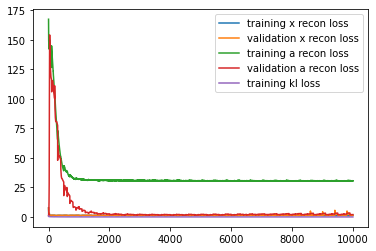

In [8]:
# plt.plot(np.arange(epochs),train_loss_ep)
# plt.plot(np.arange(epochs),val_loss_ep)
plt.plot(np.arange(epochs),train_loss_x_ep)
plt.plot(np.arange(epochs),val_loss_x_ep)
plt.plot(np.arange(epochs),train_loss_a_ep)
plt.plot(np.arange(epochs),val_loss_a_ep)
plt.plot(np.arange(epochs),train_loss_kl_ep)
# plt.plot(np.arange(epochs),np.array(train_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_adv_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(val_loss_advD_ep)*advWeight)
# plt.plot(np.arange(epochs),np.array(train_loss_clf_ep)*clfweight)
# plt.plot(np.arange(epochs),np.array(val_loss_clf_ep)*clfweight)
# plt.ylim((0,15))
# plt.xlim((0,3000))
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training kl loss'],loc='upper right')
# plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training classifier loss','validation classifier loss'],loc='upper right')
plt.legend(['training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
# plt.legend(['training loss','validation loss','training x recon loss','validation x recon loss','training a recon loss','validation a recon loss','training kl loss','training discriminator ae','validation discriminator ae','training discriminator d','validation discriminator d'],loc='upper right')
plt.savefig(os.path.join(plotsavepath,'loss_seed3_xa.jpg'))
plt.show()


In [8]:
# name='c13k20XA_07_dca'
# logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
# with open(os.path.join(logsavepath,'val_loss_a'), 'rb') as output:
#     val_loss_a_ep=pickle.load(output)
# np.argmin(val_loss_x_ep[:])
# # np.where(np.logical_not(np.isfinite(val_loss_ep[:])))
# val_loss_a_ep[8700]
torch.log(torch.tensor([1/0]))

ZeroDivisionError: division by zero

In [10]:
testepoch=9980
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(testepoch)+'.pt')))
model.eval()
for s in sampleidx.keys():
    print(s)
    
    adj_norm=adjnormlist[s].cuda().float()
    adj_label=adj_list[s].cuda().float()
    features=featureslist[s+'X_'+training_sample_X].cuda().float()
    pos_weight=pos_weightlist[s]
    norm=normlist[s]
    
    if 'dca' in model_str:
        features_raw=features_raw_list[s+'X_raw'].cuda()
    num_nodes,num_features = features.shape
    maskpath=os.path.join(savedir,'trainMask',s+'_'+maskedgeName+'_seed'+str(seed)+'.pkl')
    if useSavedMaskedEdges and os.path.exists(maskpath):
#         print('opening saved')
        with open(maskpath, 'rb') as input:
            maskedgeres = pickle.load(input)
    else:
        # construct training, validation, and test sets
        maskedgeres= preprocessing.mask_nodes_edges(features.shape[0],testNodeSize=testNodes,valNodeSize=valNodes)
        with open(maskpath, 'wb') as output:
            pickle.dump(maskedgeres, output, pickle.HIGHEST_PROTOCOL)
    train_nodes_idx,val_nodes_idx,test_nodes_idx = maskedgeres
    
    if s in training_samples:
        test_nodes_idx_s=test_nodes_idx
    else:
        test_nodes_idx_s=torch.tensor(np.arange(num_nodes))
        
#     adj_decode=None
#     if adj_decodeName == 'gala':
#         adj_decode=preprocessing.preprocess_graph_sharp(adj)

    if adj_decodeName==None:
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
    else:
        adj_decode=adj_decode.cuda()
        adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
    if adv and (s in list(sampleLabellist_ae.keys())):
        sampleLabel_ae=sampleLabellist_ae[s].cuda().float()
        modelAdv.eval()
        advOut=modelAdv(z)
    if 'dca' in model_str:
        if 'NB' in name:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx,XreconWeight)
        else:
            loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,ridgeL,features_raw)
    else:
        loss_x_test=loss_x(features_recon, features,test_nodes_idx_s,XreconWeight,mse)
    loss_a_test=loss_a(adj_recon, adj_label, pos_weight, norm,test_nodes_idx_s)
    loss_test = loss_x_test+loss_a_test
    
    if adv and (s in list(sampleLabellist_ae.keys())):
        loss_adv_test=loss_adv(advOut,sampleLabel_ae,test_nodes_idx)
        print('loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
        
    print('test results',
          'loss_test: {:.4f}'.format(loss_test.item()),
          'loss_x_test: {:.4f}'.format(loss_x_test.item()),
          'loss_a_test: {:.4f}'.format(loss_a_test.item()))
#          'loss_adv_test: {:.4f}'.format(loss_adv_test.item()))
    if protein:
        test_nodes_idx_s_genes=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_genes[2112:]=0
        test_nodes_idx_s_proteins=torch.clone(test_nodes_idx_s)
        test_nodes_idx_s_proteins[:2112]=0
        if 'dca' in model_str:
            loss_genes_test=loss_x(features_recon, features,test_nodes_idx_s_genes,XreconWeight,ridgeL,features_raw)
            loss_proteins_test=loss_x(features_recon, features,test_nodes_idx_s_proteins,XreconWeight,ridgeL,features_raw)
        print('loss_x_genes: {:.4f}'.format(loss_genes_test.item()),
          'loss_x_proteins: {:.4f}'.format(loss_proteins_test.item()))
    if 'dca' in model_str:
        features_raw=features_raw.cpu()

   

disease13
test results loss_test: 3.9568 loss_x_test: 1.4610 loss_a_test: 2.4958
control13
test results loss_test: 3.4027 loss_x_test: 1.3930 loss_a_test: 2.0097
disease8
test results loss_test: 3.4970 loss_x_test: 1.2748 loss_a_test: 2.2222
control8
test results loss_test: 4.7808 loss_x_test: 1.7866 loss_a_test: 2.9943


In [12]:
y_true=features
y_true_raw=features_raw
preds=features_recon
mask=nodesmask=torch.tensor(np.arange(num_nodes))
reconWeight=20
eps = 1e-10

output,pi,theta,y_pred=preds
nb_case=optimizer.optimizer_nb(preds,y_true,mask,reconWeight,eps = 1e-10,ifmean=False)- torch.log(pi+eps)

zero_nb = torch.pow(theta/(theta+y_pred+eps), theta)
zero_case = -torch.log(pi + ((1.0-pi)*zero_nb)+eps)
result = torch.where(torch.lt(y_true_raw.cuda(), 1), zero_case, nb_case)

In [13]:
result[:8,:8]

tensor([[-0.0000e+00, 2.1077e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [1.1921e-07, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.7968e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, 1.7740e+00,
         1.1915e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.1921e-07, -0.0000e+00],
        [1.1921e-07, 1.1921e-07, 1.1921e-07, -0.0000e+00, 1.1921e-07, 1.1921e-07,
         1.1921e-07, 1.1921e-07],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         1.4272e+00, -0.0000e+00]], device='cuda:0', grad_fn=<Slic

In [14]:
features[:8,:8]

tensor([[-0.2504,  8.5853, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [ 5.5540, -0.1938, -0.1941, -0.1474, -0.1934,  3.1612,  1.2601, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717, -0.5645, -0.3465],
        [-0.2504, -0.1938, -0.1941, -0.1474, -0.1934, -0.2717,  2.5718, -0.3465]],
       device='cuda:0')

In [15]:
zeroidx=(features_raw==0)
nonzeroidx=(features_raw!=0)
torch.sum(result[zeroidx])/torch.sum(result)

tensor(2.8589e-09, device='cuda:0', grad_fn=<DivBackward0>)

In [22]:
torch.sum(result[zeroidx])

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [1]:
# model.pi.weight[:8,:8]
ep

NameError: name 'ep' is not defined